# **Sections:**
1. [Imports and Data Source Path Configurations](#scrollTo=OfihUBkYUX9t)<br>
2. [Common Reusable Methods](#scrollTo=ahsgD6P2BhMT&line=1&uniqifier=1)
3. [Data Preparation and Feature Engineering](#scrollTo=HWQi0p9ah0Ck)
4. [EDA](#scrollTo=_VDIR1Ka0ElW&line=1&uniqifier=1)
5. [Correlations](#scrollTo=qcetXdyWbtqT&line=1&uniqifier=1)<br>
6. [KPIs](#scrollTo=i6eLzpX6pNzA&line=1&uniqifier=1)<br>
   a. [KPI Related Methods](#scrollTo=hJBVWuBoA-SM&line=1&uniqifier=1)<br>
   b. [Customer Portfolio Analysis](#scrollTo=wiZFCXA2_lZ4&line=1&uniqifier=1)<br>
   c. [Product Portfolio Analysis](#scrollTo=P85SNvMb_upw&line=1&uniqifier=1)<br>
   d. [Sales Dashboard](#scrollTo=9MRMDxoBILYb&line=1&uniqifier=1)<br>
   e. [Investment Analysis](#scrollTo=9L2QJ4CrNyfu&line=1&uniqifier=1)<br>
   f. [NPS Analysis](#scrollTo=gtyUuzTBeTI9&line=1&uniqifier=1)<br>
7. [Data Modelling](#scrollTo=Mqq3U5wsFZZE&line=1&uniqifier=1)
8. [Conclusion](#scrollTo=k8P26NlSpI0a&line=1&uniqifier=1)

### Problem Statement

## Imports and Data Source Path Configurations

In [ ]:
import warnings
from datetime import date,timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE,RFECV
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
import sklearn
import os


%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  base_datasource_path="/content/drive/MyDrive/Colab Notebooks/ElecKart/E-Commerce Capstone Dataset/"
  base_file_path="/content/drive/MyDrive/Colab Notebooks/ElecKart/"
except:
  #if running from local machine kindly place all the source files and this notebook in the same directory
  base_datasource_path=os.os.getcwd()+"/"
  base_file_path=base_datasource_path


Mounted at /content/drive


In [ ]:
filepath_consumerelectronics=base_datasource_path+"ConsumerElectronics.csv"
filepath_Weather_2015=base_datasource_path+"ONTARIO-2015.xlsx"
filepath_Weather_2016=base_datasource_path+"ONTARIO-2016.xlsx"
filepath_MediaAndOther=base_datasource_path+"Media data and other information.xlsx"




# **Common Resuable Methods**

In [ ]:
def checkColumnHasOutlier(dfInput,column_name,minQuartile=0.1,maxQuartile=0.9):
    QMin=dfInput[column_name].quantile(minQuartile)
    QMax=dfInput[column_name].quantile(maxQuartile)
    IQR=QMax-QMin
    IQRmin=QMin-(1.5*IQR)
    IQRmax=QMax+(1.5*IQR)
    dfLessThan=dfInput[dfInput[column_name]<IQRmin]
    dfGreaterThan=dfInput[dfInput[column_name]>IQRmax]
    hasOutlier=(dfLessThan.empty==False and dfGreaterThan.empty==False)
    return hasOutlier

In [ ]:
def getNullColumns(dfInput, exporttocsv=False,filename='nullcolumns.csv'):
    null_count=dfInput.isnull().sum()
    null_percentage=100.0*dfInput.isnull().sum()/len(dfInput.index)
    dfFinal=pd.DataFrame({'column_name':dfInput.columns,'null_count':null_count,'null_percentage':null_percentage,'dtype':dfInput.dtypes}).reset_index()
    for idx,row in dfFinal.iterrows():
        column_name=row['column_name']
        data_type=row['dtype']
        if data_type in ['float64','int64']:
            dfFinal['HasOutlier']=checkColumnHasOutlier(dfInput,column_name)
        else:
            dfFinal['HasOutlier']='False'
    if exporttocsv==True:
        dfFinal.to_csv(filename,index=False)
    dfFinal=dfFinal.drop('column_name',axis=1)
    dfFinal=dfFinal.rename({'index':'column_name'},axis=1)
    dfFinal=dfFinal[dfFinal['null_percentage']>0]
    dfFinal=dfFinal.sort_values(by='null_count',ascending=False).reset_index(drop=True)
    #print(dfFinal)
    return dfFinal

In [ ]:
def getColumnsByType(dfInput,column_type,exclude=False):
    lstColumns=[]
    column_type=column_type.strip().lower()
    dft=pd.DataFrame(dfInput.dtypes).reset_index()
    dft.columns=['column_name','dtype']
    if column_type=='numeric':
        lstColumns=list(dft[(dft['dtype']=='float64')|(dft['dtype']=='int64')|(dft['dtype']=='bool')]['column_name'])
    elif column_type=='categorical':
        lstColumns=list(dft[dft['dtype']=='object']['column_name'])
    return lstColumns


In [ ]:
def removeOutliersByThresholdValue(dfSource,column_name,threshold_value,draw_plot=False):
    dfTemp=dfSource[dfSource[column_name]<=threshold_value]
    if draw_plot==True:
        dfTemp.boxplot(column=[column_name],vert=False)
        plt.show()
    return dfTemp

In [ ]:
def getOutliers(dfInput,minQuartile=0.1,maxQuartile=0.9):
    numeric_cols=getColumnsByType(dfInput,"numeric")
    _dictOutliers=[]
    for column_name in numeric_cols:
      QMin=dfInput[column_name].quantile(minQuartile)
      QMax=dfInput[column_name].quantile(maxQuartile)
      IQR=QMax-QMin
      IQRmin=QMin-(1.5*IQR)
      IQRmax=QMax+(1.5*IQR)
      dfLessThan=dfInput[dfInput[column_name]<IQRmin]
      dfGreaterThan=dfInput[dfInput[column_name]>IQRmax]
      hasOutlier=(dfLessThan.empty==False or dfGreaterThan.empty==False)
      _item={"col":column_name,"hasOutlier":hasOutlier,"Min":dfInput[column_name].min(),
             "Max":dfInput[column_name].max(),
             "IQRQMin("+str(minQuartile)+")":IQRmin,"#LessThanIQRMin":str(len(dfLessThan)),
             "IQRMax("+str(maxQuartile)+")":IQRmax,"#GreaterThanIQRMax":str(len(dfGreaterThan))}
      _dictOutliers.append(_item)
    return pd.DataFrame.from_dict(_dictOutliers)

# Data Preparation and Feature Engineering
**Solution Approach**:


1.   Implemented multiple getData_* methods to import,format,derive new columns and remove unwanted columns.
2.   Data Sources imported/created:
     1.   Consumer Electronics [getData_ConsumerElectronics()]
     2.   Holidays [getData_Holidays()]
     3.   Weather  [getData_Weather()]
     4.   Investment [getData_Investment()]
     5.   NPS [getData_NPS()]
     6.   Sales Calendar [getData_SalesCalendar()]
3. Customer Segmentation through RFM Analysis is done before filtering.  
4. Consumer Electronics Data is filtered for the Product_Sub_categories:
      1. CameraAccessory
      2. HomeAudio
      3. GamingAccessory
4.   Filtered Consumer Electronics is merged with above Data Entities created.
5.   This Final Filtered and Merged Consumer Electronics Data is used for further KPI Analysis and Modeling







**getData_Consumer_Electronics():**
*   Imports Consumer Electronics Data
*   Derive **Order_Day,Order_Week,Day_Of_Week** from Order_Date
*   **Rename** s1_fact.order_payment_type as **order_payment_type**
*   **Format** DeliveryBdays, DeliveryCDays ,remove rows with DeliveryBdays=0
*   Derive New columns **Delivery Date**, Day, Week (Order_Date+DeliveryCDay)
*   Derive New Column **Pay Date** Based on Delivery Date
*   Format GMV Column and remove rows with GMV=0
*   Format Units Column and remove rows with Units=0
*   Derive New Column **Sale_Price** =GMV/Units
*   Derive New Column **Total_Sales** =sale_price * Units
*   **Remove** rows with **gmv**> **Total_Sales**
*   **Format** Product MRP and remove rows with Product_Mrp=0
*   Derive New Column **Discount**=Product MRP - Sale_Price
*   Derive New Column **Discount_Percentage**=Discount/Product MRP
*   Derive New Column **Markup (1/0)**=if sale_price > product_mrp
*   Derive New Column **Markdown (1/0)**=if sale_price < product_mrp
*   Remove Duplicates from entire Dataframe.
*   Derive New Column **Running_Week** to have continuous week_numbers.










In [ ]:
def getData_Consumer_Electronics():
  print("importing...ConsumerElectronics.csv.. Kindly wait..")
  dfTemp=pd.read_csv(filepath_consumerelectronics)
  print("imported",dfTemp.shape)
  print("="*20)
  print("Order Date Related columns | new column addition and formatting)")
  dfTemp["order_date"]=pd.to_datetime(dfTemp['order_date'])
  dfTemp["order_day"]=dfTemp["order_date"].dt.day
  dfTemp["order_day_of_week"]=dfTemp['order_date'].dt.day_of_week
  dfTemp['order_id']=dfTemp['order_id'].astype(str)
  dfTemp['order_item_id']=dfTemp['order_item_id'].astype(str)
  dfTemp["order_week"]=dfTemp["order_date"].dt.isocalendar().week
  print("="*20)
  print("rename column s1_fact.order_payment_type as order_payment_type")
  dfTemp.rename(columns={"s1_fact.order_payment_type":"order_payment_type"},inplace=True)
  #models must be built at a weekly level for each of the subcategorie
  print("="*20)
  print("deliverybdays formatting...")
  dfTemp["deliverybdays"]=dfTemp["deliverybdays"].replace({'\\N': -1})
  dfTemp["deliverybdays"]=dfTemp["deliverybdays"].astype(int)
  print("deliverycdays formatting...")
  dfTemp["deliverycdays"]=dfTemp["deliverycdays"].replace({'\\N':-1})
  dfTemp["deliverycdays"]=dfTemp["deliverycdays"].astype(int) #
  print("check and remove DeliveryBDays<0")
  rows_deliverybdays_lessthan_zero=len(dfTemp[dfTemp["deliverybdays"]<0])
  if rows_deliverybdays_lessthan_zero>0:
    dfTemp=dfTemp[dfTemp["deliverybdays"]>0]
    print(rows_deliverybdays_lessthan_zero, "row(s) removed")
  else:
    print("Does not exists")
  print("check and remove DeliveryCDays<0")
  rows_deliverycdays_lessthan_zero=len(dfTemp[dfTemp["deliverycdays"]<0])
  if rows_deliverycdays_lessthan_zero>0:
    dfTemp=dfTemp[dfTemp["deliverycdays"]>0]
    print(rows_deliverycdays_lessthan_zero, "row(s) removed")
  else:
    print("Does not exists")
  print("new column: delivery_date...")
  dfTemp["delivery_date"]=dfTemp["order_date"]+pd.to_timedelta(dfTemp['deliverycdays'], unit='D')
  print("new column:delivery_day...")
  dfTemp["delivery_day"]=dfTemp['delivery_date'].dt.day
  print("new column:delivery_day_of_week")
  dfTemp["delivery_day_of_week"]=dfTemp["delivery_date"].dt.day_of_week
  print("="*20)
  print("remove product_procurement_sla=-1")
  print("before removing:",dfTemp.shape)
  dfTemp=dfTemp[dfTemp["product_procurement_sla"]>0]
  print("after removing:",dfTemp.shape)

  print("new column:Pay_Date")
  dfTemp["Pay_Date"]=dfTemp["delivery_day"].apply(lambda x: 1 if x==15 or x==1 else 0)
  print("="*20)
  print("gmv formatting")
  dfTemp['gmv']=dfTemp['gmv'].astype(str)
  dfTemp['gmv']=dfTemp['gmv'].apply(lambda x:'0' if x==' ' or x=='' else x.strip())
  dfTemp['gmv'].fillna('0.0',inplace=True)
  dfTemp['gmv']=dfTemp['gmv'].astype(float)
  print("check for rows with gmv==0 and remove")
  rows_gmv_0=len(dfTemp[dfTemp["gmv"]==0])
  if rows_gmv_0>0:
    dfTemp=dfTemp[dfTemp["gmv"]>0]
    print(rows_gmv_0,"row(s) removed")
  else:
    print("Does not Exist")
  print("="*20)
  print("units formatting")
  dfTemp["units"]=dfTemp["units"].astype(int)
  print("check for rows with Units==0 and remove")
  rows_units_0=len(dfTemp[dfTemp["units"]==0])
  if rows_units_0>0:
    dfTemp=dfTemp[dfTemp["units"]>0]
    print(rows_units_0, "row(s) removed")
  else:
    print("Does not exist")
  print("="*20)
  print("new column: Sale_Price= gmv / Units | source: https://www.investopedia.com/terms/g/gross-merchandise-value.asp")
  dfTemp["sale_price"]=dfTemp["gmv"]/dfTemp["units"] #Units with 0 are removed already so Divide by Zero is already taken care.
  #This column is created to compare gmv - Gross Merchandise Value
  print("new column:Total_Sales=sale_price*units")
  dfTemp["Total_Sales"]=dfTemp["sale_price"]*1.0*dfTemp["units"]*1.0
  dfTemp["Total_Sales_Million"]=dfTemp["Total_Sales"]/1000000
  print("="*20)
  print("check for rows with gmv>Total_Sales")
  rows_gmv_greater_than_totalsales=len(dfTemp[dfTemp["gmv"]>dfTemp["Total_Sales"]])
  if rows_gmv_greater_than_totalsales>0:
    dfTemp=dfTemp[dfTemp["gmv"]<=dfTemp["Total_Sales"]]
    print(rows_gmv_greater_than_totalsales, "row(s) removed")
  else:
    print("Does Not Exist")

  print("="*20)
  print("product_mrp formatting")
  dfTemp["product_mrp"]=dfTemp["product_mrp"].astype(float)
  print("check and remove rows with product_mrp as 0")
  product_mrp0_rows=len(dfTemp[dfTemp["product_mrp"]==0])
  if product_mrp0_rows>0:
    dfTemp=dfTemp[dfTemp["product_mrp"]>0]
    print(product_mrp0_rows,"row(s) removed")
  else:
    print("Does Not Exist")
  print("="*20)
  print("new columns:discount = product_mrp-sale_price and discount%=product_mrp-sale_price/product_mrp")
  dfTemp["discount"]=dfTemp["product_mrp"]*1.0-dfTemp["sale_price"]*1.0
  #product_mrp 0 is already handled so divide by zero is taken care
  dfTemp["discount_percentage"]=np.round(((dfTemp["discount"])/dfTemp["product_mrp"]*1.0),2)*100.0
  print("="*20)
  print("new columns:Markup (sale_price>product_mrp) | Markup Down(sale_price<product_mrp) ")
  dfTemp["Markup"]=dfTemp.apply(lambda x: 1 if x["product_mrp"]<x["sale_price"] else 0,axis=1)
  dfTemp["Markdown"]=dfTemp.apply(lambda x: 1 if x["product_mrp"]>x["sale_price"] else 0,axis=1)
  print("="*20)
  print("formatting:cust_id and pincode")
  dfTemp["cust_id"]=dfTemp["cust_id"].astype(float)
  dfTemp["pincode"]=dfTemp["pincode"].astype(float)
  print("before dropping duplicates",dfTemp.shape)
  dfTemp=dfTemp.drop_duplicates(keep='first')
  print("after dropping duplicates",dfTemp.shape)
  print("Final Data Shape=",dfTemp.shape)
  print("="*20)
  print("new column: running week to maintain continuous week number from 2015 to 2016 to show the weekly trends")
  min_week_15=dfTemp[dfTemp["Year"]==2015]["order_week"].min()
  max_week_15=dfTemp[dfTemp["Year"]==2015]["order_week"].max()
  min_week_16=dfTemp[dfTemp["Year"]==2016]["order_week"].min()
  max_week_16=dfTemp[dfTemp["Year"]==2016]["order_week"].max()

  print("min_max_Yr15",min_week_15,max_week_15)
  dfTemp.drop(["running_week"],axis=1,inplace=True,errors='ignore')
  dfTemp["running_week"]=0
  for i in range(min_week_15,max_week_15+1):
    dfTemp.loc[(dfTemp["Year"]==2015) & (dfTemp["order_week"]==i), 'running_week'] = (i-min_week_15)+1
  max_running_week_15=dfTemp[dfTemp["Year"]==2015]["running_week"].max()
  print("min_max_Yr16",min_week_16,max_week_16)
  for j in range(min_week_16,max_week_16+1):
    dfTemp.loc[(dfTemp["Year"]==2016) & (dfTemp["order_week"]==j), 'running_week'] = j+max_running_week_15

  print("2015.running_week_min",dfTemp[dfTemp["Year"]==2015]["running_week"].min())
  print("2015.running_week_max",dfTemp[dfTemp["Year"]==2015]["running_week"].max())
  print("2016.running_week_min",dfTemp[dfTemp["Year"]==2016]["running_week"].min())
  print("2016.running_week_max",dfTemp[dfTemp["Year"]==2016]["running_week"].max())
  print("="*20)
  print("Summary of New columns added:")
  print("order_day,order_day_of_week,order_week,delivery_date,delivery_day,delivery_day_of_week,Pay_Date,sale_price,Total_Sales,discount,discount_percentage")
  print("="*20)
  print("Processing completed..")
  print("="*20)
  return dfTemp

**getData_Holidays():**<br>
**#Data Sources**

*   https://www.officeholidays.com/countries/canada/ontario/2015
*   https://www.officeholidays.com/countries/canada/ontario/2016

* Static Dictionary for Holiday Data (2015,2016) basis the above sources.
* Drop Unwanted Columns
* Create Additional Columns for Day, Week, Day of week



In [ ]:
def getData_Holidays():
  print("Ontario Official Holidays for 2015 and 2016")
  print("Sources = [https://www.officeholidays.com/countries/canada/ontario/2015 | https://www.officeholidays.com/countries/canada/ontario/2016]")
  holidays=[
   {"Holiday_Year":2015,"Holiday_Date":"01-Jan-2015","Holiday_Month":1,"Holiday_Day_Number":1,"Day_Name":"Thursday","Date":"Jan 01","Holiday Name":"New Year's Day","Type":"Statutory Holiday","Comments":""},
   {"Holiday_Year":2015,"Holiday_Date":"01-Feb-2015","Holiday_Month":2,"Holiday_Day_Number":16,"Day_Name":"Monday","Date":"Feb 16","Holiday Name":"Family Day","Type":"Regional Holiday","Comments":"Statutory holiday in several provinces"},
   {"Holiday_Year":2016,"Holiday_Date":"25-Mar-2016","Holiday_Month":3,"Holiday_Day_Number":25,"Day_Name":"Friday","Date":"Mar 25","Holiday Name":"Good Friday","Type":"Regional Holiday","Comments":"Statutory, optional in Quebec"},
   {"Holiday_Year":2015,"Holiday_Date":"02-Apr-2015","Holiday_Month":4,"Holiday_Day_Number":3,"Day_Name":"Friday","Date":"Apr 03","Holiday Name":"Good Friday","Type":"Regional Holiday","Comments":"Statutory, optional in Quebec"},
   {"Holiday_Year":2015,"Holiday_Date":"10-May-2015","Holiday_Month":5,"Holiday_Day_Number":10,"Day_Name":"Sunday","Date":"May 10","Holiday Name":"Mother's Day","Type":"Not A Public Holiday","Comments":""},
   {"Holiday_Year":2016,"Holiday_Date":"08-May-2016","Holiday_Month":5,"Holiday_Day_Number":8, "Day_Name":"Sunday","Date":"May 8","Holiday Name":"Mother's Day","Type":"Not A Public Holiday","Comments":""},
   {"Holiday_Year":2015,"Holiday_Date":"18-May-2015","Holiday_Month":5,"Holiday_Day_Number":18,"Day_Name":"Monday","Date":"May 18","Holiday Name":"Victoria Day","Type":"Regional Holiday","Comments":"Monday on or before May 24. Statutory, except in New Brunswick, Nova Scotia and Prince Edward Island"},
   {"Holiday_Year":2016,"Holiday_Date":"23-May-2016","Holiday_Month":5,"Holiday_Day_Number":23,"Day_Name":"Monday","Date":"May 23","Holiday Name":"Victoria Day","Type":"Regional Holiday","Comments":"Monday on or before May 24. Statutory, except in New Brunswick, Nova Scotia and Prince Edward Island"},
   {"Holiday_Year":2015,"Holiday_Date":"21-Jun-2015","Holiday_Month":6,"Holiday_Day_Number":21,"Day_Name":"Sunday","Date":"Jun 21","Holiday Name":"Father';s Day","Type":"Not A Public Holiday","Comments":"3rd Sunday in June. Not a public holiday"},
   {"Holiday_Year":2015,"Holiday_Date":"19-Jun-2016","Holiday_Month":6,"Holiday_Day_Number":19,"Day_Name":"Sunday","Date":"Jun 19","Holiday Name":"Father';s Day","Type":"Not A Public Holiday","Comments":"3rd Sunday in June. Not a public holiday"},
   {"Holiday_Year":2015,"Holiday_Date":"01-Jul-2015","Holiday_Month":7,"Holiday_Day_Number":1,"Day_Name":"Wednesday","Date":"Jul 01","Holiday Name":"Canada Day","Type":"Statutory Holiday","Comments":"National Day"},
   {"Holiday_Year":2016,"Holiday_Date":"01-Jul-2016","Holiday_Month":7,"Holiday_Day_Number":1,"Day_Name":"Wednesday","Date":"Jul 01","Holiday Name":"Canada Day","Type":"Statutory Holiday","Comments":"National Day"},
   {"Holiday_Year":2015,"Holiday_Date":"07-Sep-2015","Holiday_Month":9,"Holiday_Day_Number":7,"Day_Name":"Monday","Date":"Sep 07","Holiday Name":" Labour Day","Type":"Statutory Holiday","Comments":"First Monday in September"},
   {"Holiday_Year":2016,"Holiday_Date":"05-Sep-2015","Holiday_Month":9,"Holiday_Day_Number":5,"Day_Name":"Monday","Date":"Sep 05","Holiday Name":" Labour Day","Type":"Statutory Holiday","Comments":"First Monday in September"},
   {"Holiday_Year":2015,"Holiday_Date":"12-Oct-2015","Holiday_Month":10,"Holiday_Day_Number":12,"Day_Name":"Monday","Date":"Oct 12","Holiday Name":"Thanksgiving","Type":"Regional Holiday","Comments":"2nd Monday in October"},
   {"Holiday_Year":2016,"Holiday_Date":"10-Oct-2015","Holiday_Month":10,"Holiday_Day_Number":10,"Day_Name":"Monday","Date":"Oct 10","Holiday Name":"Thanksgiving","Type":"Regional Holiday","Comments":"2nd Monday in October"},
   {"Holiday_Year":2015,"Holiday_Date":"25-Dec-2015","Holiday_Month":12,"Holiday_Day_Number":25,"Day_Name":"Friday","Date":"Dec 25","Holiday Name":"Christmas Day","Type":"Statutory Holiday","Comments":""},
   {"Holiday_Year":2016,"Holiday_Date":"25-Dec-2016","Holiday_Month":12,"Holiday_Day_Number":25,"Day_Name":"Sunday","Date":"Dec 25","Holiday Name":"Christmas Day","Type":"Statutory Holiday","Comments":""},
   {"Holiday_Year":2015,"Holiday_Date":"26-Dec-2015","Holiday_Month":12,"Holiday_Day_Number":26,"Day_Name":"Saturday","Date":"Dec 26","Holiday Name":"Boxing Day","Type":"Regional Holiday","Comments":"Statutory in Ontario and federal jurisdictions"},
   {"Holiday_Year":2016,"Holiday_Date":"26-Dec-2016","Holiday_Month":12,"Holiday_Day_Number":26,"Day_Name":"Monday","Date":"Dec 26","Holiday Name":"Boxing Day","Type":"Regional Holiday","Comments":"Statutory in Ontario and federal jurisdictions"},
   {"Holiday_Year":2016,"Holiday_Date":"27-Dec-2016","Holiday_Month":12,"Holiday_Day_Number":27,"Day_Name":"Tuesday","Date":"Dec 27","Holiday Name":"Boxing Day","Type":"Regional Holiday","Comments":"Statutory in Ontario and federal jurisdictions"},
   ]

  dfHolidays=pd.DataFrame.from_dict(holidays)
  dfHolidays.drop(['Holiday Name',"Comments","Type"],axis=1,inplace=True)

  dfHolidays["Holiday_Date"]=pd.to_datetime(dfHolidays["Holiday_Date"])
  dfHolidays["Holiday_DayOfWeek"]=dfHolidays["Holiday_Date"].dt.day_of_week
  dfHolidays["Holiday_Week"]=dfHolidays["Holiday_Date"].dt.isocalendar().week


  return dfHolidays


In [ ]:
dfHolidays=getData_Holidays()
dfHolidays

Ontario Official Holidays for 2015 and 2016
Sources = [https://www.officeholidays.com/countries/canada/ontario/2015 | https://www.officeholidays.com/countries/canada/ontario/2016]


Holiday_Year Holiday_Date  Holiday_Month  Holiday_Day_Number   Day_Name  \
0           2015   2015-01-01              1                   1   Thursday   
1           2015   2015-02-01              2                  16     Monday   
2           2016   2016-03-25              3                  25     Friday   
3           2015   2015-04-02              4                   3     Friday   
4           2015   2015-05-10              5                  10     Sunday   
5           2016   2016-05-08              5                   8     Sunday   
6           2015   2015-05-18              5                  18     Monday   
7           2016   2016-05-23              5                  23     Monday   
8           2015   2015-06-21              6                  21     Sunday   
9           2015   2016-06-19              6                  19     Sunday   
10          2015   2015-07-01              7                   1  Wednesday   
11          2016   2016-07-01              7                   1  Wednesday   
12          2015   2015-09-07              9                   7     Monday   
13          2016   2015-09-05              9                   5     Monday   
14          2015   2015-10-12             10                  12     Monday   
15          2016   2015-10-10             10                  10     Monday   
16          2015   2015-12-25             12                  25     Friday   
17          2016   2016-12-25             12                  25     Sunday   
18          2015   2015-12-26             12                  26   Saturday   
19          2016   2016-12-26             12                  26     Monday   
20          2016   2016-12-27             12                  27    Tuesday   

      Date  Holiday_DayOfWeek  Holiday_Week  
0   Jan 01                  3             1  
1   Feb 16                  6             5  
2   Mar 25                  4            12  
3   Apr 03                  3            14  
4   May 10                  6            19  
5    May 8                  6            18  
6   May 18                  0            21  
7   May 23                  0            21  
8   Jun 21                  6            25  
9   Jun 19                  6            24  
10  Jul 01                  2            27  
11  Jul 01                  4            26  
12  Sep 07                  0            37  
13  Sep 05                  5            36  
14  Oct 12                  0            42  
15  Oct 10                  5            41  
16  Dec 25                  4            52  
17  Dec 25                  6            51  
18  Dec 26                  5            52  
19  Dec 26                  0            52  
20  Dec 27                  1            52

**getData_Weather():**


*   Import Ontario_2015 and Ontario_2016 excel files
*   Concat vertically to create a single data source
*   Format Column Names, drop unwanted columns





In [ ]:
def getData_Weather():
  print("importing 2015 Weather data")
  dfWeather_2015=pd.read_excel(filepath_Weather_2015,skiprows=24)
  print("imported:",dfWeather_2015.shape)
  print("importing 2016 Weather data")
  dfWeather_2016=pd.read_excel(filepath_Weather_2016,skiprows=24)
  print("imported:",dfWeather_2016.shape)
  dfWeather_consolidated=pd.concat([dfWeather_2015,dfWeather_2016],axis=0)
  dfWeather_consolidated.rename(columns={'Date/Time':'Weather_Date','Year':'Weather_Year','Month':'Weather_Month','Data Quality':'Weather_Data_Quality','Day':'Weather_Day'},inplace=True)
  dfWeather_consolidated.columns = dfWeather_consolidated.columns.str.replace(' ', '_')
  dfWeather_consolidated.columns = dfWeather_consolidated.columns.str.replace('(', '_')
  dfWeather_consolidated.columns = dfWeather_consolidated.columns.str.replace(')', '')
  dfWeather_consolidated.columns = dfWeather_consolidated.columns.str.replace('°C', 'Degc')
  dfWeather_consolidated.columns = dfWeather_consolidated.columns.str.replace('km/h', 'Kmh')
  dfWeather_consolidated.columns = dfWeather_consolidated.columns.str.replace('10s deg', 'rounded')
  dropcolumns=['Max_Temp_Flag','Min_Temp_Flag','Heat_Deg_Days_Flag','Cool_Deg_Days_Flag','Total_Rain_Flag','Total_Snow_Flag','Total_Precip_Flag','Dir_of_Max_Gust__10s_deg', 'Dir_of_Max_Gust_Flag',
       'Spd_of_Max_Gust__Kmh', 'Spd_of_Max_Gust_Flag','Snow_on_Grnd_Flag']
  dfWeather_consolidated.drop(dropcolumns,axis=1,inplace=True)
  dfWeather_consolidated.fillna(0,inplace=True)

  print("completed")
  return dfWeather_consolidated


**getData_MediaInvestmentAndOther():**
Common Method to return Data by Sheet Name from MediaInvestment and Other Excel File

In [ ]:
def getData_MediaInvestmentAndOther(_sheet,_skiprows=0):
  dfTemp=pd.read_excel(filepath_MediaAndOther,sheet_name=_sheet,skiprows=_skiprows)
  return dfTemp


**getData_Investment():**


1.   Import Data from **Media Investment** Sheet.
2.   Rename columns
3.   Calculate Investment Drop or Increase [current-Prev]




In [ ]:
def getReference_YearMonth():
  number_of_weeks={'Month':[1,2,3,4,5,6,7,8,9,10,11,12],'number_of_days':[31,28,31,30,31,30,31,31,30,31,30,31]}
  dfnumber_of_weeks_15=pd.DataFrame(number_of_weeks)
  dfnumber_of_weeks_15["Year"]=2015
  number_of_weeks={'Month':[1,2,3,4,5,6,7,8,9,10,11,12],'number_of_days':[31,29,31,30,31,30,31,31,30,31,30,31]}
  dfnumber_of_weeks_16=pd.DataFrame(number_of_weeks)
  dfnumber_of_weeks_16["Year"]=2016
  dfReference_YearMonth=pd.concat([dfnumber_of_weeks_15,dfnumber_of_weeks_16],axis=0)
  dfReference_YearMonth["number_of_weeks"]=dfReference_YearMonth.apply(lambda x: round(x["number_of_days"]/7,2),axis=1)
  return dfReference_YearMonth




In [ ]:
def getData_Investment():
  dfTemp=getData_MediaInvestmentAndOther("Media Investment",2)
  dfTemp.drop(dfTemp.columns[dfTemp.columns.str.contains('unnamed',case=False)],axis=1,inplace=True)
  dfTemp.fillna(0,inplace=True)
  dfTemp.rename(columns={'Year':'Invst_Year','Month':'Invst_Month','Total Investment':'Invst_Total'},inplace=True)
  dfTemp["Invst_Year"]=dfTemp["Invst_Year"].astype(int)
  dfTemp["Invst_Month"]=dfTemp["Invst_Month"].astype(int)
  #This column is created to see if the drop/raise in Media Investment correlates with Sales in the respective Month
  dfTemp["Invst_Total_Next"]=dfTemp["Invst_Total"].diff()
  dfTemp["Invst_Total_Next"].fillna(dfTemp["Invst_Total"][0],inplace=True)
  dfTemp["Invst_Drop"]=dfTemp["Invst_Total_Next"].apply(lambda x : 1 if x<0 else 0)


  dfTemp=dfTemp[dfTemp["Invst_Year"].isin([2015,2016])]
  dfTemp=pd.merge(dfTemp,getReference_YearMonth(),how="left",left_on=["Invst_Year","Invst_Month"],right_on=["Year","Month"])
  dfTemp["Invst_Per_Week"]=dfTemp["Invst_Total"]/dfTemp["number_of_weeks"]
  dfTemp.drop(["Year","Month"],axis=1,inplace=True)
  return dfTemp



In [ ]:
getData_Investment()

Invst_Year  Invst_Month  Invst_Total        TV    Digital  Sponsorship  \
0         2015            7    17.061775  0.215330   2.533014     7.414270   
1         2015            8     5.064306  0.006438   1.278074     1.063332   
2         2015            9    96.254380  3.879504   1.356528    62.787651   
3         2015           10   170.156297  6.144711  12.622480    84.672532   
4         2015           11    51.216220  4.220630   1.275469    14.172116   
5         2015           12   106.745312  5.397502   3.063360    56.705419   
6         2016            1    74.196000  4.380000   0.456000     4.200000   
7         2016            2    48.052000  2.586008   1.912651    11.725555   
8         2016            3   100.024621  9.300000   2.100000    41.590000   
9         2016            4    56.848241  5.205196   0.871892    24.308354   
10        2016            5    78.057000  1.370000   0.770000    31.680000   
11        2016            6    42.834216  1.662717   1.420761    25.048541   

    Content Marketing  Online marketing   Affiliates        SEM  Radio  \
0            0.000933          1.327278     0.547254   5.023697   0.00   
1            0.000006          0.129244     0.073684   2.513528   0.00   
2            0.610292         16.379990     5.038266   6.202149   0.00   
3            3.444075         24.371778     6.973711  31.927011   0.00   
4            0.168633         19.561574     6.595767   5.222032   0.00   
5            1.067307         22.503756     6.826938  11.181030   0.00   
6            0.900000         22.900000     7.370000   4.200000   2.70   
7            0.596771         19.892366     6.465019   4.873630   0.00   
8            0.370000         18.437818     6.217667   5.193591   0.87   
9            0.034876         16.514510     5.693456   4.219958   0.00   
10           0.790000         23.650000     6.800000   6.910000   1.10   
11           0.045081          7.971300     2.768023   3.735516   0.00   

        Other  Invst_Total_Next  Invst_Drop  number_of_days  number_of_weeks  \
0    0.000000         17.061775           0              31             4.43   
1    0.000000        -11.997469           1              31             4.43   
2    0.000000         91.190074           0              30             4.29   
3    0.000000         73.901918           0              31             4.43   
4    0.000000       -118.940077           1              30             4.29   
5    0.000000         55.529091           0              31             4.43   
6   27.090000        -32.549312           1              31             4.43   
7    0.000000        -26.144000           1              29             4.14   
8   15.945545         51.972621           0              31             4.43   
9    0.000000        -43.176380           1              30             4.29   
10   4.987000         21.208759           0              31             4.43   
11   0.000000        -35.222784           1              30             4.29   

    Invst_Per_Week  
0         3.851417  
1         1.143184  
2        22.436918  
3        38.409999  
4        11.938513  
5        24.096007  
6        16.748533  
7        11.606763  
8        22.578921  
9        13.251338  
10       17.620090  
11        9.984666

**getData_NPS():**


*   Import 'Monthly NPS Score'
*   Transpose Data Source and create additional columns
*   Calculate NPS Drop/Increase [Current-Previous]




In [ ]:
def getData_NPS():
  dfTemp_NPS=getData_MediaInvestmentAndOther("Monthly NPS Score")
  print("imported:",dfTemp_NPS.shape)
  dfTemp_NPS.rename(columns={'Unnamed: 0':'index'},inplace=True)
  print("transposing")
  dfTemp_NPS=dfTemp_NPS.transpose()
  dfTemp_NPS.columns=dfTemp_NPS.iloc[0]
  dfTemp_NPS=dfTemp_NPS[1:]
  dfTemp_NPS['NPS_Year']=dfTemp_NPS.index
  dfTemp_NPS['NPS_Year']=dfTemp_NPS['NPS_Year'].apply(lambda x: '20'+x.split("'")[1])
  dfTemp_NPS["NPS_Month_Name"]=dfTemp_NPS.index
  dfTemp_NPS["NPS_Month_Name"]=dfTemp_NPS["NPS_Month_Name"].apply(lambda x: x.split("'")[0][0:3])
  #generating dummy date (will be dropped later) basis the NPS Year and month to extract Month Number
  dfTemp_NPS["Temp_Date"]=dfTemp_NPS.apply(lambda x: "01-"+x["NPS_Month_Name"]+x['NPS_Year'],axis=1)
  dfTemp_NPS["Temp_Date"]=pd.to_datetime(dfTemp_NPS["Temp_Date"])
  dfTemp_NPS["NPS_Month"]=dfTemp_NPS["Temp_Date"].dt.month
  print("data type conversions and dropping unwanted columns")
  dfTemp_NPS["NPS_Year"]=dfTemp_NPS['NPS_Year'].astype(int)
  dfTemp_NPS["NPS_Month"]=dfTemp_NPS['NPS_Month'].astype(int)
  dfTemp_NPS["NPS_Next"]=dfTemp_NPS["NPS"].diff()
  dfTemp_NPS["NPS_Next"].fillna(dfTemp_NPS["NPS"][0],inplace=True)
  dfTemp_NPS["NPS_Drop"]=dfTemp_NPS["NPS_Next"].apply(lambda x: 1 if x<0 else 0)

  dfTemp_NPS=dfTemp_NPS.reset_index()
  dfTemp_NPS.drop(["Temp_Date","index"],inplace=True,axis=1)
  return dfTemp_NPS

**getData_SalesCalendar():**


*   Import 'Special Sale Calendar' Sheet
*   Do String Processing to extract Sale Start and End Date
*   Return Range of Sale Dates, that it can be used to flag if there was a sale on the specific date when a product was ordered




In [ ]:
def getData_SalesCalendar():
  dfTemp=getData_MediaInvestmentAndOther("Special Sale Calendar")
  print("imported",dfTemp.shape)
  #print(dfTemp)
  dfTemp.drop(['Unnamed: 0'],axis=1,inplace=True)
  dfTemp.rename(columns={'Unnamed: 1':'Year'},inplace=True)
  dfTemp['Year'].fillna(0,inplace=True)
  dfTemp['Year']=dfTemp['Year'].astype(int)
  copy_value=0
  base_index=0
  #Extracting Start and End of Sale Date and prepare a linear Dataset with list of Sale_Dates
  #This will be used later to merge with final data set to check if a particular order_Date falls on sale Date

  for index, row in dfTemp.iterrows():
    if row['Year']>0:
      copy_value=row['Year']
      base_index=index
    "Copying the Current Year to subsequent row till the Next YEar (eg: 2016) is reached"
    if copy_value>0 and index>base_index:
      dfTemp.at[index,'Year']=copy_value
  #print("after Year repeat",dfTemp)
  print("Extracting the Month and date from the 'Sale Calendar' column to prepare the Sale Start and End Dates")
  colname_Sales_Calendar='Sales Calendar'
  dfTemp[colname_Sales_Calendar]=dfTemp[colname_Sales_Calendar].apply(lambda x: x.replace('(','').replace(')','').replace(' - ','-').strip())
  print("Start_Date")
  dfTemp['Start_Date']=dfTemp[colname_Sales_Calendar].apply(lambda x: x.split("-")[0])
  #As the Year is already obtained, removing the '15, '16 from the Date and prepareing for getting the day
  dfTemp['Start_Date']=dfTemp['Start_Date'].apply(lambda x: x.replace("'15","").replace("'16","").replace("rd ","-").replace("th ","-").replace(" ","-").strip())
  print("Start_Day")
  dfTemp['Start_Day']=dfTemp['Start_Date'].apply(lambda x: x.split("-")[0].strip())
  dfTemp['Start_Day']=dfTemp['Start_Day'].astype(int)
  print("End_Date")
  dfTemp["End_Date"]=dfTemp[colname_Sales_Calendar].apply(lambda x: x.split("-")[1])
  dfTemp["End_Date"]=dfTemp["End_Date"].apply(lambda x: x.replace("'15","").replace("'16","").replace("rd ","-").replace("th ","-").replace(" ","-").strip())
  print("End_Day")
  dfTemp["End_Day"]=dfTemp["End_Date"].apply(lambda x: x.split("-")[0])
  dfTemp["End_Day"]=dfTemp["End_Day"].astype(int)
  print("Start_Month")
  #in case if Start Date has a Month use it or use the End Date Month
  # this is to address the case where the date flows from current to next year like 25-Dec to 03rd Jan
  dfTemp["Start_Month"]=dfTemp[["Start_Date","End_Date"]].apply(lambda x: x['Start_Date'].split("-")[1] if "-" in x["Start_Date"] else x["End_Date"].split("-")[1],axis=1)
  dfTemp["Start_Month"]=dfTemp["Start_Month"].apply(lambda x:x[0:3])
  print("End_Month")
  dfTemp["End_Month"]=dfTemp["End_Date"].apply(lambda x: x.split("-")[1][0:3])
  print("Sales_Start_Date")
  dfTemp["Sales_Start_Date"]=dfTemp.apply(lambda x:str(x['Start_Day'])+"-"+str(x["Start_Month"]+"-"+str(x["Year"])),axis=1)
  dfTemp["Sales_Start_Date"]=pd.to_datetime(dfTemp["Sales_Start_Date"])
  print("Sales_End_Date")
  dfTemp["Sales_End_Date"]=dfTemp.apply(lambda x:str(x['End_Day'])+"-"+str(x["End_Month"]+"-"+str(x["Year"])),axis=1)
  dfTemp["Sales_End_Date"]=pd.to_datetime(dfTemp["Sales_End_Date"])
  #Now will loop through dataframe to generate list of Sale Dates basis the above data ranges obtained:
  _dictTemp=[]
  for index, row in dfTemp.iterrows():
    year=row['Year']
    start_date=row["Sales_Start_Date"]
    end_date=row["Sales_End_Date"]
    listofDates=list(pd.date_range(start_date,end_date,freq='d'))
    for _currentDate in listofDates:
      _dictTemp.append({"Sale_Year":year,"Sale_Date":_currentDate})
  dfTemp_SalesCalendar=pd.DataFrame.from_dict(_dictTemp)
  dfTemp_SalesCalendar["Sale_Date"]=pd.to_datetime(dfTemp_SalesCalendar["Sale_Date"])
  dfTemp_SalesCalendar["Sale_Month"]=dfTemp_SalesCalendar["Sale_Date"].dt.month
  dfTemp_SalesCalendar["Sale_Day"]=dfTemp_SalesCalendar["Sale_Date"].dt.day
  dfTemp_SalesCalendar["Sale_Day_Of_Week"]=dfTemp_SalesCalendar["Sale_Date"].dt.day_of_week
  return dfTemp_SalesCalendar










# Importing All Data Sources by calling respective getData_* methods

In [ ]:
dfSource=getData_Consumer_Electronics()
print("Consumer ELectronics",dfSource.shape)
dfWeather=getData_Weather()
print("Weather",dfWeather.shape)
dfInvestment=getData_Investment()
print("Investment",dfInvestment.shape)
dfNPS=getData_NPS()
print("NPS",dfNPS.shape)
dfSalesCalendar=getData_SalesCalendar()
print("Sales Calendar",dfSalesCalendar.shape)

importing...ConsumerElectronics.csv.. Kindly wait..
imported (1648824, 20)
Order Date Related columns | new column addition and formatting)
rename column s1_fact.order_payment_type as order_payment_type
deliverybdays formatting...
deliverycdays formatting...
check and remove DeliveryBDays<0
1313010 row(s) removed
check and remove DeliveryCDays<0
Does not exists
new column: delivery_date...
new column:delivery_day...
new column:delivery_day_of_week
remove product_procurement_sla=-1
before removing: (333455, 26)
after removing: (319569, 26)
new column:Pay_Date
gmv formatting
check for rows with gmv==0 and remove
84 row(s) removed
units formatting
check for rows with Units==0 and remove
Does not exist
new column: Sale_Price= gmv / Units | source: https://www.investopedia.com/terms/g/gross-merchandise-value.asp
new column:Total_Sales=sale_price*units
check for rows with gmv>Total_Sales
1 row(s) removed
product_mrp formatting
check and remove rows with product_mrp as 0
Does Not Exist
new co

# Customer Segmentation Through Recency, Frequency , Monetary Value Analysis

**Solution Approach**<br>
Before filtering for the 3 product sub categories:<br>

1.   Get Customer's Presence :Least and Latest or Year, Month, Running_Weeks
2.   Calculate AoV and other columns.
2.   Calculate the RFM Score and Apply Customer Segmentation.



**getData_CustomerInfo()**

***Calculate below grouped by cust_id , which is further used to calculate the Recency , Frequency and Monetary Value of a Customer:<Br>***
*   Calculating the Least and Latest of customer orders for :<br>
Year, Month, day, running.
*   Calculate Num_of_Orders [count(order_id) grouped by cust_id]
*   Calculate Total_Sales [sum(Total_Sales) grouped by cust_id]
*   Calculate AOV= [sum(Total_Sales)/count(order_id) grouped by cust_id]
*   Calculate SpanOfWeek_Presence= min(running_week)-max(running_week)
*   Calculate SpanOfWeek_Absence=overall_max_running_week-max(running_week)
*   Lesser then SpanOfWeek_Absence Higher is the recency

In [ ]:
def getData_CustomerInfo(dfSource):
  dfCustomer=dfSource.groupby(["cust_id"]).agg({"Year":["min","max"],"Month":["min","max"],"order_day":["min","max"],"running_week":["min","max"],"order_id":"count","Total_Sales":"sum"}).reset_index()
  _cols=[]
  for _colitem in dfCustomer.columns:
    _cols.append(_colitem[0]+"_"+_colitem[1])
  dfCustomer.columns=_cols
  dfCustomer.rename(columns={"cust_id_":"cust_id","order_id_count":"NumOf_Orders","Total_Sales_sum":"Total_Sales",
  "Month_min":"Order_Month_min",
  "Month_max":"Order_Month_max",
  },inplace=True)
  running_week_max=dfSource["running_week"].max()
  dfCustomer["AOV"]=dfCustomer["Total_Sales"]*1.0/dfCustomer["NumOf_Orders"]*1.0
  dfCustomer["overall_max_running_week"]=running_week_max
  dfCustomer["SpanOfWeek_Presence"]=dfCustomer.apply(lambda x: (x["running_week_max"]-x["running_week_min"])+1,axis=1)
  dfCustomer["SpanOfWeek_Absence"]=dfCustomer.apply(lambda x: (x["overall_max_running_week"]-x["running_week_max"]),axis=1)
  dfCustomer["Percentage_Of_Presence"]=dfCustomer.apply(lambda x: x["SpanOfWeek_Presence"]/x["SpanOfWeek_Absence"] if x["SpanOfWeek_Absence"]>0 else x["SpanOfWeek_Presence"],axis=1)
  dfCustomer["Percentage_Of_Presence"].value_counts(normalize=True)*100.0
  Percentage_Of_Presence_quantiles=list(dfCustomer["Percentage_Of_Presence"].quantile([0.1,0.25,0.5,0.75,0.9]).reset_index()["Percentage_Of_Presence"])
  Percentage_Of_Presence_quantiles
  print(len(dfCustomer[dfCustomer["Percentage_Of_Presence"]<Percentage_Of_Presence_quantiles[0]]))

  def getChurnClass(row,_quantiles):
    churn_class=''
    if row["Percentage_Of_Presence"]<_quantiles[0]:
      churn_class='Very-High'
    elif row["Percentage_Of_Presence"]>=_quantiles[0] and row["Percentage_Of_Presence"]<_quantiles[1]:
      churn_class='High'
    elif row["Percentage_Of_Presence"]>=_quantiles[1] and row["Percentage_Of_Presence"]<_quantiles[2]:
      churn_class='Low Medium'
    elif row["Percentage_Of_Presence"]>=_quantiles[2] and row["Percentage_Of_Presence"]<_quantiles[3]:
      churn_class='Medium'
    elif row["Percentage_Of_Presence"]>=_quantiles[3] and row["Percentage_Of_Presence"]<_quantiles[4]:
      churn_class='Low'
    elif row["Percentage_Of_Presence"]>=_quantiles[4]:
      churn_class='Very Low'
    return churn_class

  dfCustomer["Churn_Likely"]=dfCustomer.apply(lambda x: getChurnClass(x,Percentage_Of_Presence_quantiles),axis=1)
  dfCustomer["Churn_Likely"].value_counts(normalize=True)*100.0

  return dfCustomer


In [ ]:
dfCustomer=getData_CustomerInfo(dfSource)
dfCustomer

26246


cust_id  Year_min  Year_max  Order_Month_min  Order_Month_max  \
0      -9.223333e+18      2016      2016                5                5   
1      -9.223196e+18      2016      2016                4                4   
2      -9.223193e+18      2016      2016                4                6   
3      -9.223141e+18      2016      2016                6                6   
4      -9.223137e+18      2016      2016                4                4   
...              ...       ...       ...              ...              ...   
279529  9.223215e+18      2016      2016                6                6   
279530  9.223255e+18      2016      2016                4                4   
279531  9.223274e+18      2016      2016                5                5   
279532  9.223324e+18      2016      2016                6                6   
279533  9.223344e+18      2016      2016                5                5   

        order_day_min  order_day_max  running_week_min  running_week_max  \
0                   5              5                44                44   
1                  14             14                41                41   
2                   1             13                39                50   
3                   4              4                48                48   
4                   4              4                40                40   
...               ...            ...               ...               ...   
279529             19             19                50                50   
279530              1              1                39                39   
279531             17             17                46                46   
279532              2              2                48                48   
279533             25             25                47                47   

        NumOf_Orders  Total_Sales      AOV  overall_max_running_week  \
0                  1        180.0    180.0                        79   
1                  1        999.0    999.0                        79   
2                  2        490.0    245.0                        79   
3                  1       1099.0   1099.0                        79   
4                  1        350.0    350.0                        79   
...              ...          ...      ...                       ...   
279529             1       2369.0   2369.0                        79   
279530             1      24899.0  24899.0                        79   
279531             1        549.0    549.0                        79   
279532             1       1080.0   1080.0                        79   
279533             1        439.0    439.0                        79   

        SpanOfWeek_Presence  SpanOfWeek_Absence  Percentage_Of_Presence  \
0                       1.0                35.0                0.028571   
1                       1.0                38.0                0.026316   
2                      12.0                29.0                0.413793   
3                       1.0                31.0                0.032258   
4                       1.0                39.0                0.025641   
...                     ...                 ...                     ...   
279529                  1.0                29.0                0.034483   
279530                  1.0                40.0                0.025000   
279531                  1.0                33.0                0.030303   
279532                  1.0                31.0                0.032258   
279533                  1.0                32.0                0.031250   

       Churn_Likely  
0        Low Medium  
1              High  
2          Very Low  
3            Medium  
4         Very-High  
...             ...  
279529          Low  
279530    Very-High  
279531       Medium  
279532       Medium  
279533       Medium  

[279534 rows x 17 columns]

**getData_RFM()**
*   Recency = Lesser the SpanOfWeek_Absence Higher the Frequency
*   Frequency = #Orders in a time period
*   Monetary Value = #Total_Sales in a time period
*   Rank Customer Data By Recency (R)
*   Rank Customer Data By Frequency (F)
*   Rank Customer Data By Monetary value (M)
*   Normalize the Ranks
*   Calculate the RFM_Score with different weights for R,F and M
*   Basis the Quantile of RFM_Score Categorize customers into:
    *   Very Low Value
    *   Low Value
    *   Medium Value
    *   High Value
    *   Top Customers
    








In [ ]:
def getData_RFM(dfSource,dfCustomer):
  dfRecency=dfCustomer[["cust_id","Percentage_Of_Presence"]].sort_values(by=["Percentage_Of_Presence"],ascending=True).reset_index()
  dfRecency.drop(['index'],axis=1,inplace=True)
  dfRecency["R_Rank"]=dfRecency.index
  dfRecency.drop(['Percentage_Of_Presence'],axis=1,inplace=True)

  dfFrequency=dfCustomer[["cust_id","NumOf_Orders"]].sort_values(by=["NumOf_Orders"],ascending=False).reset_index()
  dfFrequency.drop(['index'],axis=1,inplace=True)
  dfFrequency["F_Rank"]=dfFrequency.index
  dfFrequency.drop(['NumOf_Orders'],axis=1,inplace=True)

  dfMonetaryValue=dfCustomer[["cust_id","Total_Sales"]].sort_values(by=["Total_Sales"],ascending=False).reset_index()
  dfMonetaryValue.drop(['index'],axis=1,inplace=True)
  dfMonetaryValue["M_Rank"]=dfMonetaryValue.index
  dfMonetaryValue.drop(['Total_Sales'],axis=1,inplace=True)

  df_RF=pd.merge(dfRecency,dfFrequency,how="left",left_on=["cust_id"],right_on="cust_id")
  dfRFM=pd.merge(df_RF,dfMonetaryValue,how="left",left_on=["cust_id"],right_on="cust_id")
  #dfRFM=dfRFM.sort_values(by=["Recency_Rank","Frequency_Rank","MonetaryValue_Rank"],ascending=[True,False,False])
  dfRFM["Receny_Rank"]=dfRFM["R_Rank"].rank(ascending=True)
  dfRFM["Frequency_Rank"]=dfRFM["F_Rank"].rank(ascending=False)
  dfRFM["MonetaryValue_Rank"]=dfRFM["M_Rank"].rank(ascending=False)
  dfRFM.drop(["R_Rank","F_Rank","M_Rank"],axis=1,inplace=True)

  #custid with R_Rank 1: 41877803387574896.0

  dfRFM['Recency_Rank_norm'] = (dfRFM['Receny_Rank'] / dfRFM['Receny_Rank'].max()) * 100
  dfRFM['Frequency_Rank_norm'] = (dfRFM['Frequency_Rank'] / dfRFM['Frequency_Rank'].max()) * 100
  dfRFM['MonetaryValue_Rank_norm'] = (dfRFM['MonetaryValue_Rank'] / dfRFM['MonetaryValue_Rank'].max()) * 100
  #calculating RFM Score basis the weights to each factor.
  #We will try 3 different wights with diff goals and then finalize
  #Goal check Customer churn , provide more weightage to Recency so that adStock investment and inventory can be planned.
  r_weight=0.15
  f_weight=0.25
  m_weight=0.60
  dfRFM["rfm_score"]=dfRFM['Recency_Rank_norm']*r_weight+dfRFM['Frequency_Rank_norm']*f_weight+dfRFM['MonetaryValue_Rank_norm']*m_weight
  dfQuantiles=dfRFM["rfm_score"].quantile([0.10,0.25,0.5,0.75,0.95]).reset_index()
  quantiles=list(dfQuantiles["rfm_score"].unique())
  print("quantiles",quantiles)
  dfRFM["Customer_Segment"]=''
  dfRFM.loc[(dfRFM["rfm_score"]<=quantiles[0]), 'Customer_Segment'] = 'Very-Low-Value'
  dfRFM.loc[(dfRFM["rfm_score"]>quantiles[0]) & (dfRFM["rfm_score"]<=quantiles[1]), 'Customer_Segment'] = 'Low-Value'
  dfRFM.loc[(dfRFM["rfm_score"]>quantiles[1]) & (dfRFM["rfm_score"]<=quantiles[2]), 'Customer_Segment'] = 'Low-Medium Value'
  dfRFM.loc[(dfRFM["rfm_score"]>quantiles[2]) & (dfRFM["rfm_score"]<=quantiles[3]), 'Customer_Segment'] = 'Medium-High Value'
  dfRFM.loc[(dfRFM["rfm_score"]>quantiles[3]) & (dfRFM["rfm_score"]<=quantiles[4]), 'Customer_Segment'] = 'High-Value'
  dfRFM.loc[(dfRFM["rfm_score"]>quantiles[4]), 'Customer_Segment'] = 'Top-Customers'
  dfRFM_Merge=dfRFM.copy()
  dfRFM_Merge.drop(["Receny_Rank","Frequency_Rank","MonetaryValue_Rank","Recency_Rank_norm","Frequency_Rank_norm","MonetaryValue_Rank_norm"],axis=1,inplace=True)
  dfCustomer_AOV=dfCustomer.groupby(["cust_id"])[["SpanOfWeek_Presence","SpanOfWeek_Absence","AOV"]].agg({"SpanOfWeek_Presence":"sum","SpanOfWeek_Absence":"sum","AOV":"sum"}).reset_index()
  dfRFM_Merge=pd.merge(dfRFM_Merge,dfCustomer_AOV,how="left",left_on="cust_id",right_on="cust_id")
  return dfRFM_Merge











In [ ]:
dfRFM=getData_RFM(dfSource,dfCustomer)

dfRFM


quantiles [np.float64(22.880454613750025), np.float64(33.21010145456367), np.float64(49.64450657165139), np.float64(65.73403861426516), np.float64(84.87140562507602)]


cust_id  rfm_score   Customer_Segment  SpanOfWeek_Presence  \
0       4.707520e+18  66.216775         High-Value                  1.0   
1      -6.204369e+17  17.465747     Very-Low-Value                  1.0   
2       8.191259e+18  23.145861          Low-Value                  1.0   
3      -1.229926e+18  51.734869  Medium-High Value                  1.0   
4       3.163939e+18  40.038511   Low-Medium Value                  1.0   
...              ...        ...                ...                  ...   
279529  4.187780e+16  63.927036  Medium-High Value                  1.0   
279530  7.178992e+18  65.817038         High-Value                 42.0   
279531  7.747931e+18  92.083217      Top-Customers                 48.0   
279532  3.983494e+18  88.816638      Top-Customers                 49.0   
279533  8.270047e+18  79.625341         High-Value                 49.0   

        SpanOfWeek_Absence     AOV  
0                     78.0  3700.0  
1                     78.0   329.0  
2                     78.0   240.0  
3                     78.0  2189.0  
4                     78.0   379.0  
...                    ...     ...  
279529                 0.0  1999.0  
279530                37.0   320.0  
279531                31.0  1894.0  
279532                30.0  1634.5  
279533                30.0   844.0  

[279534 rows x 6 columns]

In [100]:
def showCustomer_Segments(dfSource):
  dfCustomer_Segments=dfSource["Customer_Segment"].value_counts(normalize=True)*100.0
  dfCustomer_Segments=dfCustomer_Segments.reset_index().sort_values(by="proportion")
  dfCustomer_Segments["Rank"]=dfCustomer_Segments["proportion"].rank(ascending=False)
  dfCustomer_Segments


  colours = {'Very-Low-Value': '#f2665a',
            'Low-Value': '#f7bfba',
            'Low-Medium Value': '#f7f5ba',
            'Medium-High Value': '#d5f7ba',
            'High-Value': '#b9f589',
            'Top-Customers':'green'
            }
  _labels=dfCustomer_Segments["Customer_Segment"]
  fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,3))
  axs[0].pie(dfCustomer_Segments["proportion"],
          labels=_labels,
          colors=[colours[key] for key in _labels],
          autopct='%.0f%%')
  dfAnalysis=(dfSource[["product_analytic_sub_category","Customer_Segment"]].value_counts(normalize=True)*100.0).reset_index().sort_values(by=["product_analytic_sub_category","Customer_Segment","proportion"])
  dfAnalysis["proportion"]=np.round(dfAnalysis["proportion"],1)
  dfPivot=pd.pivot(data=dfAnalysis,index="product_analytic_sub_category",columns="Customer_Segment",values="proportion").reset_index()
  _labels=list(dfPivot["product_analytic_sub_category"].unique())
  dfPivot.drop(["product_analytic_sub_category"],axis=1,inplace=True)
  dfPivot=dfPivot.astype(float)

  sns.heatmap(dfPivot,annot=True,ax=axs[1],cmap='Blues',yticklabels=_labels,cbar=False)
  for t in axs[1].texts: t.set_text(t.get_text() + " %")
  plt.suptitle("Customer Segment% (by R-F-M Score) and Sub Category")
  plt.subplots_adjust(top=0.8)
  plt.show()

In [104]:
def showChurn_Likely(dfSource):
  dfCustomer_Churn_Likely=dfSource["Churn_Likely"].value_counts(normalize=True)*100.0
  dfCustomer_Churn_Likely=dfCustomer_Churn_Likely.reset_index().sort_values(by="proportion")
  dfCustomer_Churn_Likely["Rank"]=dfCustomer_Churn_Likely["proportion"].rank(ascending=False)
  dfCustomer_Churn_Likely


  colours = {'Very Low': '#f2665a',
            'Low': '#f7bfba',
            'Low Medium': '#f7f5ba',
            'Medium': '#d5f7ba',
            'High': '#b9f589',
            'Very-High':'green'
            }
  _labels=dfCustomer_Churn_Likely["Churn_Likely"]
  fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,3))
  axs[0].set_title('% Churn_Likely')
  axs[0].pie(dfCustomer_Churn_Likely["proportion"],
          labels=_labels,
          colors=[colours[key] for key in _labels],
          autopct='%.0f%%')
  dfAnalysis=(dfSource[["Customer_Segment","Churn_Likely"]].value_counts(normalize=True)*100.0).reset_index().sort_values(by=["Customer_Segment","Churn_Likely","proportion"])
  dfAnalysis["proportion"]=np.round(dfAnalysis["proportion"],1)
  dfPivot=pd.pivot(data=dfAnalysis,index="Customer_Segment",columns="Churn_Likely",values="proportion").reset_index()
  _labels=list(dfPivot["Customer_Segment"].unique())
  dfPivot.drop(["Customer_Segment"],axis=1,inplace=True)
  dfPivot=dfPivot.astype(float)
  axs[1].set_title('Color Scale: % Churn_Likely by Customer_Segment')
  sns.heatmap(dfPivot,annot=True,ax=axs[1],cmap='Blues',yticklabels=_labels,cbar=False)
  plt.ylabel("Customer_Segment")
  plt.suptitle("CUSTOMER LIKELY TO CHURN (Rank of % Presence weeks)")
  plt.subplots_adjust(top=0.7)
  plt.show()

**Merging Customer and RFM before filtering**

In [ ]:
dfSource.drop(["rfm_score","Customer_Segment","Churn_Likely"],axis=1,inplace=True,errors='ignore')
dfSource=pd.merge(dfSource,dfRFM,how="left",left_on=['cust_id'],right_on=["cust_id"])
dfSource=pd.merge(dfSource,dfCustomer[['cust_id','Churn_Likely']],how="left",left_on=['cust_id'],right_on=["cust_id"])
dfSource.columns
#

Index(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
       'gmv', 'units', 'deliverybdays', 'deliverycdays', 'order_payment_type',
       'sla', 'cust_id', 'pincode', 'product_analytic_super_category',
       'product_analytic_category', 'product_analytic_sub_category',
       'product_analytic_vertical', 'product_mrp', 'product_procurement_sla',
       'order_day', 'order_day_of_week', 'order_week', 'delivery_date',
       'delivery_day', 'delivery_day_of_week', 'Pay_Date', 'sale_price',
       'Total_Sales', 'Total_Sales_Million', 'discount', 'discount_percentage',
       'Markup', 'Markdown', 'running_week', 'rfm_score', 'Customer_Segment',
       'SpanOfWeek_Presence', 'SpanOfWeek_Absence', 'AOV', 'Churn_Likely'],
      dtype='object')

# Filter the Data Source for  product sub categories :["CameraAccessory","HomeAudio","GamingAccessory"]

In [ ]:
#Apply filter for only the required sub categories
subcategory_filterlist=["CameraAccessory","HomeAudio","GamingAccessory"]
dfSource=dfSource[dfSource["product_analytic_sub_category"].isin(["CameraAccessory","HomeAudio","GamingAccessory"])]
dfSource.to_excel(base_file_path+"dfSource_CA_GA_HA.xlsx")
dfSource.shape

(112526, 41)

**Customer Segments basis the RFM Score (Recency, Frequency and Monetary Value of purchases**

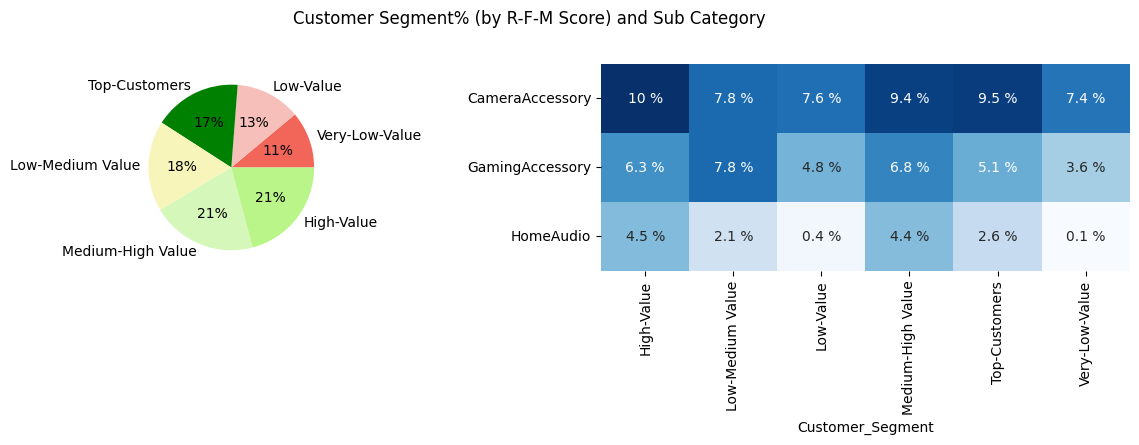

In [101]:
showCustomer_Segments(dfSource)

**Customer Churn Likely basis the Ranking of #Weeks Present witht the Business**

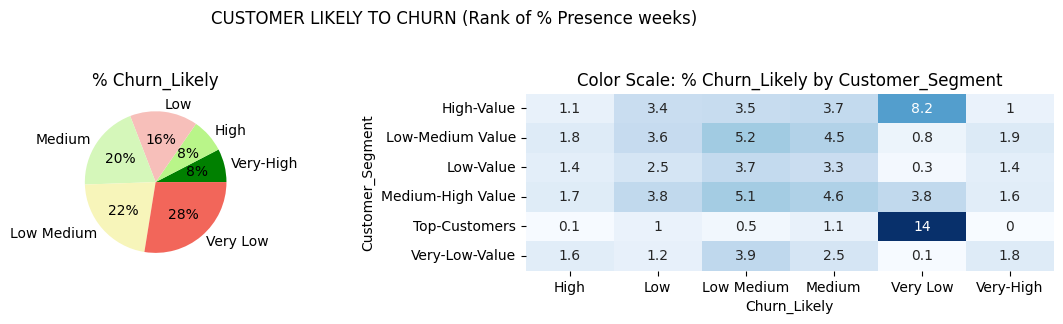

In [105]:
showChurn_Likely(dfSource)


# KMeans Clustering basis the Customer's pincodes

* Calling the Pincode Clusters Related Methods and displaying the Clusters in a Plot
* Customers are split into 7 different clusters basis the KMeans Clustering Algorithm


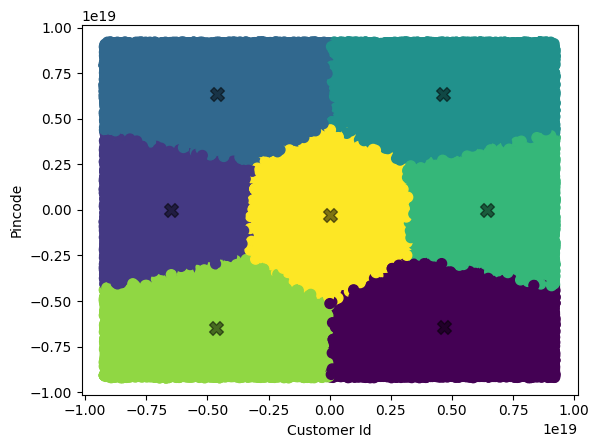

cluster_cust_id  cluster_pincode  pincode_cluster
0     9.082469e+18    -7.824111e+18                0
1     3.911751e+18    -7.843709e+18                0
2     7.991439e+18    -7.593324e+18                0
3     6.995199e+18    -4.274363e+18                0
4     7.931761e+18    -8.747994e+18                0

In [ ]:
def getData_PincodeClustering(dfSource,show=False):
  dfSource["custid"]=dfSource["cust_id"].astype(float)
  dfSource["pincode"]=dfSource["pincode"].astype(float)
  arrPoints=dfSource[["custid","pincode"]].to_numpy()

  # Apply k-means clustering
  kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=10, random_state=42)
  kmeans.fit(arrPoints)
  y_kmeans = kmeans.predict(arrPoints)
  if show==True:
    displayPincodeClusterings(kmeans,arrPoints,y_kmeans)
  return arrPoints,y_kmeans

def getPincodeClusteredData(arrPoints,y_kmeans):
  clusterDictionary = {}
  for index in range(len(arrPoints)):
      if y_kmeans[index] in clusterDictionary:
          clusterDictionary[y_kmeans[index]].append(arrPoints[index])
      else:
          clusterDictionary[y_kmeans[index]]=[arrPoints[index]]
  dictOfClusters=[]
  index=0
  for key,value in clusterDictionary.items():
    dft=pd.DataFrame.from_dict(clusterDictionary[index])
    dft["cluster"]=key
    dictOfClusters.append(dft)
    index=index+1
  dfPincodeClusters=pd.concat(dictOfClusters,axis=0)
  dfPincodeClusters.columns=["cluster_cust_id","cluster_pincode",'pincode_cluster']
  return dfPincodeClusters

def displayPincodeClusterings(kmeans,arrPoints,y_kmeans):
  #Plotting the clusters
  plt.scatter(arrPoints[:, 0], arrPoints[:, 1], c=y_kmeans, s=50, cmap='viridis')

  #Plotting the centroids
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5,marker="X")

  #plt.title('K-Means Clustering')
  plt.xlabel('Customer Id')
  plt.ylabel('Pincode')
  plt.show()

#Calling the Pincode Clusters Related Methods and displaying the Clusters in a Plot
#Customers are split into 7 different clusters basis the KMeans Clustering Algorithm
arrPoints,y_kmeans=getData_PincodeClustering(dfSource,True)
dfPincodeClusters=getPincodeClusteredData(arrPoints,y_kmeans)
dfPincodeClusters.head()




# **Merging Consumer Electronics filtered Data with Other Data Entities**

**getMergedDataEntitiesWithConsumerElectronics()**
*   Defines a Dictionary of other Data Entities how to merge with Consumer Electronics (dfSource)
*   Loops through and apply merging as per the definition
*   **Creates additional columns**:
    1. Holiday:Order (Year+MOnth+Day)==Holiday(Year+Month+Day)
    2. Promotional_Sale:Order (Year+Month+Day)==Sale(Year+Month+Day)
    3. adStock_Invested:Order(Year+Month)==Invst(Year+Month)
    4. NPS:Order(Year+Month)==NPS(Year+Month)
    5. Weather:Order (Year+Month+Day)==Weather(Year+Month+Day)
    6. Pincode_Cluster:by cust_id and pincode




In [ ]:
def getMergedDataEntitiesWithConsumerElectronics(dfSource,dfHolidays,dfSalesCalendar,dfInvestment,dfNPS,dfWeather,dfPincodeClusters):
  #pd.merge(dfSourceAndNPS,dfWeather,how='left',left_on=['Year','Month','order_day'],right_on=["Weather_Year","Weather_Month","Weather_Day"])
  _dictDataMerge=[
    {"Entity":"Holidays","MergeWith":dfHolidays,"how":"left","left_on":["Year","Month","order_day"],"right_on":["Holiday_Year","Holiday_Month","Holiday_Day_Number"]},
    {"Entity":"SalesCalendar","MergeWith":dfSalesCalendar,"how":"left","left_on":["Year","Month","order_day"],"right_on":["Sale_Year","Sale_Month","Sale_Day"]},
    {"Entity":"Investment","MergeWith":dfInvestment,"how":"left","left_on":['Year','Month'],"right_on":["Invst_Year","Invst_Month"]},
    {"Entity":"NPS","MergeWith":dfNPS,"how":"left","left_on":['Year','Month'],"right_on":['NPS_Year','NPS_Month']},
    {"Entity":"Weather","MergeWith":dfWeather,"how":"left","left_on":['Year','Month','order_day'],"right_on":["Weather_Year","Weather_Month","Weather_Day"]},
    {"Entity":"Pincode_Cluster","MergeWith":dfPincodeClusters,"how":"left","left_on":['cust_id','pincode'],"right_on":["cluster_cust_id","cluster_pincode"]},
  ]
  dfSource["cust_id"]=dfSource["cust_id"].astype(float)
  dfSource["pincode"]=dfSource["pincode"].astype(float)
  dfNPS["NPS"]=dfNPS["NPS"].astype(float)

  for _item in _dictDataMerge:
    print("Merging with:",_item["Entity"])
    print("Before Merge",dfSource.shape)
    dfSource=pd.merge(dfSource,_item["MergeWith"],how=_item["how"],left_on=_item["left_on"],right_on=_item["right_on"])
    print("After Merge",dfSource.shape)
  dfSource["Holiday"]=dfSource.apply(lambda x: 1 if x["order_day"]==x["Holiday_Day_Number"] and x["Year"]==x["Holiday_Year"] and x["Month"]==x["Holiday_Month"] else 0,axis=1)
  dfSource["Promotional_Sale_Day"]=dfSource.apply(lambda x: 'Y' if x["order_day"]==x["Sale_Day"] and x["Year"]==x["Sale_Year"] and x["Month"]==x["Sale_Month"] else 'N',axis=1)
  dfSource["adStock_Invested_YearMonth"]=dfSource.apply(lambda x: 'Y' if x["Year"]==x["Invst_Year"] and x["Month"]==x["Invst_Month"] else 'N',axis=1)
  dfSource["NPS_Avlbl_YearMonth"]=dfSource.apply(lambda x: 'Y' if x["Year"]==x["NPS_Year"] and x["Month"]==x["NPS_Month"] else 'N',axis=1)
  dfSource["Weather_Activity_Exists"]=dfSource.apply(lambda x: 'Y' if x["Year"]==x["Weather_Year"] and x["Weather_Month"]==x["Month"] and x["order_day"]==x["Weather_Day"] else 'N',axis=1)
  Invst_cols=['TV', 'Digital', 'Sponsorship','Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio','Other']
  for _col in Invst_cols:
    dfSource[_col]=dfSource[_col]*1.0/dfSource['number_of_weeks']*1.0
  print("All Data Entity Merging process completed")
  dfSource.drop(["cluster_cust_id","cluster_pincode"],axis=1,inplace=True)
  return dfSource

In [ ]:
dfSource=getMergedDataEntitiesWithConsumerElectronics(dfSource,dfHolidays,dfSalesCalendar,dfInvestment,dfNPS,dfWeather,dfPincodeClusters)
dfSource.shape


Merging with: Holidays
Before Merge (112526, 42)
After Merge (112526, 50)
Merging with: SalesCalendar
Before Merge (112526, 50)
After Merge (112526, 55)
Merging with: Investment
Before Merge (112526, 55)
After Merge (112526, 72)
Merging with: NPS
Before Merge (112526, 72)
After Merge (112526, 79)
Merging with: Weather
Before Merge (112526, 79)
After Merge (112526, 94)
Merging with: Pincode_Cluster
Before Merge (112526, 94)
After Merge (143626, 97)
All Data Entity Merging process completed


(143626, 100)

# EDA (Null and Outlier Handling)

**Checking if Null Columns exist and removing**



In [ ]:
dfNullResult=getNullColumns(dfSource,False)
dfNullResult

column_name  null_count  null_percentage           dtype HasOutlier
0         Holiday_Year      140379        97.739267         float64      False
1         Holiday_Date      140379        97.739267  datetime64[ns]      False
2        Holiday_Month      140379        97.739267         float64      False
3   Holiday_Day_Number      140379        97.739267         float64      False
4             Day_Name      140379        97.739267          object      False
5                 Date      140379        97.739267          object      False
6    Holiday_DayOfWeek      140379        97.739267         float64      False
7         Holiday_Week      140379        97.739267          UInt32      False
8            Sale_Year      136390        94.961915         float64      False
9            Sale_Date      136390        94.961915  datetime64[ns]      False
10          Sale_Month      136390        94.961915         float64      False
11            Sale_Day      136390        94.961915         float64      False
12    Sale_Day_Of_Week      136390        94.961915         float64      False
13          Invst_Year         197         0.137162         float64      False
14         Invst_Month         197         0.137162         float64      False
15         Invst_Total         197         0.137162         float64      False
16                  TV         197         0.137162         float64      False
17             Digital         197         0.137162         float64      False
18         Sponsorship         197         0.137162         float64      False
19   Content Marketing         197         0.137162         float64      False
20    Online marketing         197         0.137162         float64      False
21          Affiliates         197         0.137162         float64      False
22                 SEM         197         0.137162         float64      False
23               Radio         197         0.137162         float64      False
24               Other         197         0.137162         float64      False
25    Invst_Total_Next         197         0.137162         float64      False
26          Invst_Drop         197         0.137162         float64      False
27      number_of_days         197         0.137162         float64      False
28     number_of_weeks         197         0.137162         float64      False
29      Invst_Per_Week         197         0.137162         float64      False
30                 NPS         197         0.137162         float64      False
31         Stock Index         197         0.137162          object      False
32            NPS_Year         197         0.137162         float64      False
33      NPS_Month_Name         197         0.137162          object      False
34           NPS_Month         197         0.137162         float64      False
35            NPS_Next         197         0.137162         float64      False
36            NPS_Drop         197         0.137162         float64      False

In [ ]:
dfSource["Holiday"].value_counts(normalize=True)*100.0


Holiday
0    97.739267
1     2.260733
Name: proportion, dtype: float64

In [ ]:
dfSource["Promotional_Sale_Day"].value_counts(normalize=True)*100.0


Promotional_Sale_Day
N    94.961915
Y     5.038085
Name: proportion, dtype: float64

In [ ]:
dfSource["adStock_Invested_YearMonth"].value_counts(normalize=True)*100.0

adStock_Invested_YearMonth
Y    99.862838
N     0.137162
Name: proportion, dtype: float64

In [ ]:
dfSource["NPS_Avlbl_YearMonth"].value_counts(normalize=True)*100.0

NPS_Avlbl_YearMonth
Y    99.862838
N     0.137162
Name: proportion, dtype: float64

In [ ]:
dfSource["Weather_Activity_Exists"].value_counts(normalize=True)*100.0

Weather_Activity_Exists
Y    100.0
Name: proportion, dtype: float64

**Dropping Null Columns**

In [ ]:
dfSource.drop(['Holiday_Year', 'Holiday_Date', 'Holiday_Month',
       'Holiday_Day_Number', 'Day_Name', 'Date', 'Holiday_DayOfWeek',
       'Holiday_Week','Sale_Year', 'Sale_Date', 'Sale_Month', 'Sale_Day',
       'Sale_Day_Of_Week','Invst_Year', 'Invst_Month','Invst_Total_Next','NPS_Year',
       'NPS_Month_Name', 'NPS_Month', 'NPS_Next','Weather_Year',"Weather_Year","Weather_Month","Weather_Day"],axis=1,inplace=True,errors='ignore')


In [ ]:
dfNullResult=getNullColumns(dfSource)
dfNullResult

column_name  null_count  null_percentage    dtype HasOutlier
0         Invst_Total         197         0.137162  float64      False
1                  TV         197         0.137162  float64      False
2             Digital         197         0.137162  float64      False
3         Sponsorship         197         0.137162  float64      False
4   Content Marketing         197         0.137162  float64      False
5    Online marketing         197         0.137162  float64      False
6          Affiliates         197         0.137162  float64      False
7                 SEM         197         0.137162  float64      False
8               Radio         197         0.137162  float64      False
9               Other         197         0.137162  float64      False
10         Invst_Drop         197         0.137162  float64      False
11     number_of_days         197         0.137162  float64      False
12    number_of_weeks         197         0.137162  float64      False
13     Invst_Per_Week         197         0.137162  float64      False
14                NPS         197         0.137162  float64      False
15        Stock Index         197         0.137162   object      False
16           NPS_Drop         197         0.137162  float64      False

**Checking and Handling Outliers**

In [ ]:
numeric_columns_dfSource=getColumnsByType(dfSource,'Numeric')
#numeric_columns_dfSource

**removeOutlier_* methods**:<br>
Has Rules to remove Outliers from each type columns basis the outlier value

In [ ]:
def removeOutlier_DeliveryDays(dfSource):
  dfSource=dfSource[dfSource["deliverybdays"]>=0]
  dfSource=dfSource[dfSource["deliverybdays"]<120]
  dfSource=dfSource[dfSource["deliverycdays"]>=0]
  dfSource=dfSource[dfSource["deliverycdays"]<125]
  return dfSource



In [ ]:
def removeOutlier_GMV(dfSource):
  dfSource=dfSource[dfSource["gmv"]<=50000]
  return dfSource

In [ ]:
def removeOutlier_product_mrp(dfSource):
  dfSource=dfSource[dfSource["product_mrp"]<=60000]
  return dfSource

In [ ]:
def removeOutlier_sla(dfSource):
  dfSource=dfSource[dfSource["sla"]<=30]
  return dfSource


In [ ]:
def removeOutlier_product_procurement_sla(dfSource):
  dfSource=dfSource[dfSource["product_procurement_sla"]>0]
  dfSource=dfSource[dfSource["product_procurement_sla"]<=30]
  return dfSource




In [ ]:
def removeOutlier_WeatherColumns(dfWeather):
  dfWeather=dfWeather[dfWeather["Total_Rain__mm"]<=30]
  dfWeather=dfWeather[dfWeather["Total_Precip__mm"]<=30]
  dfWeather=dfWeather[dfWeather["Total_Snow__cm"]<dfWeather["Total_Snow__cm"].max()]
  return dfWeather


In [ ]:
def removeOutlier_units(dfSource):
  dfSource=dfSource[dfSource["units"]>0]
  return dfSource


**removeOutlierAndShowBoxPlots method to dynamically Draw Box plots Before and After Outlier Removal**

In [ ]:
def removeOutlierAndShowBoxPlots(dfSource,_columnNames,_OutlierRemoval_Function_Name,_title):
  _nrows=len(_columnNames)
  _ncols=2
  fig,axs=plt.subplots(nrows=_nrows,ncols=_ncols,figsize=(12,3),edgecolor="black",linewidth=2)
  _rowIndex=0
  _plotTitle="Removal"
  for _columnName in _columnNames:
    for _colIndex in range(_ncols):
      _currentAxis=None
      if len(_columnNames)>1:
        _currentAxis=axs[_rowIndex,_colIndex]
      else:
        _currentAxis=axs[_colIndex]
      dfSource.boxplot(ax=_currentAxis,column=_columnName,vert=False)
      _currentAxis.get_yaxis().set_ticks([])
      if _colIndex==0:
        _currentAxis.set_title(_columnName+":Before "+_plotTitle)
        dfSource=globals()[_OutlierRemoval_Function_Name](dfSource)
      if _colIndex==1:
        _currentAxis.set_title(_columnName+":After "+_plotTitle)
      for spine in _currentAxis.spines.values():
        spine.set_edgecolor('green')
    _rowIndex=_rowIndex+1
  plt.tight_layout()
  plt.suptitle("Outlier Removals=["+_title+"]")
  plt.subplots_adjust(top=0.8)
  plt.show()

**Definition of list of columns for which Outlier Handling is needed**

In [ ]:
_dictRemoveOutlierDefinition=[
    {"data":dfSource,"column_names":["deliverybdays","deliverycdays"],"function_name":"removeOutlier_DeliveryDays","title":"delivery bdays , cdays"},
    {"data":dfSource,"column_names":["gmv"],"function_name":"removeOutlier_GMV","title":"GMV"},
    {"data":dfSource,"column_names":["product_mrp"],"function_name":"removeOutlier_product_mrp","title":"product_mrp"},
    {"data":dfSource,"column_names":["sla"],"function_name":"removeOutlier_sla","title":"sla"},
    {"data":dfSource,"column_names":["product_procurement_sla"],"function_name":"removeOutlier_product_procurement_sla","title":"product_procurement_sla"},
    {"data":dfSource,"column_names":["units"],"function_name":"removeOutlier_units","title":"units"},
    {"data":dfWeather,"column_names":["Total_Rain__mm","Total_Precip__mm","Total_Snow__cm"],"function_name":"removeOutlier_WeatherColumns","title":"Weather Data"},


]

**Looping through the definition of Outliers and dynamicall removing Outliers. Box plots displayed Before and After Outlier Removal for each definition in the dictionary. This is done to reduce to have one consolidated view to check if all columns that needs outlier handling is being done or not**

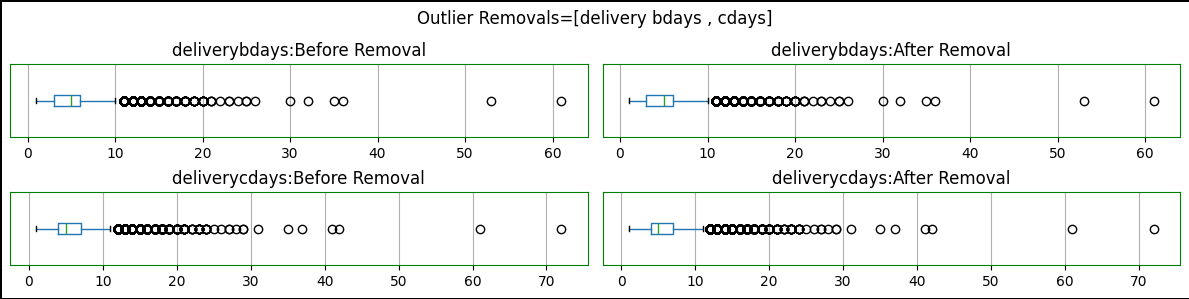

----------------------------------------------------------------------------------------------------------------------------------


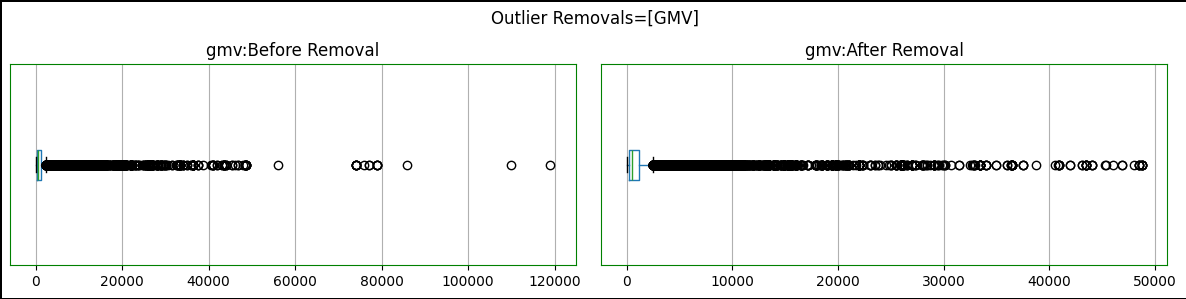

----------------------------------------------------------------------------------------------------------------------------------


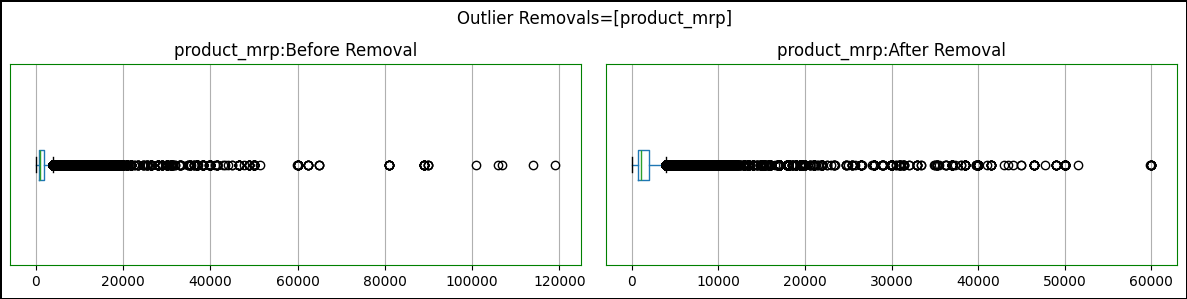

----------------------------------------------------------------------------------------------------------------------------------


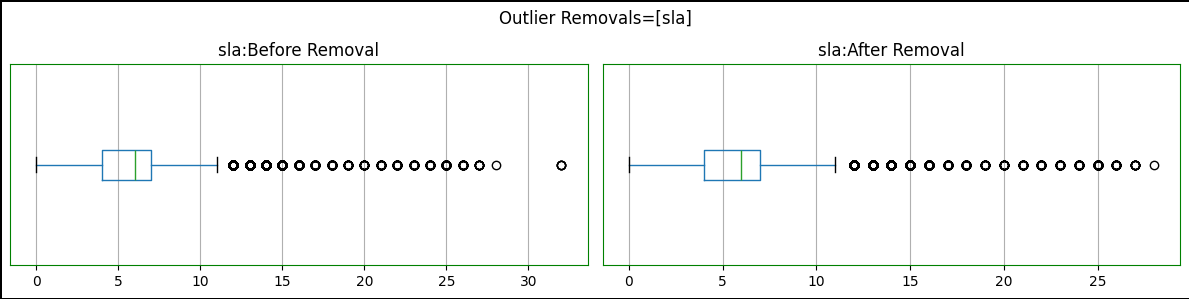

----------------------------------------------------------------------------------------------------------------------------------


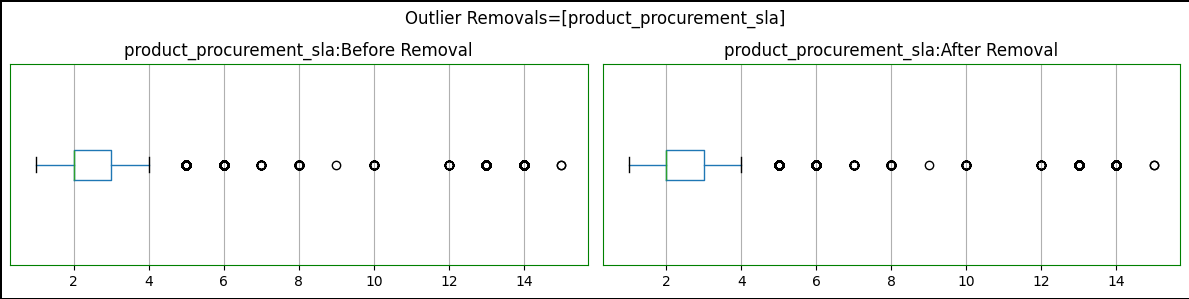

----------------------------------------------------------------------------------------------------------------------------------


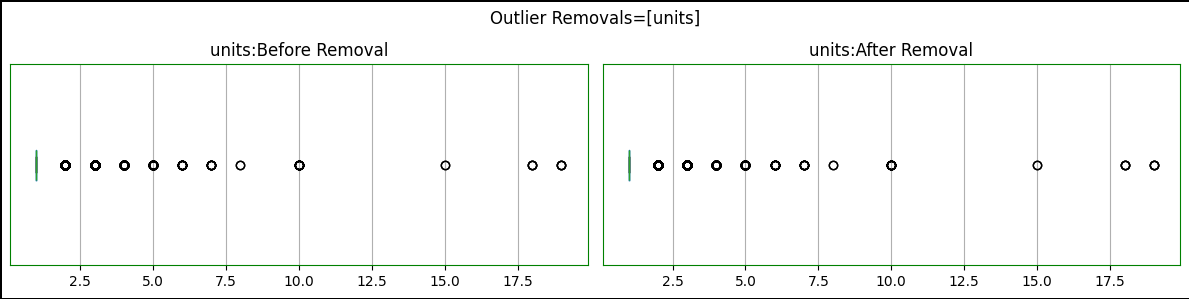

----------------------------------------------------------------------------------------------------------------------------------


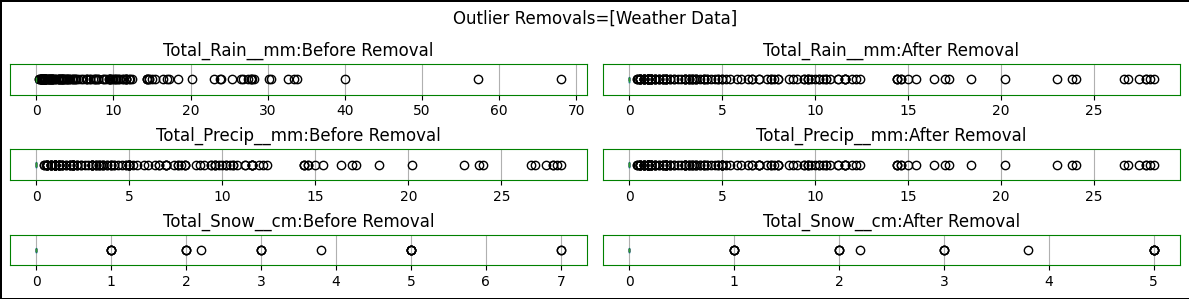

----------------------------------------------------------------------------------------------------------------------------------


In [ ]:
for _item in _dictRemoveOutlierDefinition:
  removeOutlierAndShowBoxPlots(_item["data"],_item["column_names"],_item["function_name"],_item["title"])
  print("-"*130)

In [ ]:
dfSource_CameraAccessory=dfSource[dfSource["product_analytic_sub_category"]=='CameraAccessory']
dfSource_GamingAccessory=dfSource[dfSource["product_analytic_sub_category"]=='GamingAccessory']
dfSource_HomeAudio=dfSource[dfSource["product_analytic_sub_category"]=='HomeAudio']


# **Correlations**

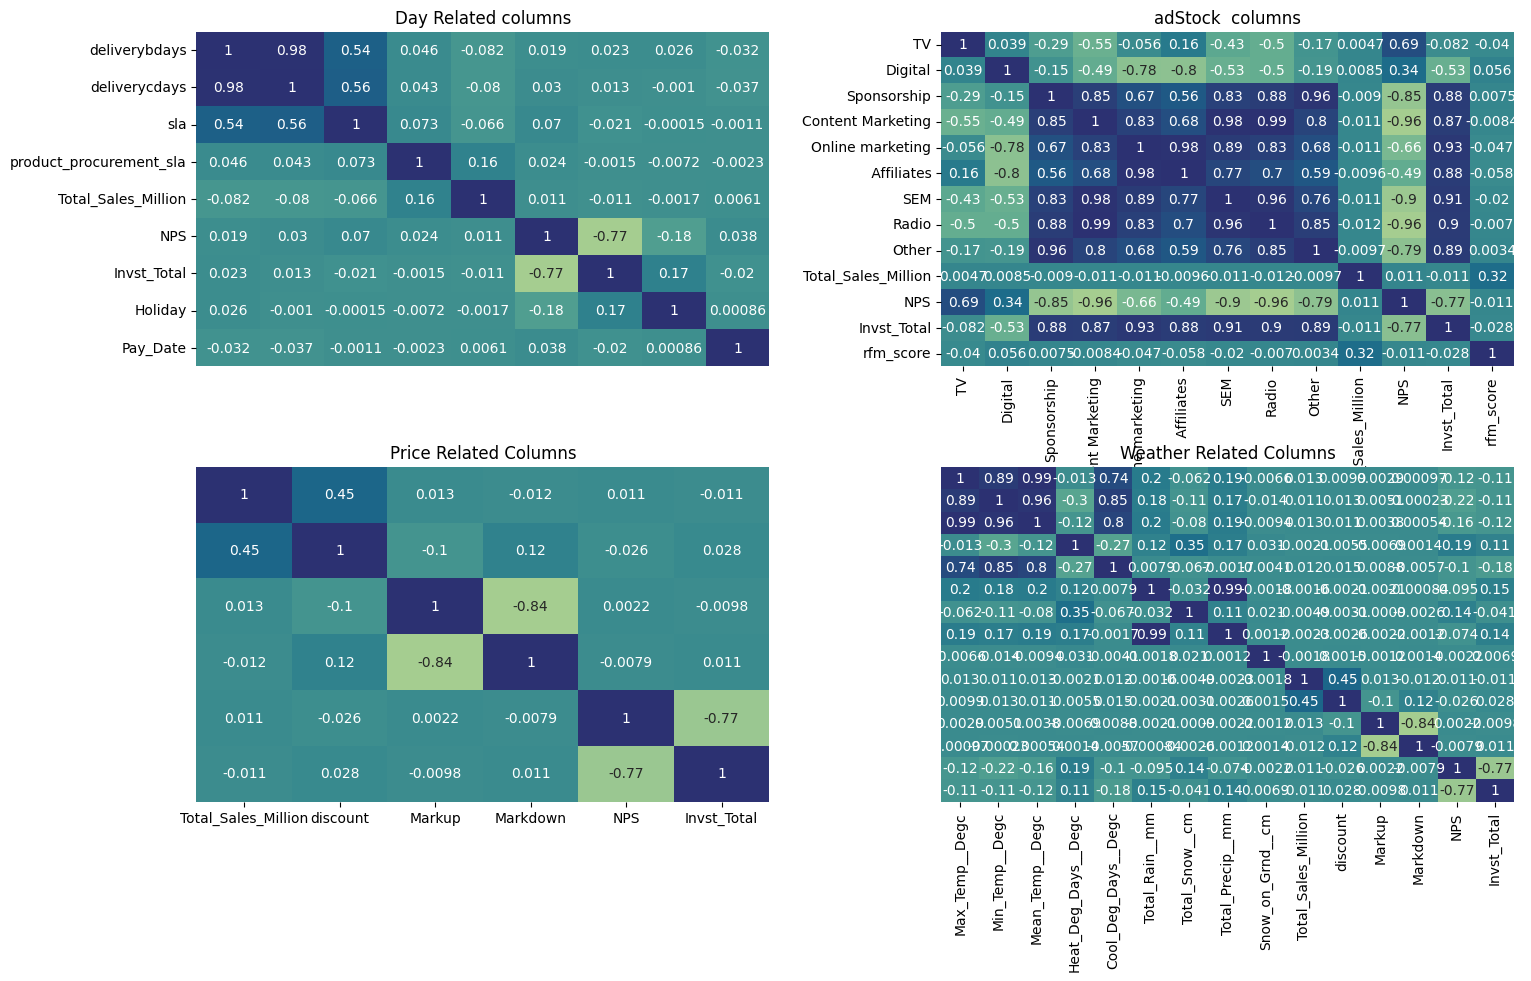

In [111]:
def showCorrelationMatrices(dfSource):
  numeric_group_days=['deliverybdays', 'deliverycdays','sla','product_procurement_sla','Total_Sales_Million','NPS','Invst_Total','Holiday','Pay_Date']
  numeric_group_adStock=['TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other','Total_Sales_Million','NPS','Invst_Total','rfm_score']
  numeric_price_related_columns=[ 'Total_Sales_Million', 'discount', 'Markup', 'Markdown','NPS','Invst_Total' ]
  numeric_weather_relatedcolumns=['Max_Temp__Degc', 'Min_Temp__Degc', 'Mean_Temp__Degc', 'Heat_Deg_Days__Degc', 'Cool_Deg_Days__Degc', 'Total_Rain__mm', 'Total_Snow__cm', 'Total_Precip__mm',
  'Snow_on_Grnd__cm','Total_Sales_Million', 'discount', 'Markup', 'Markdown','NPS','Invst_Total']
  fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(17,10))
  sns.heatmap(dfSource[numeric_group_days].corr(),annot=True,cmap='crest',ax=axs[0,0],cbar=False,xticklabels=False)
  sns.heatmap(dfSource[numeric_group_adStock].corr(),annot=True,cmap='crest',ax=axs[0,1],cbar=False)
  sns.heatmap(dfSource[numeric_price_related_columns].corr(),annot=True,cmap='crest',ax=axs[1,0],cbar=False,yticklabels=False)
  sns.heatmap(dfSource[numeric_weather_relatedcolumns].corr(),annot=True,cmap='crest', ax=axs[1,1],cbar=False,yticklabels=False)
  axs[0,0].set_title('Day Related columns')
  axs[0,1].set_title('adStock  columns')
  axs[1,0].set_title('Price Related Columns')
  axs[1,1].set_title('Weather Related Columns')

  plt.subplots_adjust(wspace=0.3,hspace=0.3)

showCorrelationMatrices(dfSource)

**Factors +vely/-vely Correlated with Total_Sales**

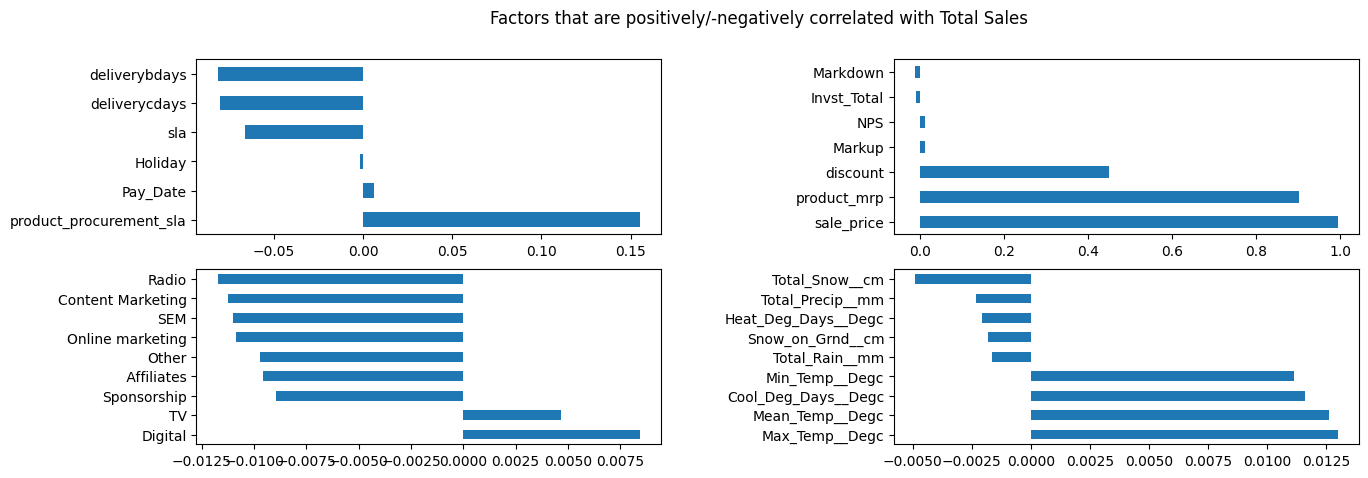

In [ ]:
def showFactorsCorrelatedWithTotalSales(dfSource):
  numeric_columns=getColumnsByType(dfSource,'numeric')
  numeric_columns=getColumnsByType(dfSource,'numeric')
  dfCorr=dfSource[numeric_columns].corr()
  dfCorr["Attributes"]=dfCorr.index

  numeric_group_days=['deliverybdays', 'deliverycdays','sla','product_procurement_sla','Holiday','Pay_Date']
  numeric_group_adStock=['TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']
  numeric_price_related_columns=[ 'discount', 'Markup', 'Markdown','NPS','Invst_Total' ,'product_mrp','sale_price']
  numeric_weather_relatedcolumns=['Max_Temp__Degc', 'Min_Temp__Degc', 'Mean_Temp__Degc', 'Heat_Deg_Days__Degc', 'Cool_Deg_Days__Degc', 'Total_Rain__mm', 'Total_Snow__cm', 'Total_Precip__mm', 'Snow_on_Grnd__cm']

  fig, axs = plt.subplots(figsize=(15,5),nrows=2,ncols=2)
  dfCorr_days=dfCorr[dfCorr["Attributes"].isin(numeric_group_days)]
  dfCorr_days["Total_Sales"].sort_values(ascending=False).plot.barh(ax=axs[0,0])
  dfCorr_price=dfCorr[dfCorr["Attributes"].isin(numeric_price_related_columns)]
  dfCorr_price["Total_Sales"].sort_values(ascending=False).plot.barh(ax=axs[0,1])
  dfCorr_adStock=dfCorr[dfCorr["Attributes"].isin(numeric_group_adStock)]
  dfCorr_adStock["Total_Sales"].sort_values(ascending=False).plot.barh(ax=axs[1,0])
  dfCorr_weather=dfCorr[dfCorr["Attributes"].isin(numeric_weather_relatedcolumns)]
  dfCorr_weather["Total_Sales"].sort_values(ascending=False).plot.barh(ax=axs[1,1])
  plt.suptitle("Factors that are positively/-negatively correlated with Total Sales")
  plt.subplots_adjust(wspace=0.5)
  plt.show()
showFactorsCorrelatedWithTotalSales(dfSource)

# Weather Data Correlations

In [ ]:
def getWeatherCorrelations(dfSource,category,correlated_metric):
  Temp_ColumnList=[correlated_metric,'Max_Temp__Degc', 'Min_Temp__Degc','Mean_Temp__Degc']
  DegDays_ColumnList=[correlated_metric,'Heat_Deg_Days__Degc','Cool_Deg_Days__Degc']
  Rain_ColumnList=[correlated_metric,'Total_Rain__mm']
  Snow_ColumnList=[correlated_metric,'Total_Snow__cm','Snow_on_Grnd__cm']
  Precip_ColumnList=[correlated_metric,'Total_Precip__mm']
  listOfTypeCols=[Temp_ColumnList,DegDays_ColumnList,Rain_ColumnList,Snow_ColumnList,Precip_ColumnList]
  _listOfDf=[]
  for _typeofcols in listOfTypeCols:
    dfTemp=dfSource[_typeofcols].corr()
    dfTemp=dfTemp.iloc[0:1]
    _listOfDf.append(dfTemp)
  df_Weather=pd.concat(_listOfDf,axis=1)
  df_Weather=df_Weather.reset_index()
  df_Weather["index"]=category
  df_Weather=df_Weather.T
  df_Weather.columns=df_Weather.iloc[0]
  df_Weather=df_Weather.iloc[1:]
  df_Weather=df_Weather.reset_index()
  df_Weather.rename(columns={'index':'Weather_Columns'},inplace=True)
  return df_Weather

In [ ]:
  def getData_WeatherCorrelations(correlated_metric):
    dfWeather_CA=getWeatherCorrelations(dfSource_CameraAccessory,'CameraAccessory',correlated_metric)
    dfWeather_GA=getWeatherCorrelations(dfSource_GamingAccessory,'GamingAccessory',correlated_metric)
    dfWeather_HA=getWeatherCorrelations(dfSource_HomeAudio,'HomeAudio',correlated_metric)
    dfWeather_CA=dfWeather_CA[dfWeather_CA['Weather_Columns']!=correlated_metric]
    dfWeather_GA=dfWeather_GA[dfWeather_GA['Weather_Columns']!=correlated_metric]
    dfWeather_GA.drop(['Weather_Columns'],axis=1,inplace=True)
    dfWeather_HA=dfWeather_HA[dfWeather_HA['Weather_Columns']!=correlated_metric]
    dfWeather_HA.drop(['Weather_Columns'],axis=1,inplace=True)
    dfWeather_Correlations=pd.concat([dfWeather_CA,dfWeather_GA,dfWeather_HA],axis=1)
    dfWeather_Correlations=dfWeather_Correlations.reset_index(drop=True)
    dfWeather_Correlations["CameraAccessory"]=dfWeather_Correlations["CameraAccessory"].astype(float)
    dfWeather_Correlations["GamingAccessory"]=dfWeather_Correlations["GamingAccessory"].astype(float)
    dfWeather_Correlations["HomeAudio"]=dfWeather_Correlations["HomeAudio"].astype(float)
    return dfWeather_Correlations


getData_WeatherCorrelations('Total_Sales')


index      Weather_Columns  CameraAccessory  GamingAccessory  HomeAudio
0           Max_Temp__Degc         0.020954        -0.003144   0.014473
1           Min_Temp__Degc         0.016543        -0.001854   0.019477
2          Mean_Temp__Degc         0.019861        -0.002712   0.016664
3      Heat_Deg_Days__Degc        -0.002568         0.004933  -0.023737
4      Cool_Deg_Days__Degc         0.013098         0.008629   0.016926
5           Total_Rain__mm         0.002903        -0.010501  -0.019073
6           Total_Snow__cm        -0.006114         0.002647  -0.008955
7         Snow_on_Grnd__cm        -0.001128        -0.004420   0.001185
8         Total_Precip__mm         0.001943        -0.010072  -0.020173

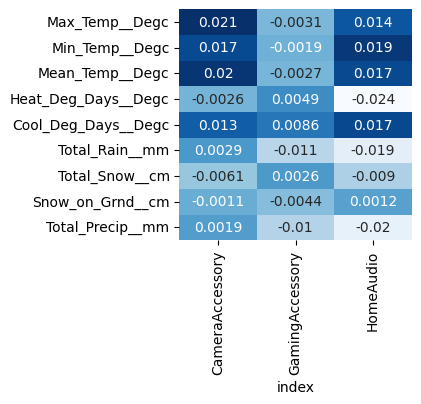

In [112]:
def ShowWeatherDataCorrelations():
  correlated_metric='Total_Sales'
  dfWeather_Correlations=getData_WeatherCorrelations(correlated_metric)
  num_cols=getColumnsByType(dfWeather_Correlations,'numeric')
  fig,axs=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
  sns.heatmap(dfWeather_Correlations[num_cols],annot=True,cmap='Blues',cbar=False,yticklabels=dfWeather_Correlations["Weather_Columns"])
ShowWeatherDataCorrelations()

# KPIs

**KPI Related Methods**

In [108]:
def showKPI_CustomerSegmentvsTotalSales(dfSource):
  dfgc_sub_cat=dfSource.groupby(["product_analytic_sub_category","Customer_Segment"])["Total_Sales_Million"].sum().reset_index()
  dfgc_sub_cat=dfgc_sub_cat.sort_values(by=["product_analytic_sub_category","Total_Sales_Million"],ascending=[True,False])
  sns.barplot(data=dfgc_sub_cat,x="product_analytic_sub_category",y="Total_Sales_Million",hue="Customer_Segment")
def showKPI_SalesByPincodeCluster(dfSource):
  dfgc_sub_cat=dfSource.groupby(["product_analytic_sub_category","pincode_cluster"])["Total_Sales_Million"].sum().reset_index()
  dfgc_sub_cat=dfgc_sub_cat.sort_values(by=["pincode_cluster","Total_Sales_Million"],ascending=[True,False])
  sns.barplot(data=dfgc_sub_cat,x="product_analytic_sub_category",y="Total_Sales_Million",hue="pincode_cluster")

def showKPI_NewCustomerOnBoardTrendByYears(dfSource):
  dfgc_newcustomerstrend=dfSource.groupby(["cust_id"])[["Year","Month"]].agg({"Year":"min","Month":"min"}).reset_index()
  #
  dfgc_newcustomerstrend=pd.pivot_table(dfgc_newcustomerstrend,index=["Year"],values=["cust_id"],columns=["Month"],aggfunc="count")
  dfgc_newcustomerstrend=dfgc_newcustomerstrend.reset_index()
  dfgc_newcustomerstrend.fillna(0,inplace=True)
  dfgc_newcustomerstrend=dfgc_newcustomerstrend.reset_index()
  dfgc_newcustomerstrend=dfgc_newcustomerstrend.transpose().reset_index()
  dfgc_newcustomerstrend=dfgc_newcustomerstrend.iloc[2:]
  dfgc_newcustomerstrend.drop(["level_0"],axis=1,inplace=True)
  dfgc_newcustomerstrend.columns=["Month","2015","2016"]
  #dfgc_newcustomerstrend=dfgc_newcustomerstrend.reset_index()
  fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
  dfgc_newcustomerstrend[["2015"]].plot.bar(ax=axs[0])
  axs[0].set_xlabel("#Customers First Order Month")
  axs[1].set_xlabel("#Customers First Order Month")

  dfgc_newcustomerstrend[["2016"]].plot.bar(ax=axs[1])
  plt.suptitle("New Customer Onboard Trend 2015 vs 2016")

def showKPI_PincodeClusters(dfSource):
  dfSource["Total_Sales_Million"]=dfSource["Total_Sales"]/1000000
  dfClusterInfo=dfSource.groupby(["Customer_Segment","pincode_cluster"]).agg({"cust_id":"count","Total_Sales_Million":"sum"}).reset_index()
  dfClusterInfo_pivot=pd.pivot_table(data=dfClusterInfo,index=["pincode_cluster"],columns=["Customer_Segment"],values=["Total_Sales_Million"],aggfunc="sum").reset_index()
  dfClusterInfo_pivot.columns
  _colLIst=[]
  for _col in dfClusterInfo_pivot.columns:
    if str(_col[1])!='':
      _colLIst.append(str(_col[1]))
    else:
      _colLIst.append(_col[0])

  dfClusterInfo_pivot.columns=_colLIst
  fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(20,10))
  dfPincodeClusterDistrib=(dfSource["pincode_cluster"].value_counts(normalize=True)*100.0).reset_index()
  colours = {0: '#f2665a',
            1: '#f7bfba',
            2: '#f7f5ba',
            3: '#d5f7ba',
            4: '#b9f589',
            5:'green',
            6:'blue'
            }
  _labels=dfPincodeClusterDistrib["pincode_cluster"]
  axs[0,0].pie(dfPincodeClusterDistrib["proportion"],
          labels=_labels,
          colors=[colours[key] for key in _labels],
          autopct='%.0f%%')
  axs[0,0].set_title('#distribution of Pincode clusters')
  #This is not correlation but color scale to show pincode cluster and which customer segment attracts more business
  dfClusterInfo_pivot.drop(['pincode_cluster'],axis=1,inplace=True)
  sns.heatmap(dfClusterInfo_pivot.T,annot=True,cmap='Blues',cbar=False,ax=axs[0,1])
  axs[0,1].set_title('Color Scale: Total Sales(Million) by Pincode cluster Vs Customer segment')


  dfProduct_Procurement=pd.pivot_table(dfSource,index=["product_procurement_sla"],columns="pincode_cluster",values="order_id",fill_value=0,aggfunc='count')
  dfProduct_Procurement=dfProduct_Procurement.reset_index()
  #dfProduct_Procurement.rename(columns={"product_procurement_sla":"ppsla"},inplace=True)
  dfppslaLessthan6=dfProduct_Procurement[dfProduct_Procurement["product_procurement_sla"]<=5]
  dfppsla6AndAbove=dfProduct_Procurement[dfProduct_Procurement["product_procurement_sla"]>6]

  dfppslaLessthan6.drop(["product_procurement_sla"],axis=1,inplace=True)
  dfppsla6AndAbove.drop(["product_procurement_sla"],axis=1,inplace=True)

  dfsla=pd.pivot_table(dfSource,index=["sla"],columns="pincode_cluster",values="order_id",fill_value=0,aggfunc='count')
  dfsla=dfsla.reset_index()
  dfsla12AndLesser=dfsla[dfsla["sla"]<=12]
  dfslaGreaterThan12=dfsla[dfsla["sla"]>12]
  dfsla12AndLesser.drop(['sla'],axis=1,inplace=True)
  dfslaGreaterThan12.drop(['sla'],axis=1,inplace=True)


  sns.heatmap(dfppslaLessthan6,annot=True,ax=axs[1,0],cmap='crest',cbar=False)
  sns.heatmap(dfppsla6AndAbove,annot=True,ax=axs[1,1],cmap='crest',cbar=False)
  sns.heatmap(dfsla12AndLesser,annot=True,ax=axs[2,0],cmap='crest',cbar=False)
  sns.heatmap(dfslaGreaterThan12,annot=True,ax=axs[2,1],cmap='crest',cbar=False)


  axs[0,1].set_ylabel("customer_segments")
  axs[1,0].set_ylabel("product_procurement_sla<=5")
  axs[1,1].set_ylabel("product_procurement_sla>5")
  axs[2,0].set_ylabel("sla<=12")
  axs[2,1].set_ylabel("sla>12")

  axs[1,0].sharex(axs[2,0])

def showKPI_DormantCustomers(dfSource):
  #dfSource[]["Customer_Segment"]
  dfgc_dormant=dfSource.groupby(["Customer_Segment","product_analytic_sub_category","cust_id"])[["order_id"]].agg({"order_id":"count"}).reset_index()
  dfgc_dormant.rename(columns={"order_id":"#Orders"},inplace=True)
  dfgc_dormant=dfgc_dormant[dfgc_dormant["#Orders"]==1].groupby(["Customer_Segment","product_analytic_sub_category"])["cust_id"].count().reset_index()
  dfgc_dormant.rename(columns={"cust_id":"#dormant_customers"},inplace=True)
  dfgc_dormant=pd.crosstab(index=dfgc_dormant["product_analytic_sub_category"],columns=dfgc_dormant["Customer_Segment"],values=dfgc_dormant["#dormant_customers"],aggfunc="sum",normalize="columns")*100.0
  dfgc_dormant=dfgc_dormant.reset_index().transpose().reset_index()
  dfgc_dormant
  #dfgc_dormant=dfgc_dormant.sort_values(by="#dormant_customers",ascending=False)
  dfgc_dormant.columns=dfgc_dormant.iloc[0]
  dfgc_dormant=dfgc_dormant.iloc[1:]
  dfgc_dormant[["CameraAccessory","GamingAccessory","HomeAudio"]]=dfgc_dormant[["CameraAccessory","GamingAccessory","HomeAudio"]].astype(float)
  #list(dfgc_dormant["Customer_Segment"].unique)
  fig, ax1 = plt.subplots(figsize=(4,3))
  sns.heatmap(data=dfgc_dormant[["CameraAccessory","GamingAccessory","HomeAudio"]],annot=True,cmap='Blues',ax=ax1,cbar=False,yticklabels=list(dfgc_dormant["product_analytic_sub_category"].unique()))
  ax1.set_ylabel('Customer_Segment')
  ax1.set_xlabel('Sub Category')
  for t in ax1.texts: t.set_text(t.get_text() + " %")

  plt.suptitle("%Dormant Customers by Segment vs Sub Category")

  plt.show()

def checkCustomerPincodeClusterDistribution(dfSource):
  dfcust_pincode=dfSource.groupby(["cust_id"])[["pincode_cluster","pincode"]].count().reset_index()
  dfcust_pincode=dfcust_pincode.sort_values(by=["cust_id"])
  print("#Customers with Same Cluster Same pincode",len(dfcust_pincode[(dfcust_pincode["pincode_cluster"]==1)&(dfcust_pincode["pincode"]==1)]))
  print("#Customers with Same Cluster Differents pincode",len(dfcust_pincode[(dfcust_pincode["pincode_cluster"]==1)&(dfcust_pincode["pincode"]>1)]))
  print("#Customers with Differnt Cluster Differents pincode",len(dfcust_pincode[(dfcust_pincode["pincode_cluster"]>1)&(dfcust_pincode["pincode"]>1)]))
  custid_same=list(dfcust_pincode[(dfcust_pincode["pincode_cluster"]==1)&(dfcust_pincode["pincode"]==1)]["cust_id"])
  custid_different=list(dfcust_pincode[(dfcust_pincode["pincode_cluster"]>1)&(dfcust_pincode["pincode"]>1)]["cust_id"])

  print(dfSource[dfSource["cust_id"].isin(custid_same)]["pincode_cluster"].value_counts().reset_index()["count"].sum())
  print(dfSource[dfSource["cust_id"].isin(custid_same)]["pincode_cluster"].value_counts().reset_index()["count"].sum())

#dfcust_pincode.drop_duplicates(keep='first',inplace=True)
def showKPI_CustomerSegmentVsMarkupDown(dfSource):
  fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,3),edgecolor="black",linewidth=2)
  #sns.barplot(y=)
  sns.barplot(y = 'Total_Sales',data = dfSource, x = 'Customer_Segment',hue='Markup',ax=axs[0])
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
  sns.barplot(y = 'Total_Sales',data = dfSource, x = 'Customer_Segment',hue='Markdown',ax=axs[1])
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

def showKPI_ProductAnalyticVertical(dfSource):
  colList=['CameraAccessory','GamingAccessory','HomeAudio']
  fig,axs=plt.subplots(nrows=3,ncols=1,figsize=(10,15))
  for i in range(len(colList)):
    subcategory_Name=colList[i]
    prodassort=pd.pivot_table(dfSource[dfSource["product_analytic_sub_category"]==subcategory_Name],index='product_analytic_sub_category',columns=['product_analytic_vertical'],values='fsn_id',aggfunc=lambda x: len(x.unique())).reset_index().transpose()
    prodassort.fillna(0,inplace=True)
    prodassort=prodassort.reset_index()
    prodassort.columns=prodassort.iloc[0]
    prodassort=prodassort.iloc[1:]
    prodassort=prodassort.sort_values(by=[subcategory_Name],ascending=[False])
    ax1=axs[i]
    prodassort.plot.barh(ax=ax1,legend=False)
    ax1.set_yticklabels(prodassort["product_analytic_sub_category"].unique())
    ax1.set_ylabel("#Product Vertical Names")
    ax1.set_xlabel("#Products")
    ax1.annotate("Product Vertical:"+subcategory_Name, xy=(200, len(prodassort["product_analytic_sub_category"].unique())/2))

def showKPI_TotalSalesDashboard(dfSource):
  hueColumnsDict=[

      {"y":"Total_Sales_Million","x":"Customer_Segment","hue":'product_analytic_sub_category'},
      {"y":"Total_Sales_Million","x":"Churn_Likely","hue":'Customer_Segment'},
      {"y":"Total_Sales_Million","x":"pincode_cluster","hue":'Customer_Segment'},

      {"y":"Total_Sales_Million","x":"Customer_Segment","hue":'order_payment_type'},
      {"y":"Total_Sales_Million","x":"product_analytic_sub_category","hue":'Churn_Likely'},
      {"y":"Total_Sales_Million","x":"sla","hue":'Customer_Segment'}, #,

      {"y":"Total_Sales_Million","x":"product_analytic_sub_category","hue":'Promotional_Sale_Day'},
      {"y":"Total_Sales_Million","x":"product_analytic_sub_category","hue":'Pay_Date'},
      {"y":"Total_Sales_Million","x":"product_analytic_sub_category","hue":'Markdown'},

      {"y":"Total_Sales_Million","x":"product_analytic_sub_category","hue":'Markup'},
      {"y":"Total_Sales_Million","x":"product_analytic_sub_category","hue":'NPS_Avlbl_YearMonth'},
      {"y":"Total_Sales_Million","x":"product_analytic_sub_category","hue":'adStock_Invested_YearMonth'}

  ]

  _ncols=3
  _nrows=round(len(hueColumnsDict)/_ncols)
  print(_nrows,_ncols)
  fig,axs=plt.subplots(nrows=_nrows,ncols=_ncols,figsize=(25,20),edgecolor="black",linewidth=2)
  hueIndex=0
  for rowIndex in range(_nrows):
    for colIndex in range(_ncols):
      _y=hueColumnsDict[hueIndex]["y"]
      _x=hueColumnsDict[hueIndex]["x"]
      _hue=hueColumnsDict[hueIndex]["hue"]
      _ax=axs[rowIndex,colIndex]
      _data=dfSource.groupby([_x,_hue])[_y].sum().reset_index()
      _data=_data.sort_values(by=[_y],ascending=[False])
      if _hue!="":
        sns.barplot(data=_data,x=_x,y=_y,hue=_hue,ax=_ax)
      else:
        print("hue empty")
        sns.barplot(data=_data,x=_x,y=_y,ax=_ax)
      #sns.barplot(y = _y,data = dfSource, x = _x,hue=_hue,ax=_ax)
      _ax.tick_params(axis='x', labelrotation=45)
      hueIndex=hueIndex+1
  plt.subplots_adjust(hspace=0.5)
  plt.tight_layout()

def showKPI_TotalSalesnOrderBySla(dfSource,slaColumn):
  dfSlaDistrib=dfSource.groupby([slaColumn,"Year"]).agg({"Total_Sales_Million":"sum","order_id":"count"}).reset_index()
  dfSlaDistrib.rename(columns={"order_id":"order_count"},inplace=True)

  #dfSlaDistrib[slaColumn]=dfSlaDistrib.index
  #print(dfSlaDistrib)
  fig, ax1 = plt.subplots(figsize=(10, 3))
  sns.barplot(x=slaColumn,data=dfSlaDistrib,y="Total_Sales_Million",ax=ax1)
  ax1.set_ylabel('Total_Sales_Million')
  ax2 = ax1.twinx()
  sns.lineplot(x=slaColumn,data=dfSlaDistrib,y="order_count",ax=ax2,color="orange")
  ax2.set_ylabel('order_count')
  plt.title='Total_Sales (in million) and #Orders by '+slaColumn
  plt.grid(False)
  plt.show()

def showKPI_NPSDashboard(dfSource):
#subcategory_filterlist
  dfNPSGroup=dfSource[dfSource["product_analytic_sub_category"].isin(subcategory_filterlist)][["product_analytic_sub_category","Year","Month","Total_Sales_Million","NPS","Invst_Total"]]
  dfNPSGroup=dfNPSGroup.groupby(["product_analytic_sub_category","Year","Month"])[["Total_Sales_Million","NPS","Invst_Total"]].sum().reset_index()
  dfNPSGroup["NPS"]=dfNPSGroup["NPS"]/1000000
  dfNPSGroup["Invst_Total"]=dfNPSGroup["Invst_Total"]/1000000
  dfNPSGroup=dfNPSGroup.sort_values(by=["Year","Month","product_analytic_sub_category"],ascending=[True,True,True]).reset_index()
  fig,axs=plt.subplots(nrows=2,ncols=3,figsize=(25,8),edgecolor="black",linewidth=2)
  rowindex=0

  dfNPSGroup_15=dfNPSGroup[dfNPSGroup["Year"]==2015]
  dfNPSGroup_16=dfNPSGroup[dfNPSGroup["Year"]==2016]

  ax1=axs[0,0]
  sns.lineplot(x='Month',data=dfNPSGroup_15,y="NPS",ax=ax1,legend="full",hue="product_analytic_sub_category")
  ax1.set_ylabel('NPS')

  ax2=axs[0,1]
  sns.lineplot(x='Month',data=dfNPSGroup_15,y="Total_Sales_Million",ax=ax2,legend="full",hue="product_analytic_sub_category")
  ax2.set_ylabel('Total_Sales_Million')

  ax3=axs[0,2]
  sns.lineplot(x='Month',data=dfNPSGroup_15,y="Invst_Total",ax=ax3,legend="full",hue="product_analytic_sub_category")
  ax3.set_ylabel('Invst_Total')

  ax1.set_title("NPS:[Year=2015]")
  ax2.set_title("Total_Sales_Million:[Year=2015]")
  ax3.set_title("Invst_Total:[Year=2015]")


  ax4=axs[1,0]
  sns.lineplot(x='Month',data=dfNPSGroup_16,y="NPS",ax=ax4,legend="full",hue="product_analytic_sub_category")
  ax4.set_ylabel('NPS')

  ax5=axs[1,1]
  sns.lineplot(x='Month',data=dfNPSGroup_16,y="Total_Sales_Million",ax=ax5,legend="full",hue="product_analytic_sub_category")
  ax5.set_ylabel('Total_Sales_Million')

  ax6=axs[1,2]
  sns.lineplot(x='Month',data=dfNPSGroup_16,y="Invst_Total",ax=ax6,legend="full",hue="product_analytic_sub_category")
  ax6.set_ylabel('Invst_Total')

  ax4.set_title("NPS:[Year=2016]")
  ax5.set_title("Total_Sales_Million:[Year=2016]")
  ax6.set_title("Invst_Total:[Year=2016]")


  plt.subplots_adjust(wspace=0.2,hspace=0.4)
  plt.show()

def showKPI_AdStockTrend(dfSource,week_column,SaleMetric_Column):
  adStockColumns=["Invst_Total",'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']
  fig,axs=plt.subplots(nrows=int(len(adStockColumns)),ncols=2,figsize=(15,25),edgecolor="black",linewidth=2)
  dfSource_15=dfSource[dfSource["Year"]==2015]
  dfSource_16=dfSource[dfSource["Year"]==2016]
  xlabels15=sorted(list(dfSource_15[week_column].unique()))
  xlabels16=sorted(list(dfSource_16[week_column].unique()))

  rowIndex=0
  colIndex=0
  for _col in adStockColumns:
    ax1_15=axs[rowIndex,0]
    sns.lineplot(x=week_column,data=dfSource_15,y=_col,ax=ax1_15,color="blue")
    ax1_15.set_ylabel(_col+"Yr15")
    ax1_15.set_xticklabels(xlabels15)
    ax2_15 = ax1_15.twinx()
    sns.lineplot(x=week_column,data=dfSource_15,y=SaleMetric_Column,ax=ax2_15,color="red",legend=False)
    ax2_15.set_ylabel(SaleMetric_Column)
    ax2_15.set_title(_col+" [Year=2015]")
    ax2_15.set_xticklabels(xlabels15)

    ax1_16=axs[rowIndex,1]
    sns.lineplot(x=week_column,data=dfSource_16,y=_col,ax=ax1_16,color="blue")
    ax1_16.set_ylabel(_col+"Yr16")
    ax1_16.set_xticklabels(xlabels16)
    ax2_16 = ax1_16.twinx()
    sns.lineplot(x=week_column,data=dfSource_16,y=SaleMetric_Column,ax=ax2_16,color="red",legend=False)
    ax2_16.set_ylabel(SaleMetric_Column)
    ax2_16.set_title(_col+" [Year=2016]")
    ax2_16.set_xticklabels(xlabels16)

    rowIndex=rowIndex+1
  #plt.xticks(xlabels15)
  plt.grid(False)
  plt.tight_layout()
  plt.subplots_adjust(hspace=0.5)
  #print(xlabels15)
  plt.show()

def showKPI_adStockVsTotalSales(dfSource,SaleMetric_Column,week_column='running_week',show=True):
  dfg2=dfSource.groupby([week_column,"Month","Year"])[[SaleMetric_Column,"Invst_Total",'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']].sum()
  dfg2=dfg2.reset_index()
  if show==True:
    showKPI_AdStockTrend(dfg2,week_column,SaleMetric_Column)





**KPI Methods: Investment**

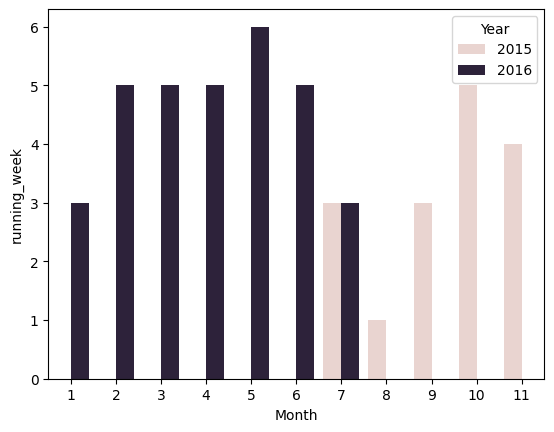

In [ ]:
def getKPI_SalesVsInvestment():
  dfInvestment_=getData_Investment()
  dfgc_Invst=dfInvestment_.groupby(["Invst_Year","Invst_Month"])["Invst_Per_Week"].sum().reset_index()
  dfgc_Invst["Invst_Per_Week_Prev"]=dfgc_Invst["Invst_Per_Week"].shift(1)
  dfgc_Invst.fillna(0,inplace=True)
  dfgc=dfSource.groupby(["Year","Month","order_week","product_analytic_sub_category"])[["Total_Sales"]].sum().reset_index()
  dfgc["Total_Sales_Cr"]=dfgc["Total_Sales"]/10000000
  dfgc['Percentage_Sale'] = (dfgc['Total_Sales'] / dfgc.groupby(["Year","Month","order_week"])['Total_Sales'].transform('sum')) * 100
  dfgc['Normalized_Sale'] = dfgc['Total_Sales'] * dfgc['Percentage_Sale']
  dfgc_merged=pd.merge(dfgc,dfgc_Invst,how="inner",right_on=["Invst_Year","Invst_Month"],left_on=["Year","Month"])
  dfgc_merged["Normalized_Sale_Cr"]=dfgc_merged["Normalized_Sale"]/10000000
  dfgc_merged_group=dfgc_merged.groupby(["Year","Month","product_analytic_sub_category"])[["Normalized_Sale_Cr","Invst_Per_Week_Prev"]].sum().reset_index()
  dfgc_merged_group.replace([np.inf, -np.inf], np.nan, inplace=True)
  dfgc_merged_group.fillna(0,inplace=True)
  dfgc_merged_group=dfgc_merged_group.groupby(["product_analytic_sub_category"])[["Normalized_Sale_Cr","Invst_Per_Week_Prev"]].sum().reset_index()
  dfgc_merged_group["SalesInvestment_Ratio"]=dfgc_merged_group["Normalized_Sale_Cr"]/dfgc_merged_group["Invst_Per_Week_Prev"]
  return dfgc_merged_group

def showKPI_SalesVsInvestment():
  fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(12,5))
  _data=getKPI_SalesVsInvestment()
  sns.barplot(data=_data,x="product_analytic_sub_category",y="SalesInvestment_Ratio",ax=axs[0])
  _data.rename(columns={"Normalized_Sale_Cr":"Sales","Invst_Per_Week_Prev":"Investment"},inplace=True)
  _data.plot.bar(x="product_analytic_sub_category",y=["Sales","Investment"],ax=axs[1])
  plt.subplots_adjust(wspace=0.5)

def showKPI_YearWeekPresencesofSales(dfSource):
  dfgc=dfSource.groupby(["Year","Month","running_week"])["Total_Sales_Million"].sum().reset_index()
  dfgc=dfgc.groupby(["Year","Month"])["running_week"].count().reset_index()
  sns.barplot(data=dfgc,x='Month',y='running_week',hue='Year')
showKPI_YearWeekPresencesofSales(dfSource)

def getKPI_SalesVsInvestmentMerged():
  dfInvestment_=getData_Investment()
  dfgc_Invst=dfInvestment_.groupby(["Invst_Year","Invst_Month"])["Invst_Per_Week"].sum().reset_index()
  dfgc_Invst["Invst_Per_Week_Prev"]=dfgc_Invst["Invst_Per_Week"].shift(1)
  dfgc_Invst.fillna(0,inplace=True)
  dfgc=dfSource.groupby(["Year","Month","order_week","running_week","product_analytic_sub_category"])[["Total_Sales"]].sum().reset_index()
  dfgc["Total_Sales_Cr"]=dfgc["Total_Sales"]/10000000
  dfgc['Percentage_Sale'] = (dfgc['Total_Sales'] / dfgc.groupby(["Year","Month","order_week"])['Total_Sales'].transform('sum')) * 100
  dfgc['Normalized_Sale'] = dfgc['Total_Sales'] * dfgc['Percentage_Sale']
  dfgc_merged=pd.merge(dfgc,dfgc_Invst,how="inner",right_on=["Invst_Year","Invst_Month"],left_on=["Year","Month"])
  dfgc_merged["Normalized_Sale_Cr"]=dfgc_merged["Normalized_Sale"]/10000000
  dfgc_merged.rename(columns={"Normalized_Sale_Cr":"Current_Week_Sale(cr)","Invst_Per_Week_Prev":"Prev_Week_Investment"},inplace=True)
  return dfgc_merged

def showKPI_SalesVsInvestment_Weekly():

  dfgc_merged=getKPI_SalesVsInvestmentMerged()
  fig,axs=plt.subplots(nrows=2,ncols=3,figsize=(15,5))

  dfgc_mergedCA_2015=dfgc_merged[(dfgc_merged['product_analytic_sub_category']=='CameraAccessory')&(dfgc_merged['Year']==2015)][['running_week','Current_Week_Sale(cr)','Prev_Week_Investment']]
  dfgc_mergedCA_2016=dfgc_merged[(dfgc_merged['product_analytic_sub_category']=='CameraAccessory')&(dfgc_merged['Year']==2016)][['running_week','Current_Week_Sale(cr)','Prev_Week_Investment']]

  dfgc_mergedGA_2015=dfgc_merged[(dfgc_merged['product_analytic_sub_category']=='GamingAccessory')&(dfgc_merged['Year']==2015)][['running_week','Current_Week_Sale(cr)','Prev_Week_Investment']]
  dfgc_mergedGA_2016=dfgc_merged[(dfgc_merged['product_analytic_sub_category']=='GamingAccessory')&(dfgc_merged['Year']==2016)][['running_week','Current_Week_Sale(cr)','Prev_Week_Investment']]

  dfgc_mergedHA_2015=dfgc_merged[(dfgc_merged['product_analytic_sub_category']=='HomeAudio')&(dfgc_merged['Year']==2015)][['running_week','Current_Week_Sale(cr)','Prev_Week_Investment']]
  dfgc_mergedHA_2016=dfgc_merged[(dfgc_merged['product_analytic_sub_category']=='HomeAudio')&(dfgc_merged['Year']==2016)][['running_week','Current_Week_Sale(cr)','Prev_Week_Investment']]

  dfgc_mergedCA_2015.set_index('running_week').plot(kind='bar', stacked=True,ax=axs[0,0])
  dfgc_mergedGA_2015.set_index('running_week').plot(kind='bar', stacked=True,ax=axs[0,1])
  dfgc_mergedHA_2015.set_index('running_week').plot(kind='bar', stacked=True,ax=axs[0,2])

  dfgc_mergedCA_2016.set_index('running_week').plot(kind='bar', stacked=True,ax=axs[1,0])
  dfgc_mergedGA_2016.set_index('running_week').plot(kind='bar', stacked=True,ax=axs[1,1])
  dfgc_mergedHA_2016.set_index('running_week').plot(kind='bar', stacked=True,ax=axs[1,2])

  axs[0,0].set_xlabel('Wkly.CameraAccessory[2015]')
  axs[0,1].set_xlabel('Wkly.GamingAccessory[2015]')
  axs[0,2].set_xlabel('Wkly.HomeAudio[2015]')

  axs[1,0].set_xlabel('Wkly.CameraAccessory[2016]')
  axs[1,1].set_xlabel('Wkly.GamingAccessory[2016]')
  axs[1,2].set_xlabel('Wkly.HomeAudio[2016]')
  plt.subplots_adjust(hspace=0.8)
  plt.show()


In [ ]:
def showKPI_InvestmentVsTotalSalesBySubCategory(dfSource_,Sub_CategoryName=""):
  dfInvestment_=getData_Investment()
  Invest_cols=['TV','Digital', 'Sponsorship',       'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio',       'Other']
  dfList=[]
  for _col in Invest_cols:
    _df=dfInvestment_[["Invst_Year","Invst_Month",_col,"number_of_weeks"]]
    _df["Invest_Type"]=_col #TV
    _df["Invested_Budget"]=_df[_col]/_df["number_of_weeks"] #TV/#weeks
    _df.drop(_col,axis=1,inplace=True)
    dfList.append(_df)
  dfSource_InvestAnalysis=pd.concat(dfList,axis=0)
  dfgc=dfSource_.groupby(["Year","Month","order_week","product_analytic_sub_category"])[["Total_Sales"]].sum().reset_index()
  dfgc["Total_Sales_Cr"]=dfgc["Total_Sales"]/10000000
  dfgc['Percentage_Sale'] = (dfgc['Total_Sales'] / dfgc.groupby(["Year","Month","order_week"])['Total_Sales'].transform('sum')) * 100
  dfgc['Normalized_Sale'] = dfgc['Total_Sales'] * dfgc['Percentage_Sale']
  dfgc_merged=pd.merge(dfgc,dfSource_InvestAnalysis,how="inner",right_on=["Invst_Year","Invst_Month"],left_on=["Year","Month"])
  dfgc_merged["Normalized_Sale_Cr"]=dfgc_merged["Normalized_Sale"]/10000000
  dfgc_merged["Invst_Per_Week_Prev"]=dfgc_merged["Invested_Budget"].shift(1)
  dfgc_merged.fillna(0,inplace=True)
  dfgc_merged["Invest_Type"].value_counts()
  _ncols=3
  _nrows=int(len(Invest_cols)/_ncols)
  _rowIndex=0
  fig, axs = plt.subplots(nrows=_nrows,ncols=_ncols,figsize=(35, 10))
  for i in range(_nrows):
    for j in range(_ncols):
      _col=Invest_cols[_rowIndex]
      ax1=axs[i,j]
      _data=dfgc_merged[dfgc_merged["Invest_Type"]==_col][['order_week','Normalized_Sale_Cr','Invst_Per_Week_Prev']]
      _data.set_index('order_week').plot(kind='bar', stacked=True,ax=ax1)
      ax1.set_xlabel(_col)
      ax1.annotate("Ad stock ="+_col, xy=(0, len(_data["Normalized_Sale_Cr"].unique())/2),weight='bold')
      _rowIndex=_rowIndex+1
  plt.subplots_adjust(wspace=0.1,hspace=0.3)
  plt.suptitle(Sub_CategoryName+" : AdStock Vs Sales by Order_Week")
  plt.grid(False)
  plt.show()


## Customer Portfolio Analysis

**Customer Segments and Product Sub Category**

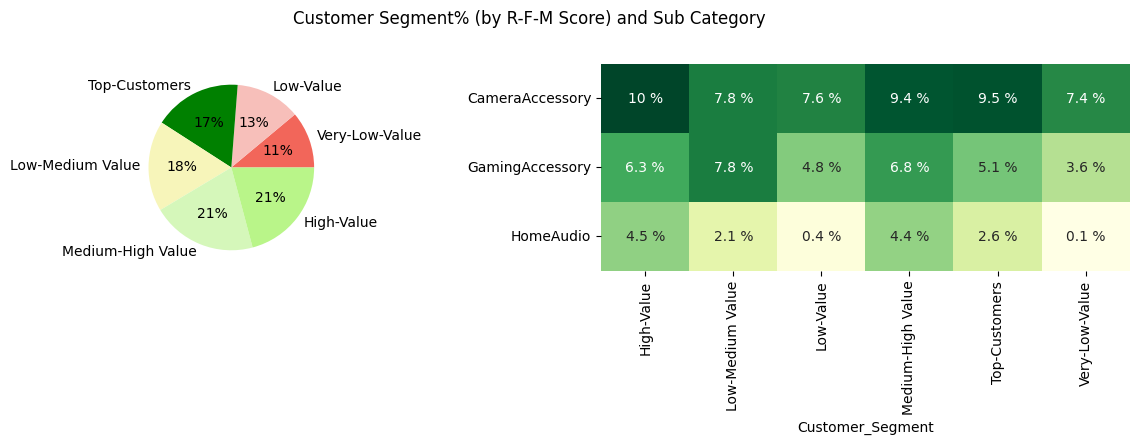

In [ ]:
showCustomer_Segments(dfSource)

**Sales By Customer Segment by Sub Category**

In [ ]:
dfgc_sub_cat=dfSource.groupby(["product_analytic_sub_category","Customer_Segment"])["Total_Sales_Million"].sum().reset_index()
dfgc_sub_cat=dfgc_sub_cat.sort_values(by=["product_analytic_sub_category","Total_Sales_Million"],ascending=[True,False])
dfgc_sub_cat
#sns.barplot(data=dfgc_sub_cat,x="product_analytic_sub_category",y="Total_Sales_Million",hue="Customer_Segment")

product_analytic_sub_category   Customer_Segment  Total_Sales_Million
4                CameraAccessory      Top-Customers            27.442367
0                CameraAccessory         High-Value            24.028822
3                CameraAccessory  Medium-High Value            10.950908
1                CameraAccessory   Low-Medium Value             5.721289
2                CameraAccessory          Low-Value             2.782804
5                CameraAccessory     Very-Low-Value             2.236136
10               GamingAccessory      Top-Customers            15.807725
6                GamingAccessory         High-Value            13.659607
9                GamingAccessory  Medium-High Value             9.902994
7                GamingAccessory   Low-Medium Value             5.730061
8                GamingAccessory          Low-Value             2.023654
11               GamingAccessory     Very-Low-Value             1.070497
12                     HomeAudio         High-Value            16.866045
15                     HomeAudio  Medium-High Value            11.869699
16                     HomeAudio      Top-Customers             8.710583
13                     HomeAudio   Low-Medium Value             2.265447
14                     HomeAudio          Low-Value             0.235825
17                     HomeAudio     Very-Low-Value             0.021179

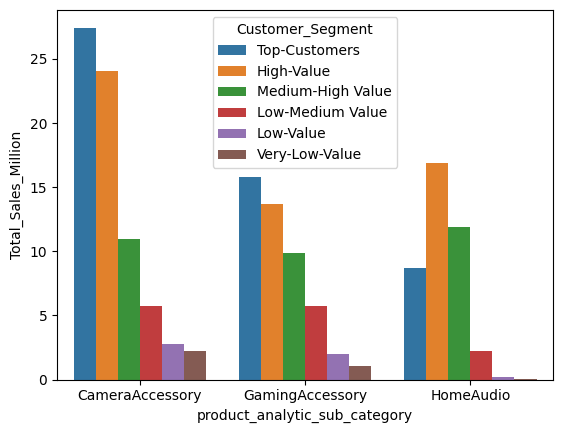

In [ ]:
showKPI_CustomerSegmentvsTotalSales(dfSource)

**Sales by Pincode Clusters**

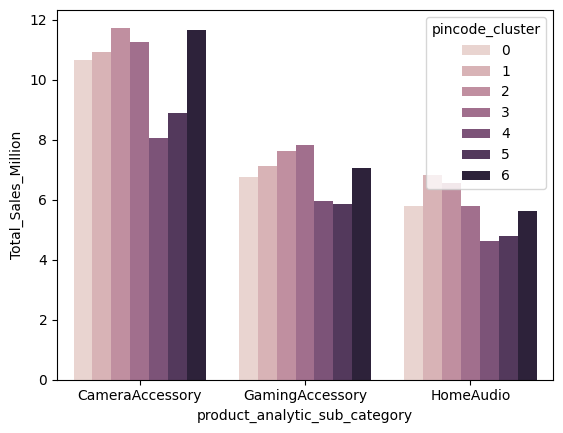

In [ ]:
showKPI_SalesByPincodeCluster(dfSource)

**New Customer Onboarding Trend By Years**

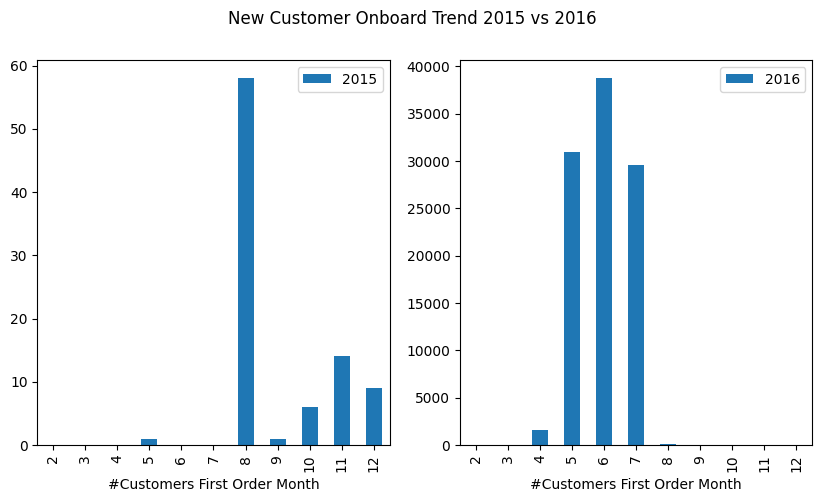

In [ ]:
showKPI_NewCustomerOnBoardTrendByYears(dfSource)

**Dormant Customers with 1 Order History**

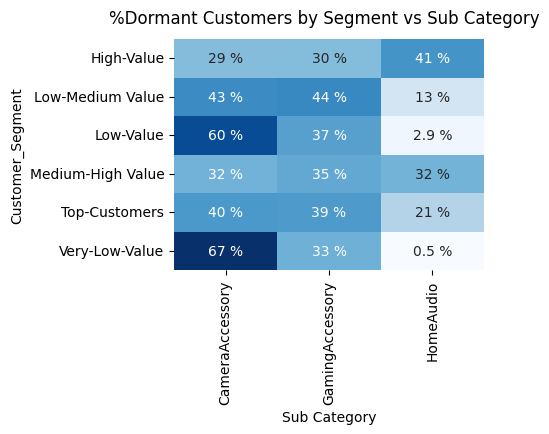

In [103]:
showKPI_DormantCustomers(dfSource)

**Customers Likely To Churn**

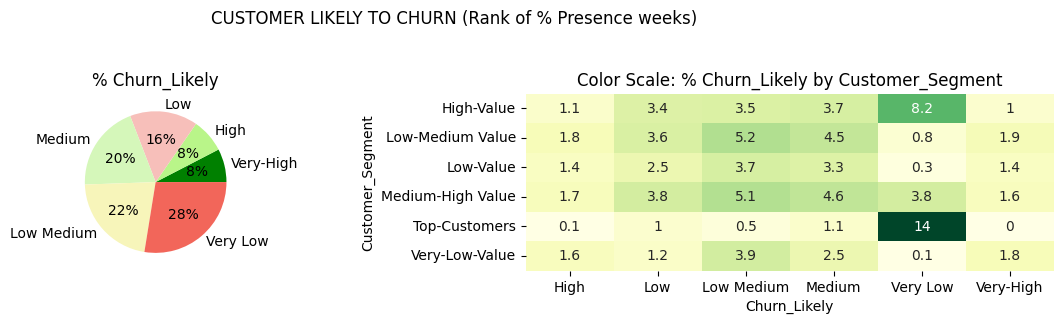

In [ ]:
showChurn_Likely(dfSource)

**Pincode Cluster Dashboard**

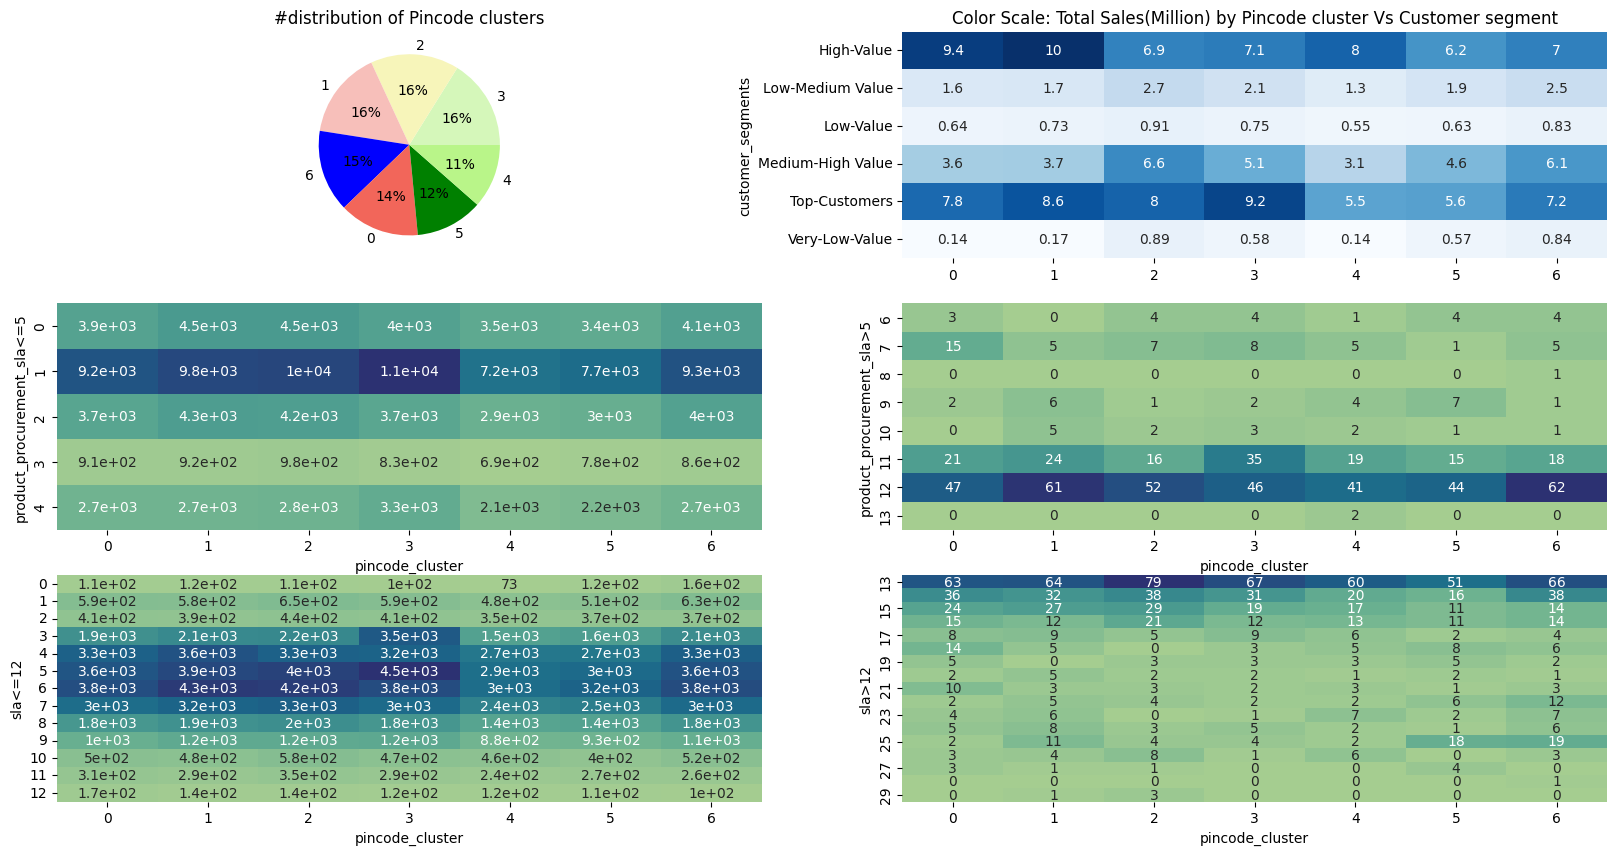

In [109]:
showKPI_PincodeClusters(dfSource)

# Product Portfolio Analysis

**Product Vertical for Each Sub Category**

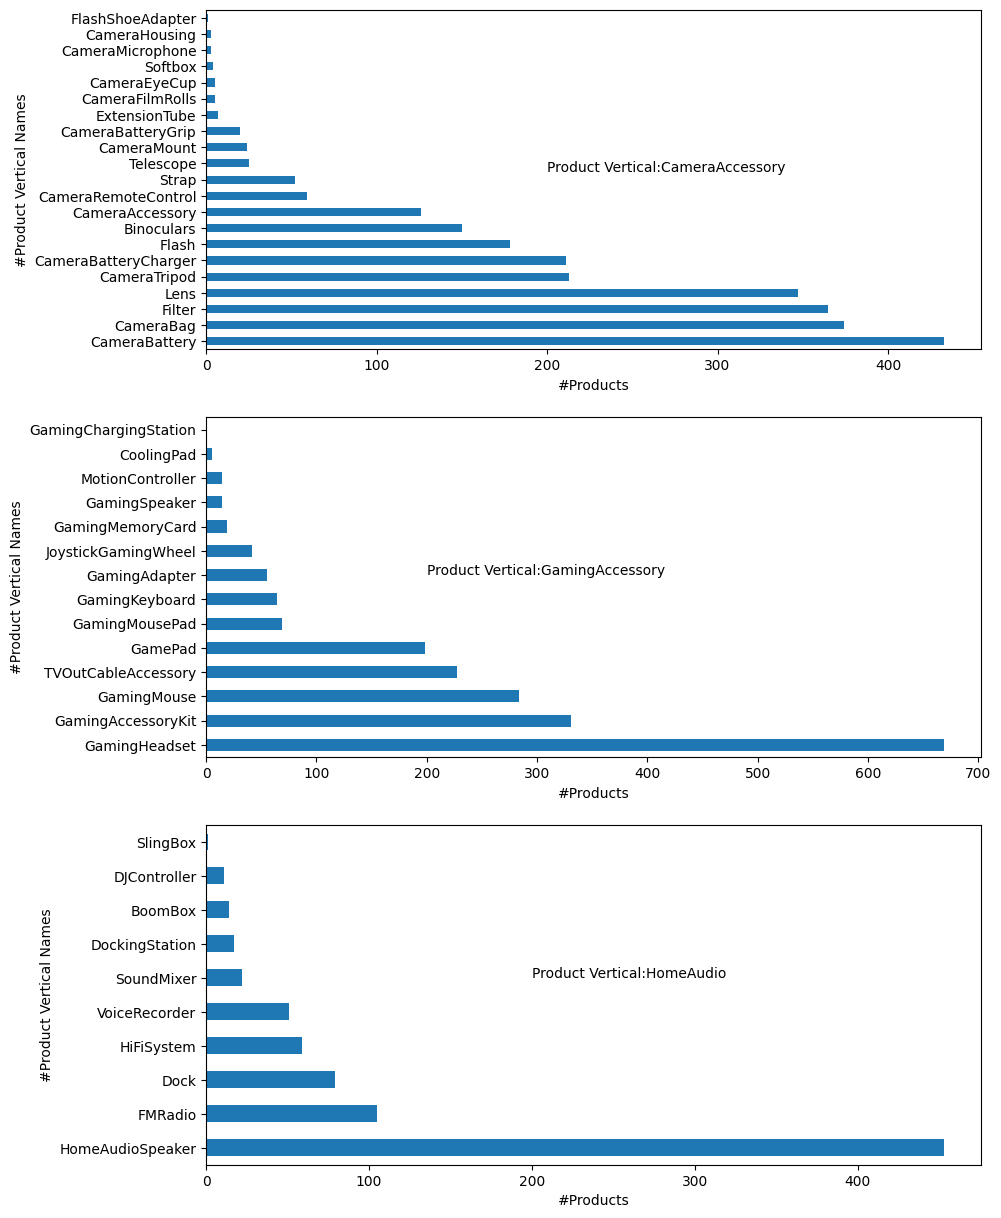

In [ ]:
showKPI_ProductAnalyticVertical(dfSource)

# Sales Dashboard

4 3


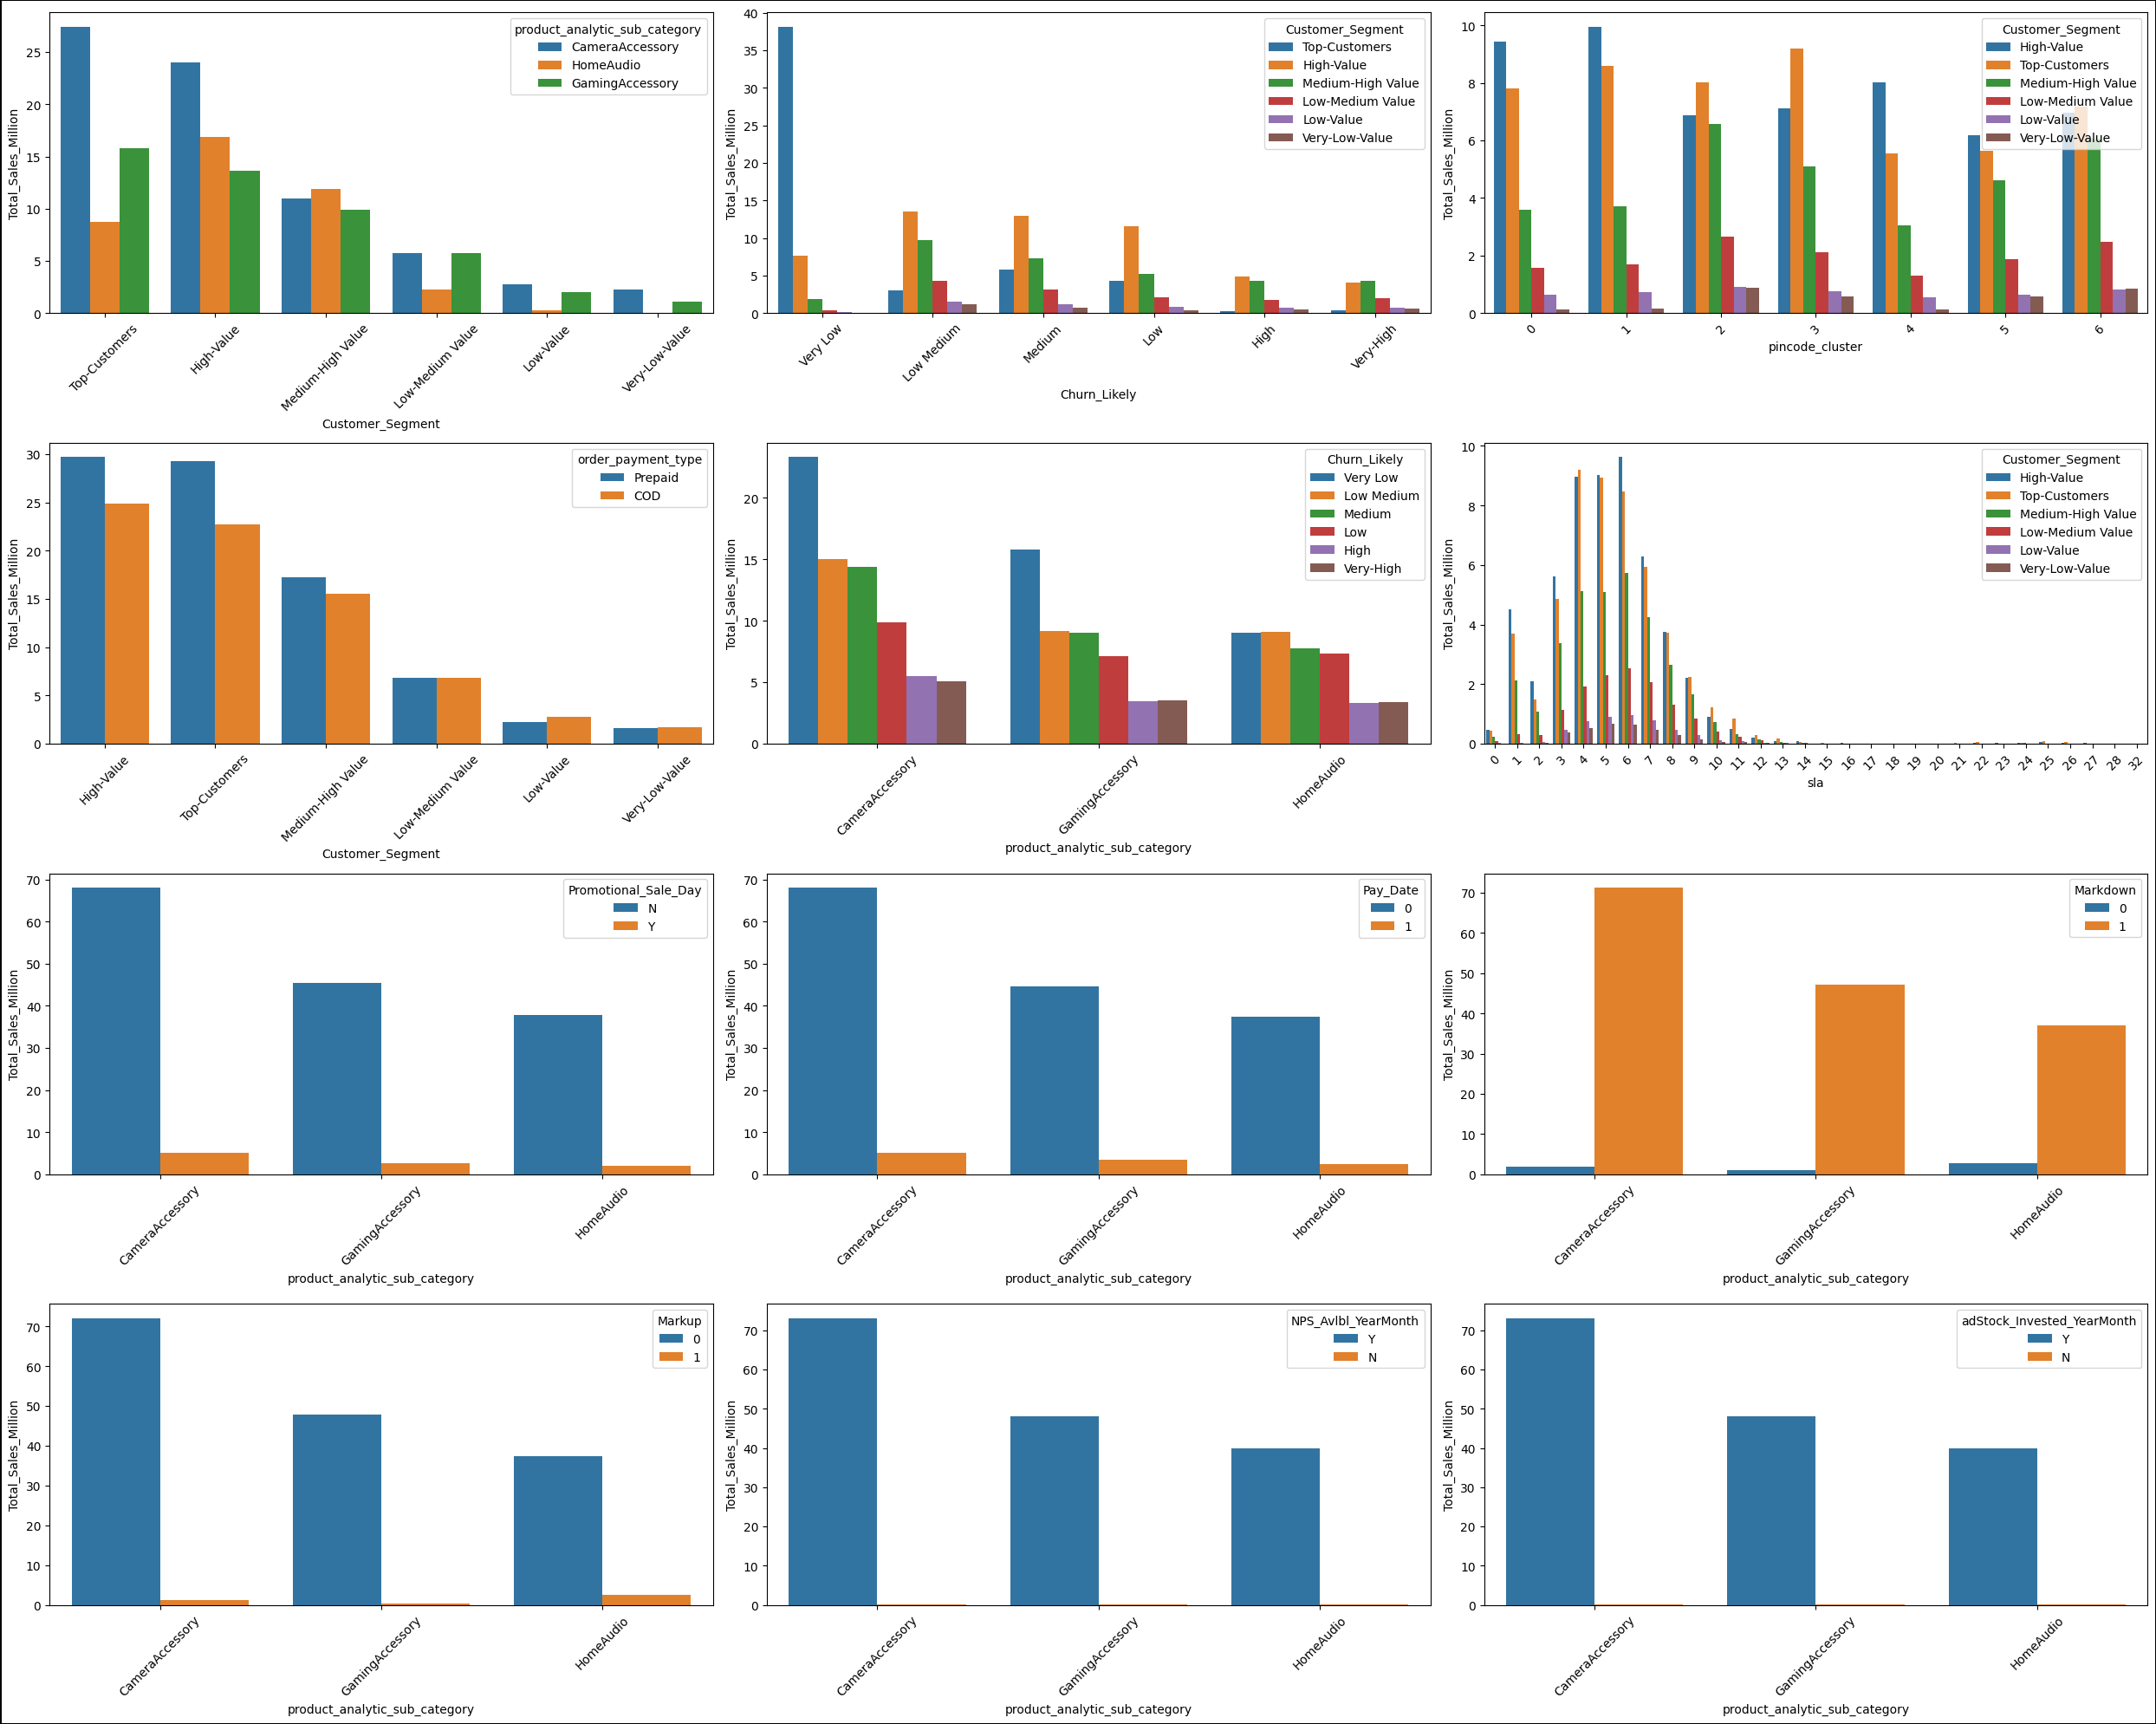

In [ ]:
showKPI_TotalSalesDashboard(dfSource)

**Sales (Million) and #Orders by Sla and product_procurement_sla**

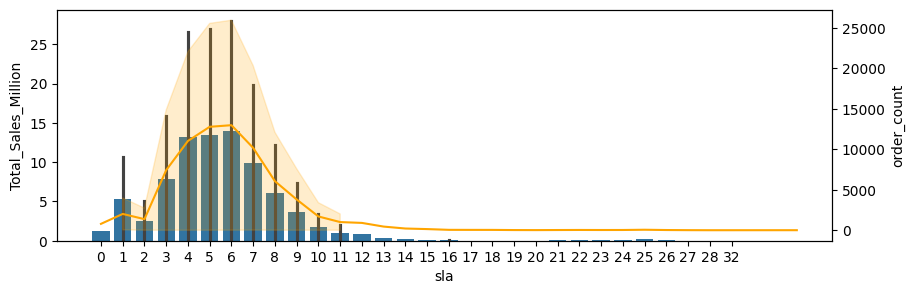

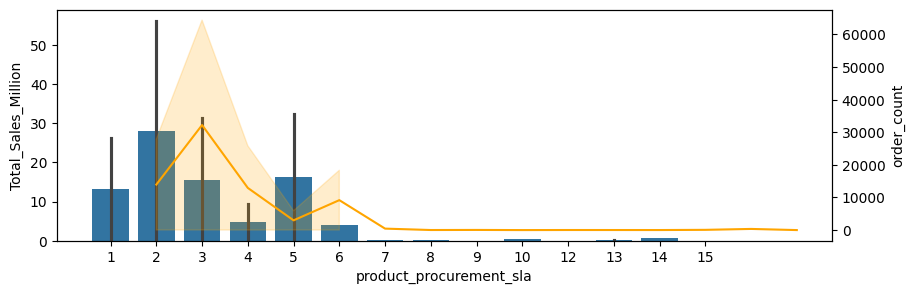

In [ ]:
showKPI_TotalSalesnOrderBySla(dfSource,"sla")
showKPI_TotalSalesnOrderBySla(dfSource,"product_procurement_sla")

# Investment Analysis

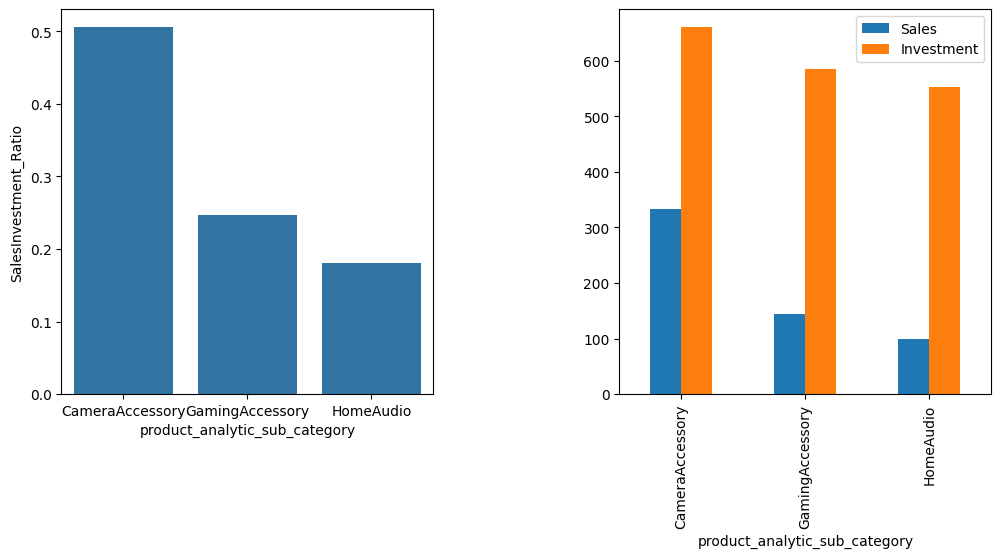

In [ ]:
showKPI_SalesVsInvestment()

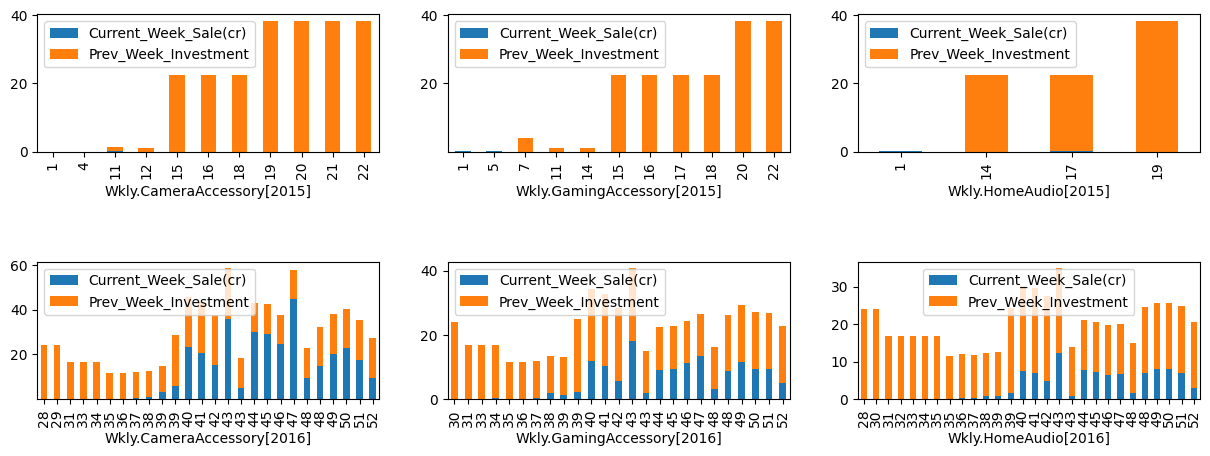

In [ ]:
showKPI_SalesVsInvestment_Weekly()

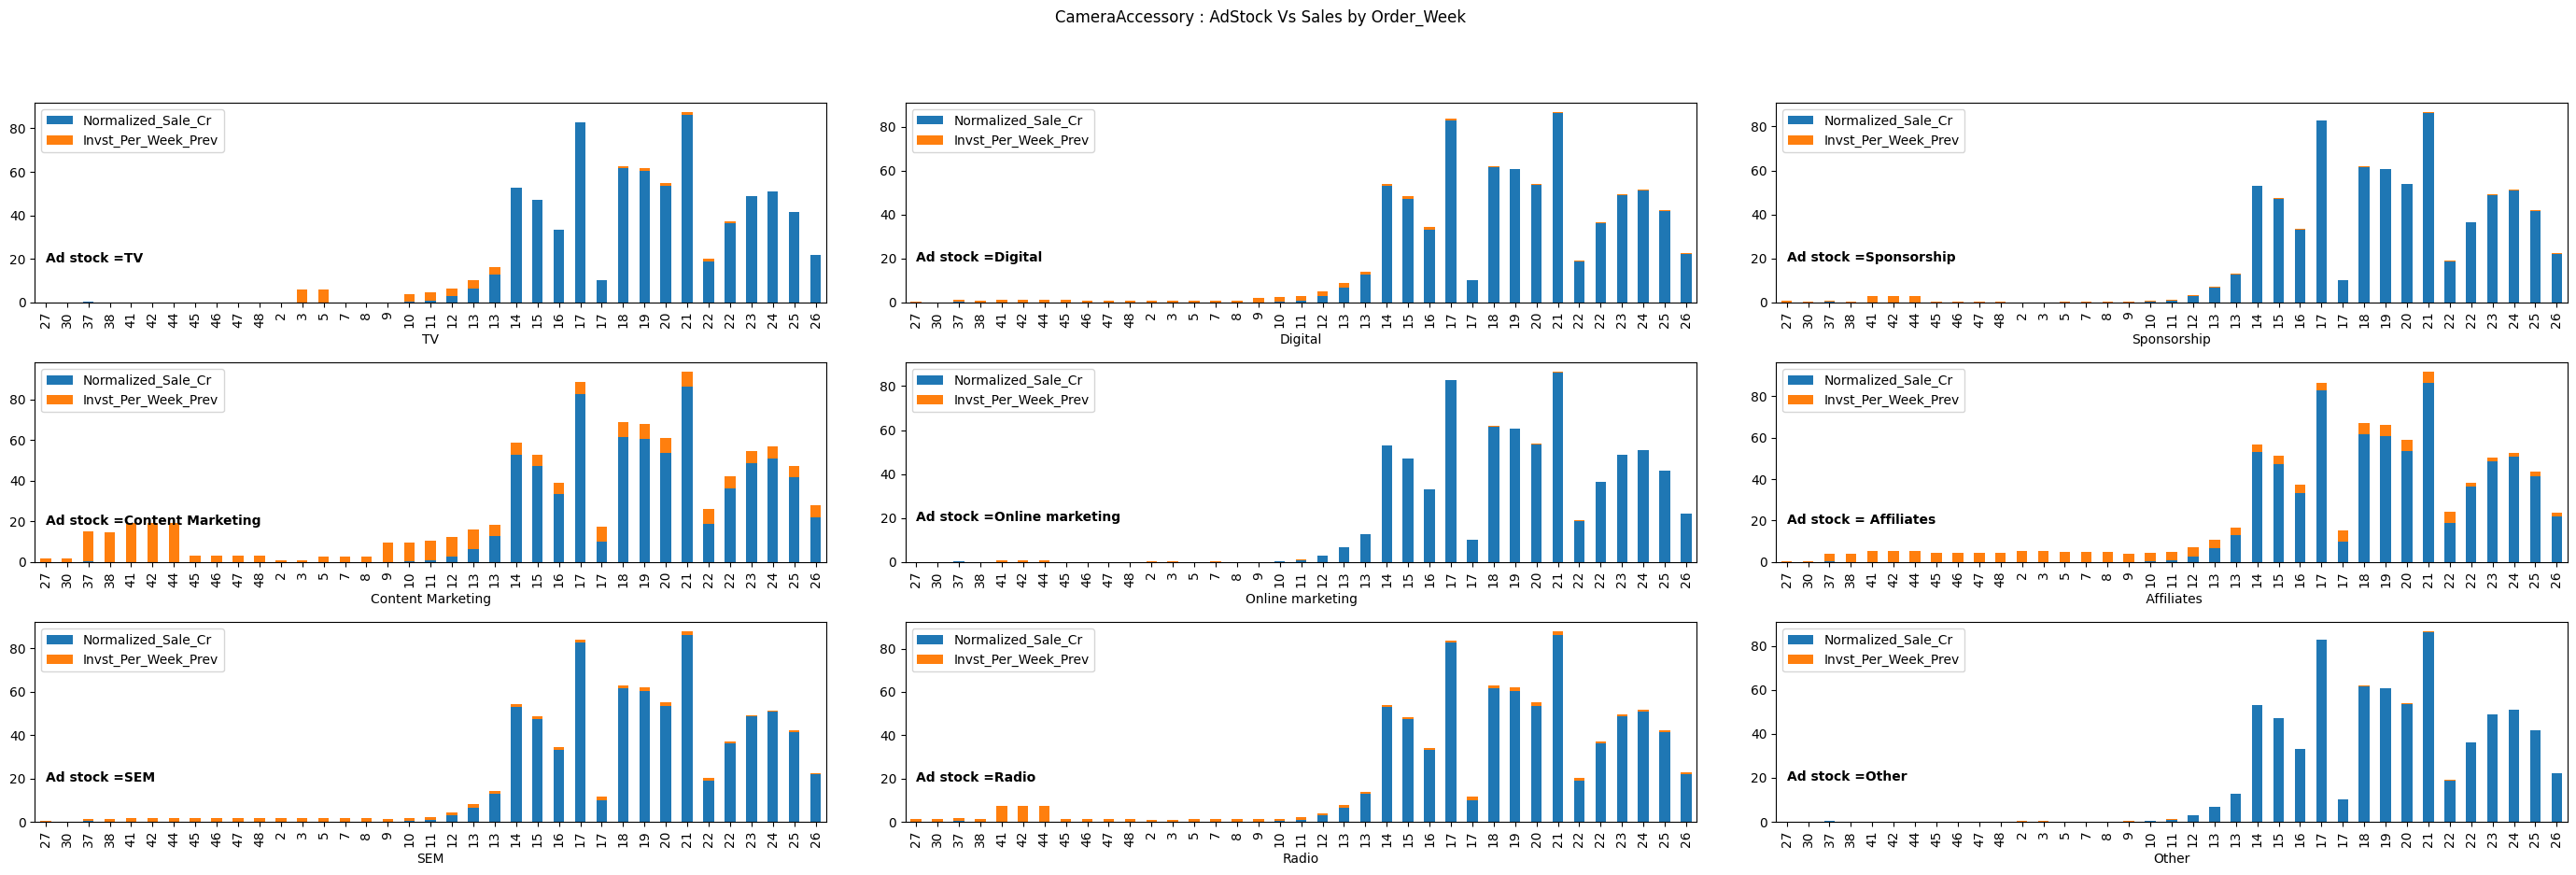

In [ ]:
showKPI_InvestmentVsTotalSalesBySubCategory(dfSource_CameraAccessory,'CameraAccessory')

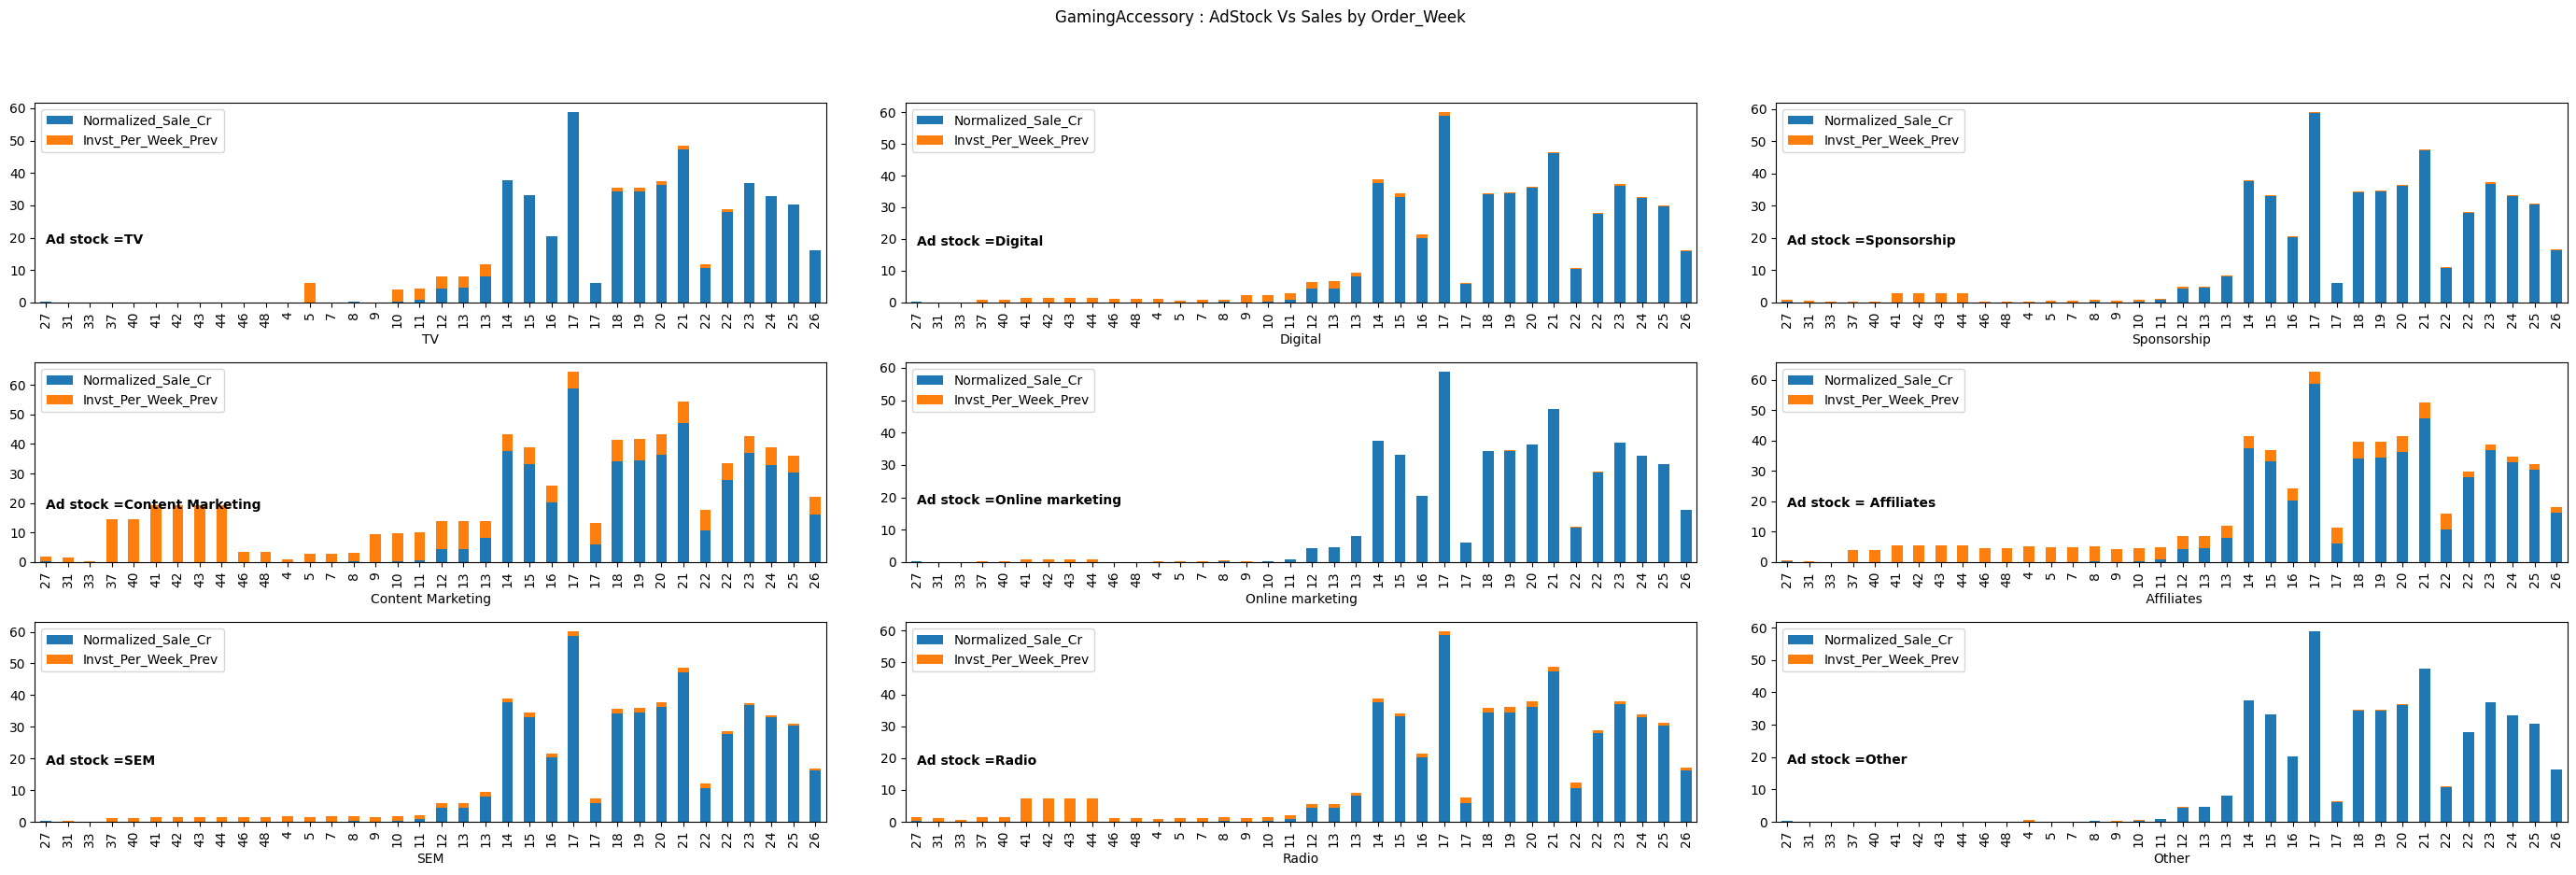

In [ ]:
showKPI_InvestmentVsTotalSalesBySubCategory(dfSource_GamingAccessory,'GamingAccessory')

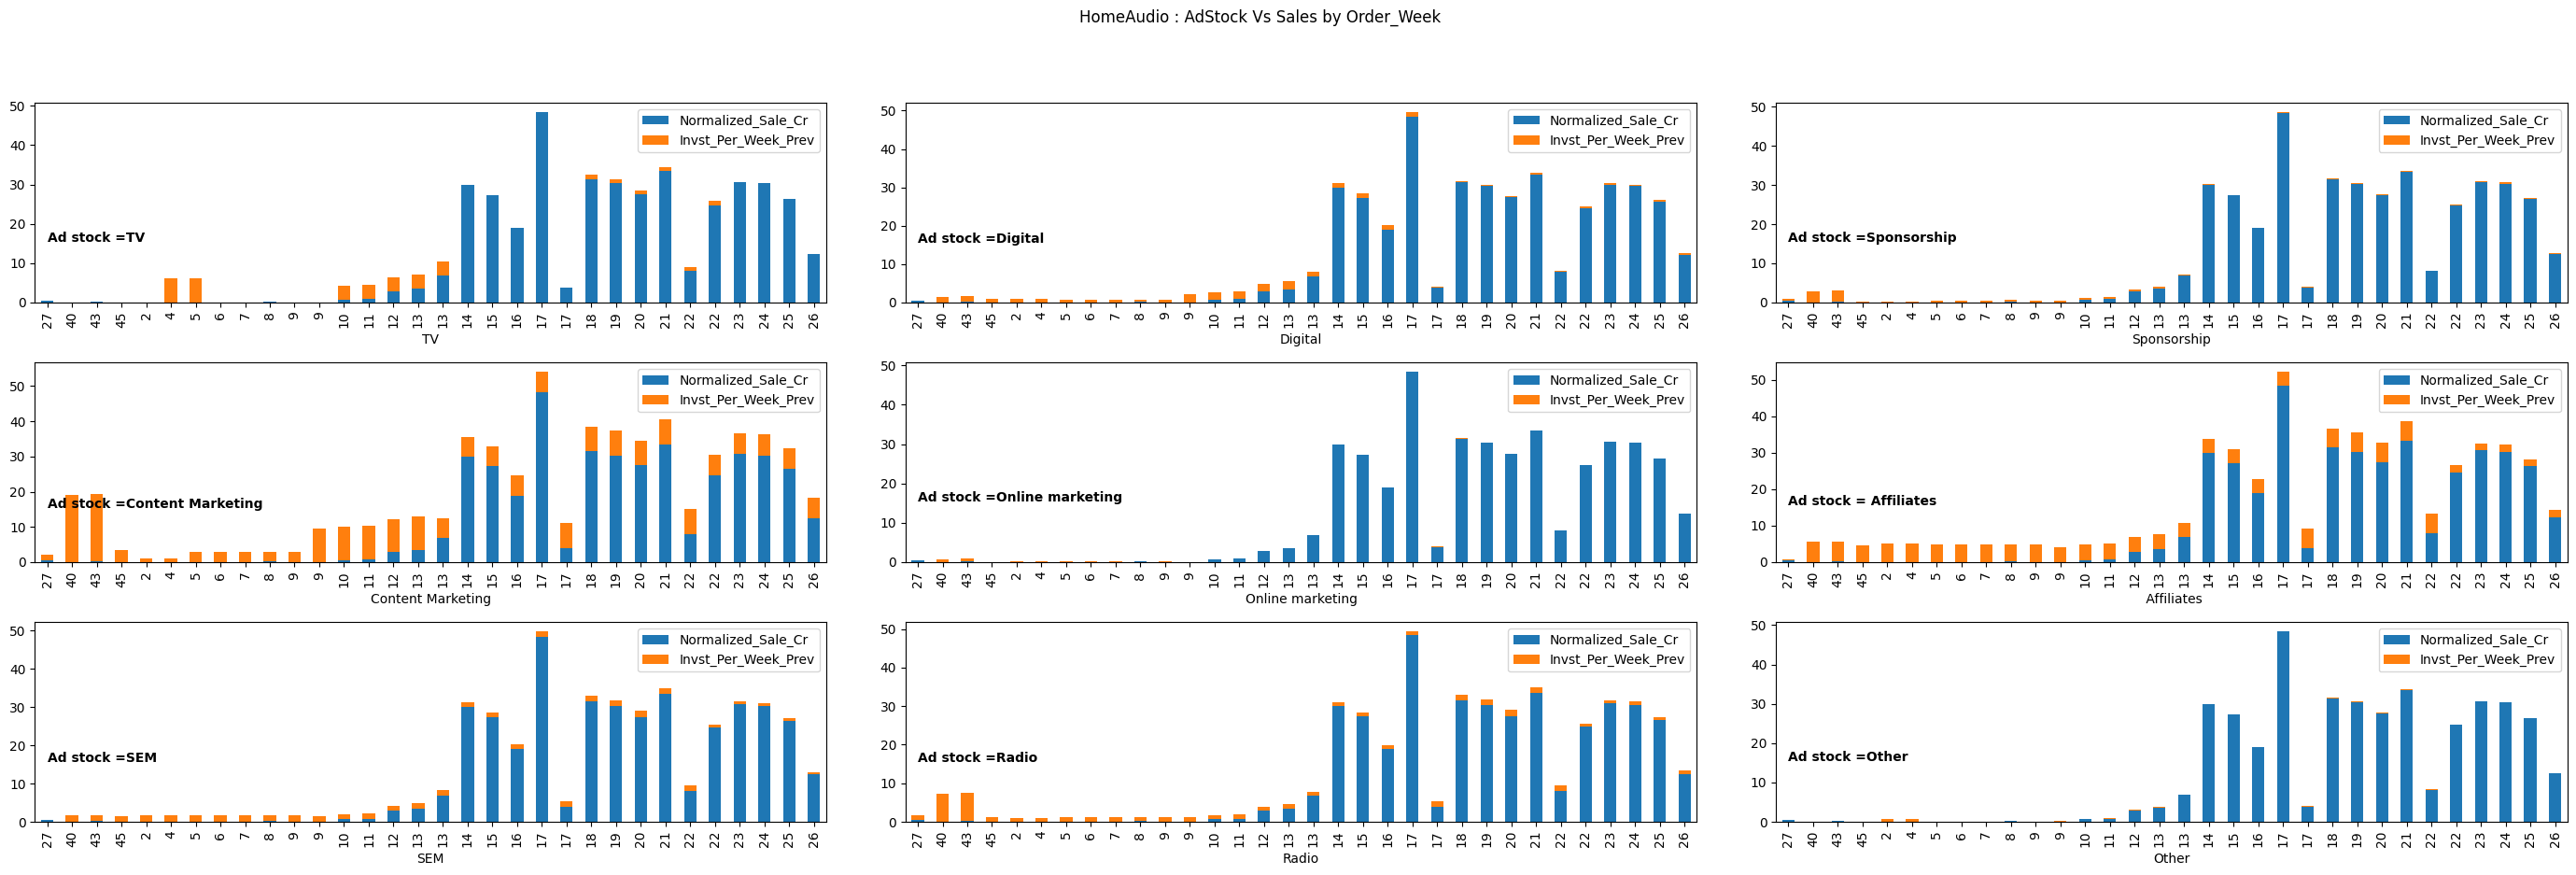

In [ ]:

showKPI_InvestmentVsTotalSalesBySubCategory(dfSource_HomeAudio,'HomeAudio')

# NPS Analysis

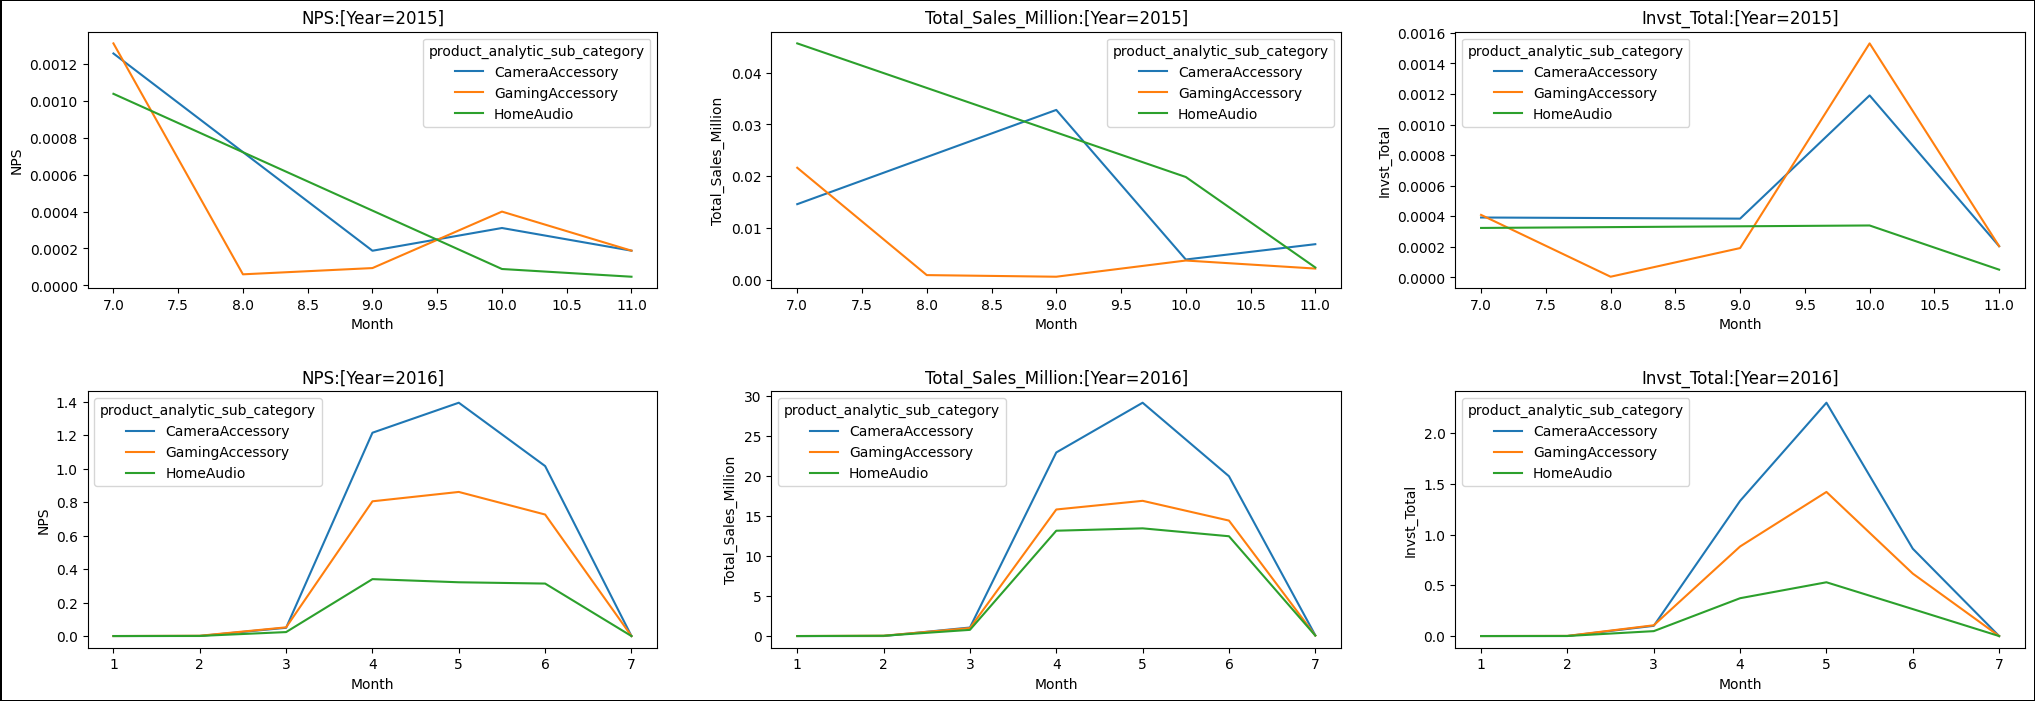

In [ ]:
showKPI_NPSDashboard(dfSource)

# Data Modelling

In [ ]:
class UDFLinearRegressionModel:
  def __init__(self, _dfSource, _numericColumns=[],train_size_=0.7,test_size_=0.3,scaler_=None,lm_=None,Target_Variable_="",p_thresholdValue=0.05,_model_title="Basic LR+RFE",_datasetname="All",showModelTitle=True):
    self.showModelTitle=showModelTitle
    self.DataSetName=_datasetname
    self.Model_Title=_model_title
    self.dfSource=_dfSource
    self.dfModel = _dfSource.copy()
    self.numericColumns = _numericColumns
    self.dfModel_Train=pd.DataFrame([])
    self.dfModel_Test=pd.DataFrame([])
    self.train_size=train_size_
    self.test_size=test_size_
    self.scaler=MinMaxScaler()
    self.model_numerical_variables=[]
    self.Target_Variable=Target_Variable_
    self.lm=LinearRegression()
    self.rfe=None
    self.X_train=None
    self.y_train=None
    self.y_train_cnt_new=None
    self.X_test=None
    self.y_test=None
    self.y_pred_cnt_new=None
    self.n_features_to_select=0
    self.rfecv_lr=None
    self.rfecv_folds=None
    self.GSCV_hyper_params=None
    self.gridsearch_cv=None
    self.cols_RFE=[]
    self.p_thresholdValue=p_thresholdValue
    self.VIF_thresholdValue=5
    self.X_train_rfe=None
    self.Linear_Model=None
    self.Linear_Model_Result=None
    self.ModelSummaryResult=[]
    self.PValueColumnsToBeRemoved=[]
    self.p_value_columnName='P>|t|'
    self.ListOfColumnsRemoved=[]
    self.dfVIF=[]
    self.ModelEquation=""
    if lm_!=None:
      self.lm=lm_
    if scaler_!=None:
      self.scaler=scaler_

  def InitModelXY(self):
    print("InitModelXY....")
    self.y_train = self.dfModel_Train.pop(self.Target_Variable)
    self.X_train = self.dfModel_Train
    self.X_train=self.X_train.astype(float)
    self.X_train_lm_new=None
    if self.lm==None:
      self.lm = LinearRegression()
    self.lm.fit(self.X_train, self.y_train)

  def InitRFE(self):
    print("InitRFE...")
    self.rfe= RFE(self.lm, n_features_to_select=self.n_features_to_select)             # running RFE
    self.rfe = self.rfe.fit(self.X_train, self.y_train)
    self.cols_RFE = self.X_train.columns[self.rfe.support_]

  def InitRFECV(self,_cv=5):
    print("InitRFECV...")
    self.rfecv_folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    self.rfecv_folds = cross_val_score(self.lm, self.X_train, self.y_train, scoring='r2', cv=self.rfecv_folds)
    print("scores_folds:",self.rfecv_folds)
    self.rfecv_lr=RFECV(estimator=self.lm,cv=_cv)
    self.rfecv_lr.fit(self.X_train, self.y_train)
    print(len(self.rfecv_lr.feature_names_in_),self.rfecv_lr.feature_names_in_)
    print(list(zip(self.X_train.columns,self.rfecv_lr.support_,self.rfecv_lr.ranking_)))
    self.cols_RFE = self.X_train.columns[self.rfecv_lr.support_]

  def InitGridSearchCV(self):
    print("InitGridSearchCV...")
    _nsplits=7
    folds = KFold(n_splits = _nsplits, shuffle = True, random_state = 100)
    # step-2: specify range of hyperparameters to tune
    self.GSCV_hyper_params = {'copy_X': [True,False], 'fit_intercept': [True,False],'n_jobs': [1,5,10,15,None]}
    # 3.2 call GridSearchCV()
    self.gridsearch_cv = GridSearchCV(estimator = self.lm,
                            param_grid = self.GSCV_hyper_params,
                            scoring= 'r2',
                            cv = folds,
                            verbose = 1,
                            return_train_score=True)

    # fit the model
    self.gridsearch_cv.fit(self.X_train, self.y_train)
    print(f"Best Hyperparameters: {self.gridsearch_cv.best_params_}")
    # Accuracy of the model after using best parameters
    print(f"Best Score: {self.gridsearch_cv.best_score_}")
    print("self.gridsearch_cv.best_estimator_",self.gridsearch_cv.best_estimator_)
    print("self.gridsearch_cv")
    self.cols_RFE = self.X_train[self.gridsearch_cv.feature_names_in_].columns
    print("self.cols_RFE",self.cols_RFE)



  def InitModelFit(self):
    print("Initialize Model Fit....")
    self.X_train_rfe = self.X_train[self.cols_RFE]
    self.X_train_rfe = sm.add_constant(self.X_train_rfe)
    self.Linear_Model = sm.OLS(self.y_train,self.X_train_rfe)
    self.Linear_Model_Result=self.Linear_Model.fit()
    return self.Linear_Model,self.Linear_Model_Result

  def InitModelSummaryResult(self):
    print("(Re)initializing Model Result")
    self.ModelSummaryResult=self.Linear_Model_Result.summary2().tables[1]
    self.ModelSummaryResult['cols_tobe_removed']=self.ModelSummaryResult.index
    self.ModelSummaryResult=self.ModelSummaryResult.sort_values(by=[self.p_value_columnName],ascending=False)
    self.PValueColumnsToBeRemoved=self.ModelSummaryResult[self.ModelSummaryResult[self.p_value_columnName]>self.p_thresholdValue]
    #print("#self.PValueColumnsToBeRemoved",len(self.PValueColumnsToBeRemoved))
    return self.ModelSummaryResult

  def getPValueColumnsToBeRemoved(self):
    self.PValueColumnsToBeRemoved=self.ModelSummaryResult[self.ModelSummaryResult[self.p_value_columnName]>self.p_thresholdValue].head()
    return self.PValueColumnsToBeRemoved


  def addToRemovedColumns(self,_removedCol_Name,_removed_pvalue,_remove_factor,_removed_threshold):
    self.ListOfColumnsRemoved.append({"col_Name":_removedCol_Name,"removed_col_value":_removed_pvalue,"removed_by":_remove_factor,"threshold_Value":_removed_threshold})



  def RefitModel(self):
    print("REFITTING")
    self.X_train_lm_new = sm.add_constant(self.X_train_rfe)
    self.Linear_Model = sm.OLS(self.y_train,self.X_train_lm_new)
    self.Linear_Model_Result=self.Linear_Model.fit()
    return self.Linear_Model,self.Linear_Model_Result,self.X_train_lm_new


  def dropColumnByPValue(self,_removedCol_Name,_removed_pvalue):
    print('Dropping =',_removedCol_Name," with P-Value= ",_removed_pvalue)
    self.X_train_rfe.drop(_removedCol_Name, axis = 1,inplace=True,errors='ignore')
    self.addToRemovedColumns(_removedCol_Name,_removed_pvalue,'p-value',self.p_thresholdValue)

  def getFirstColumnInfoFromModelSummary(self):
    col_Name=self.PValueColumnsToBeRemoved['cols_tobe_removed'].iloc[0]
    p_value=self.PValueColumnsToBeRemoved[self.p_value_columnName].iloc[0]
    if col_Name=='const' and len(self.PValueColumnsToBeRemoved)>1:
      print("CONST arrived so moving to next column")
      col_Name=self.PValueColumnsToBeRemoved['cols_tobe_removed'].iloc[1]
      p_value=self.PValueColumnsToBeRemoved[self.p_value_columnName].iloc[1]
    return col_Name,p_value,len(self.PValueColumnsToBeRemoved)

  def DropAndRefitInsignificantColumns_ByPValues(self):
    print("DropAndRefitInsignificantColumns_ByPValues....")
    #print("#cols to be removed by P-Values",len(self.PValueColumnsToBeRemoved))
    while(len(self.PValueColumnsToBeRemoved)>0):
      _removedCol_Name,_removed_pvalue,num_values_toremove=self.getFirstColumnInfoFromModelSummary()
      print(_removedCol_Name,_removed_pvalue,num_values_toremove)
      if _removedCol_Name=='const': #and num_values_toremove==1:
        break
      self.dropColumnByPValue(_removedCol_Name,_removed_pvalue)
      self.RefitModel()
      self.InitModelSummaryResult()

  def getColumnsRemovedList(self):
    dfColumnsRemoved=pd.DataFrame([])
    if len(self.ListOfColumnsRemoved)>0:
      print("List of Columns Removed by Insignificant p-values")
      dfColumnsRemoved=pd.DataFrame.from_dict(self.ListOfColumnsRemoved)
    return dfColumnsRemoved


  def getVIF(self,_X_train):
    vif = pd.DataFrame()
    vif['Features'] = _X_train.columns
    vif['VIF'] = [variance_inflation_factor(_X_train.values, i) for i in range(_X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif['OutSideLimit?']=vif['VIF']>5
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

  def dropVariableByVIFInfinityandRefFit(self,_X_train):
    lrModel_1=None
    lrResult_1=None
    X_train_lm_new=None
    self.dfVIF=self.getVIF(_X_train)
    self.dfVIF.replace([np.inf, -np.inf], np.nan, inplace=True)
    null_cols=getNullColumns(self.dfVIF)
    VIF_Infinity_cols=list(self.dfVIF[self.dfVIF["VIF"].isnull()]["Features"].unique())
    if len(VIF_Infinity_cols)>0:
      _X_train.drop(VIF_Infinity_cols,axis=1,inplace=True,errors='ignore')
      lrModel_1,lrResult_1,X_train_lm_new=self.RefitModel()
    return _X_train,X_train_lm_new,lrModel_1,lrResult_1

  def getVIFGreaterThanThreshold(self):
    self.dfVIF=self.getVIF(self.X_train_rfe)
    _colToRemove=""
    _VIF=-1
    VIFGreaterthanThreshold=self.dfVIF[self.dfVIF["VIF"]>self.VIF_thresholdValue]
    if len(VIFGreaterthanThreshold)>0:
      _colToRemove=VIFGreaterthanThreshold["Features"].iloc[0]
      _VIF=VIFGreaterthanThreshold["VIF"].iloc[0]
    return VIFGreaterthanThreshold,_colToRemove,_VIF

  def DropVariableByVIFandRefFit(self):
    lrModel_1=None
    lrResult_1=None
    X_train_lm_new=None
    self.dropVariableByVIFInfinityandRefFit(self.X_train_rfe)
    VIFGreaterthanThreshold,_colToRemove,_VIF=self.getVIFGreaterThanThreshold()
    while (len(VIFGreaterthanThreshold)>0):
      print("drop =",_colToRemove,"with VIF",_VIF," and REFIT")
      self.X_train_rfe.drop(_colToRemove,axis=1,inplace=True,errors='ignore')
      self.addToRemovedColumns(_colToRemove,_VIF,'VIF',self.VIF_thresholdValue)
      lrModel_1,lrResult_1,X_train_lm_new=self.RefitModel()
      print('calculating VIF again')
      VIFGreaterthanThreshold,_colToRemove,_VIF=self.getVIFGreaterThanThreshold()
      print("#VIFGreaterthanThreshold",len(VIFGreaterthanThreshold))

  def showResidualChart(self,):
    self.y_train_cnt_new = self.Linear_Model_Result.predict(self.X_train_lm_new)
    fig = plt.figure()
    sns.distplot((self.y_train - self.y_train_cnt_new), bins = 40)
    fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading
    plt.xlabel('Errors', fontsize = 18)                         # X-label

  def InitTestTrainData(self):
    print("InitTestTrainData...")
    self.dfModel.fillna(0,inplace=True)
    self.dfModel_Train, self.dfModel_Test = train_test_split(self.dfModel, train_size=self.train_size, test_size =self.test_size, random_state = 100)

  def PerformScaling(self):
    print("PerformScaling.....")
    from sklearn.preprocessing import MinMaxScaler
    self.model_numerical_variables=getColumnsByType(self.dfModel_Train,'numeric')
    self.dfModel_Train=self.dfModel_Train[self.model_numerical_variables]
    self.dfModel_Train[self.model_numerical_variables] = self.scaler.fit_transform(self.dfModel_Train[self.model_numerical_variables])
    self.n_features_to_select=len(self.model_numerical_variables)

  #FITTEST
  def FitTest(self):
    print("FitTest.....")
    #print("self.model_numerical_variables",self.model_numerical_variables)
    if "const" in self.model_numerical_variables:
      self.model_numerical_variables.remove("const")
    self.dfModel_Test[self.model_numerical_variables] = self.scaler.transform(self.dfModel_Test[self.model_numerical_variables])
    #print("self.dfModel_Test.columns=",self.dfModel_Test.columns)
    self.y_test_new = self.dfModel_Test.pop(self.Target_Variable)
    self.X_test_new = self.dfModel_Test
    self.X_test_new = self.X_test_new[self.X_train_rfe.columns]
    # Adding a constant variable
    self.X_test_new = sm.add_constant(self.X_test_new)
    self.y_pred_cnt_new = self.Linear_Model_Result.predict(self.X_test_new)

    return self.y_test_new,self.y_pred_cnt_new

  def getR2Score(self):
    from sklearn.metrics import r2_score
    self.r2_score=r2_score(self.y_test_new, self.y_pred_cnt_new)
    print("r2_score",self.r2_score)
    return self.r2_score
  #ShowFitTestModel
  def ShowFitTestModel(self):
    fig = plt.figure()
    plt.scatter(self.y_test_new,self.y_pred_cnt_new)
    m, b= np.polyfit(self.y_test_new, self.y_pred_cnt_new,1)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16)                          # Y-label
    plt.plot(self.y_test_new, m*self.y_test_new+b, color='red')
    _annotateText=self.DataSetName
    if self.showModelTitle==True:
      _annotateText=_annotateText+self.Model_Title
    plt.annotate(_annotateText +"'s r^2= {:.3f}".format(self.r2_score), xy=(0, self.y_pred_cnt_new.max()))

  def getModelEquation(self):
    col_name='cols_tobe_removed'
    dfEquation=self.ModelSummaryResult.copy()
    dfEquation.rename(columns={'cols_tobe_removed':'selected_Feature'},inplace=True)
    dfEquation['Coef_Feature']=dfEquation.apply(lambda x: str(round(x['Coef.'],4))+"*"+x['selected_Feature'],axis=1)
    self.ModelEquation=dfEquation['Coef_Feature'].str.cat(sep='+')
    return self.ModelEquation

  def InitDFForDataModelling(self):
    print("InitDFForDataModelling...")
    self.dfModel=self.dfSource.copy()
    selected_numeric_cols=self.numericColumns
    self.dfModel.rename(columns={"adStock_Invested_YearMonth":"IsAdStockInvested"},inplace=True)
    self.dfModel.rename(columns={"NPS_Avlbl_YearMonth":"IsNPSAvailable"},inplace=True)
    if len(selected_numeric_cols)==0:
      numeric_group_days=['deliverybdays', 'deliverycdays','sla','product_procurement_sla','Holiday','Pay_Date']
      numeric_group_adStock=['TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other']
      numeric_price_related_columns=[ 'discount', 'Markup', 'Markdown','NPS','Invst_Total' ,'product_mrp','gmv']#
      numeric_weather_relatedcolumns=['Max_Temp__Degc', 'Min_Temp__Degc',  'Heat_Deg_Days__Degc', 'Cool_Deg_Days__Degc', 'Total_Rain__mm', 'Total_Snow__cm', 'Total_Precip__mm','Snow_on_Grnd__cm']

      selected_numeric_cols=numeric_group_days
      selected_numeric_cols.extend(numeric_group_adStock)
      selected_numeric_cols.extend(numeric_price_related_columns)
    getColumnsByType(self.dfSource,'categorical')
    cat_cols=[
    {"col_name":"Promotional_Sale_Day","prefix":"Sale_Day_"},
    {"col_name":"IsAdStockInvested","prefix":"IsAdStockInvested_"},
    {"col_name":"IsNPSAvailable","prefix":"IsNPSAvailable_"},
    {"col_name":"product_analytic_vertical","prefix":""}
    ]
    dfFinal_Dummy=pd.DataFrame([])
    dfDummies=[]
    for _col in cat_cols:
      col_name= _col["col_name"]
      _prefix=_col["prefix"]
      dfDummy=pd.get_dummies(self.dfModel[col_name],drop_first=True,prefix=_prefix)
      dfDummies.append(dfDummy)
      self.dfModel.drop(col_name,axis=1,inplace=True)

    dfFinal_Dummy=pd.concat(dfDummies,axis=1)
    dfFinal_Dummy.columns=dfFinal_Dummy.columns.str.replace('_',"")
    dfFinal_Dummy.columns=dfFinal_Dummy.columns.str.replace('-',"_")
    dfFinal_Dummy.columns=dfFinal_Dummy.columns.str.replace(' ',"_")
    dfFinal_Dummy.columns

    self.dfModel=pd.concat([self.dfModel[selected_numeric_cols],dfFinal_Dummy],axis=1)
    return self.dfModel

  def ProcessModelAndShowResults(self):
    self.InitDFForDataModelling()
    self.InitTestTrainData()
    self.PerformScaling()
    self.InitModelXY()
    if self.Model_Title=="Basic LR+RFE":
      print("Basic Linear Regression Modelling")
      self.InitRFE()
    elif self.Model_Title=="LR+RFECV":
      print("Linear Regression Modelling with RFECV")
      self.InitRFECV()
    elif self.Model_Title=="LR+GSCV":
      print("Liner Regression Modelling with Grid SearchCV + Hyper Parameter Tuning")
      self.InitGridSearchCV()
    self.InitModelFit()
    self.InitModelSummaryResult()
    print("="*20)
    print("Removing Columns with insiginificant p-values=====")
    print("="*20)

    self.DropAndRefitInsignificantColumns_ByPValues()
    print("#columns with p-value>0.05",len(self.PValueColumnsToBeRemoved))
    if len(self.PValueColumnsToBeRemoved)>0:
    #lg.getColumnsRemovedList()
      print(self.ModelSummaryResult[self.ModelSummaryResult[self.p_value_columnName]>0.05])
      self.getColumnsRemovedList()
    print("="*20)
    print("Removing columns with MultiCollinearity with VIF>5")
    print("="*20)

    self.DropVariableByVIFandRefFit()
    print("="*20)
    print("List of Columns Removed")
    print("="*20)
    self.getColumnsRemovedList()
    print("="*20)
    print("Columns included for prediction")
    print("="*20)
    print(self.X_train_rfe.columns)
    print("="*20)
    self.showResidualChart()
    self.FitTest()
    self.getR2Score()
    self.ShowFitTestModel()
    self.getModelEquation()
    print(lg.Linear_Model_Result.summary())
    print("============MODELLING PROCESSING COMPLETED==============")




**UDFLinearRegressionModel**

In [ ]:
_Target_Variable='gmv'

InitDFForDataModelling...
InitTestTrainData...
PerformScaling.....
InitModelXY....
Basic Linear Regression Modelling
InitRFE...
Initialize Model Fit....
(Re)initializing Model Result
Removing Columns with insiginificant p-values=====
DropAndRefitInsignificantColumns_ByPValues....
Invst_Total 0.9941935089909233 53
Dropping = Invst_Total  with P-Value=  0.9941935089909233
REFITTING
(Re)initializing Model Result
FlashShoeAdapter 0.9785026862296651 52
Dropping = FlashShoeAdapter  with P-Value=  0.9785026862296651
REFITTING
(Re)initializing Model Result
product_procurement_sla 0.9505766805769508 51
Dropping = product_procurement_sla  with P-Value=  0.9505766805769508
REFITTING
(Re)initializing Model Result
ExtensionTube 0.9380477606062319 50
Dropping = ExtensionTube  with P-Value=  0.9380477606062319
REFITTING
(Re)initializing Model Result
CameraMicrophone 0.9303430851707368 49
Dropping = CameraMicrophone  with P-Value=  0.9303430851707368
REFITTING
(Re)initializing Model Result
GamingMemor

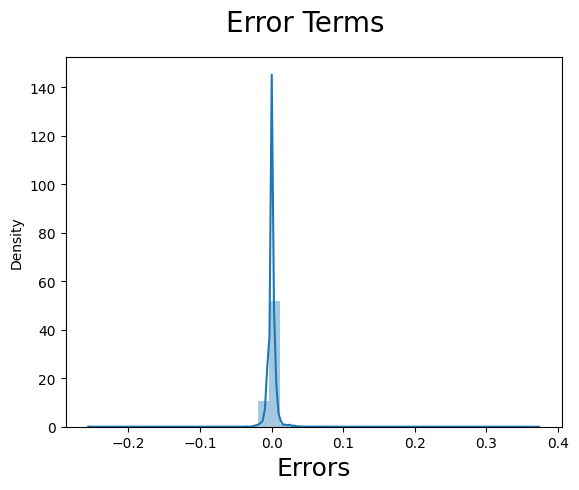

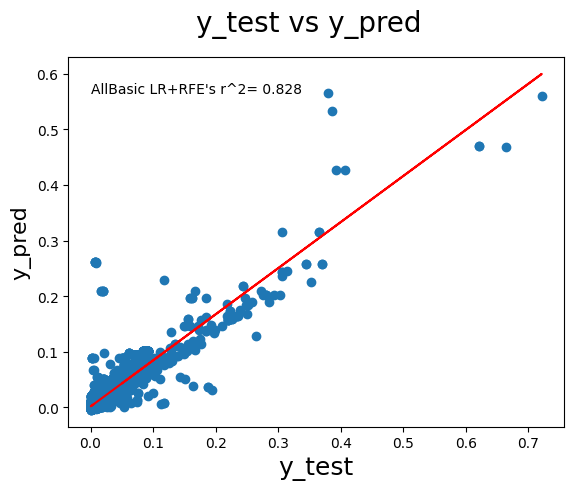

In [ ]:
lg=UDFLinearRegressionModel(dfSource,train_size_=0.7,test_size_=0.3,Target_Variable_=_Target_Variable)
lg.ProcessModelAndShowResults()




In [ ]:
lg.getModelEquation()

'-0.0022*deliverybdays+0.0001*Filter+0.0003*CameraAccessory+0.0027*deliverycdays+0.0001*GamingHeadset+0.0002*GamingKeyboard+-0.0002*Other+-0.0004*sla+0.0002*JoystickGamingWheel+0.0006*MotionController+0.0004*TVOutCableAccessory+0.0002*GamePad+0.0003*CameraBattery+0.0013*VoiceRecorder+0.0014*CameraFilmRolls+0.0229*SlingBox+0.0465*const+-0.459*discount+1.0002*product_mrp'

**with K-fold Cross validations**

InitDFForDataModelling...
InitTestTrainData...
PerformScaling.....
InitModelXY....
Linear Regression Modelling with RFECV
InitRFECV...
scores_folds: [0.99006682 0.99417177 0.99167147 0.97760016 0.98760789]
68 ['deliverybdays' 'deliverycdays' 'sla' 'product_procurement_sla' 'Holiday'
 'Pay_Date' 'TV' 'Digital' 'Sponsorship' 'Content Marketing'
 'Online marketing' ' Affiliates' 'SEM' 'Radio' 'Other' 'discount'
 'Markup' 'Markdown' 'NPS' 'Invst_Total' 'product_mrp' 'SaleDayY'
 'IsAdStockInvestedY' 'IsNPSAvailableY' 'BoomBox' 'CameraAccessory'
 'CameraBag' 'CameraBattery' 'CameraBatteryCharger' 'CameraBatteryGrip'
 'CameraEyeCup' 'CameraFilmRolls' 'CameraHousing' 'CameraMicrophone'
 'CameraMount' 'CameraRemoteControl' 'CameraTripod' 'CoolingPad'
 'DJController' 'Dock' 'DockingStation' 'ExtensionTube' 'FMRadio' 'Filter'
 'Flash' 'FlashShoeAdapter' 'GamePad' 'GamingAccessoryKit' 'GamingAdapter'
 'GamingChargingStation' 'GamingHeadset' 'GamingKeyboard'
 'GamingMemoryCard' 'GamingMouse' 'Gamin

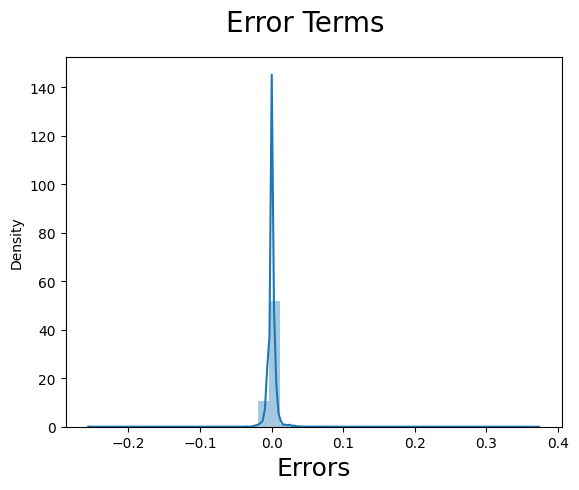

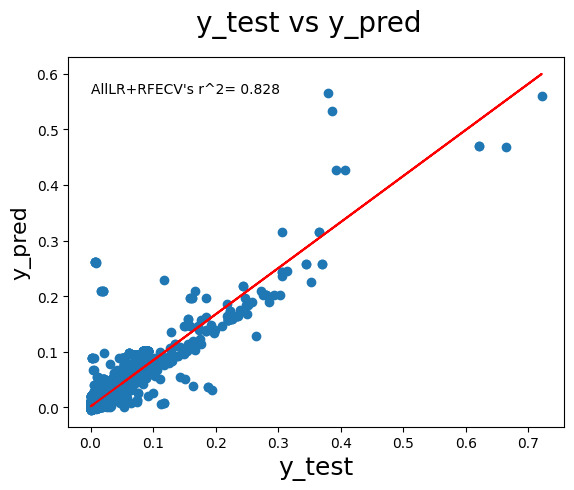

In [ ]:
numeric_columns=getColumnsByType(dfSource,'numeric')
lg_RFECV=UDFLinearRegressionModel(dfSource,train_size_=0.7,test_size_=0.3,Target_Variable_=_Target_Variable,_model_title="LR+RFECV")
lg_RFECV.ProcessModelAndShowResults()


**With GridSearch Search CV and Hyper Parameter Tuning**

InitDFForDataModelling...
InitTestTrainData...
PerformScaling.....
InitModelXY....
Liner Regression Modelling with Grid SearchCV + Hyper Parameter Tuning
InitGridSearchCV...
Fitting 7 folds for each of 20 candidates, totalling 140 fits
Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1}
Best Score: 0.9884500369308918
self.gridsearch_cv.best_estimator_ LinearRegression(n_jobs=1)
self.gridsearch_cv
self.cols_RFE Index(['deliverybdays', 'deliverycdays', 'sla', 'product_procurement_sla',
       'Holiday', 'Pay_Date', 'TV', 'Digital', 'Sponsorship',
       'Content Marketing', 'Online marketing', ' Affiliates', 'SEM', 'Radio',
       'Other', 'discount', 'Markup', 'Markdown', 'NPS', 'Invst_Total',
       'product_mrp', 'SaleDayY', 'IsAdStockInvestedY', 'IsNPSAvailableY',
       'BoomBox', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'C

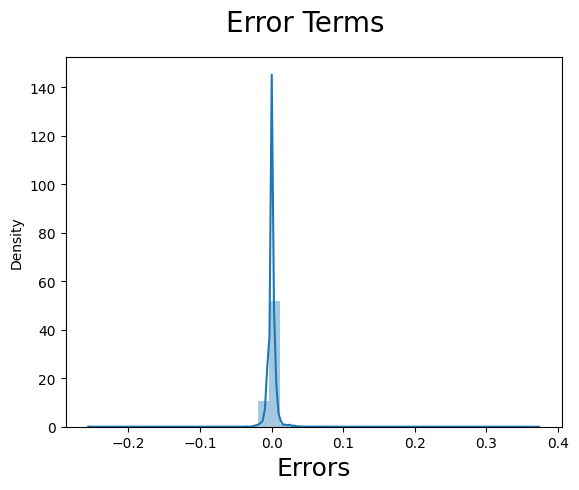

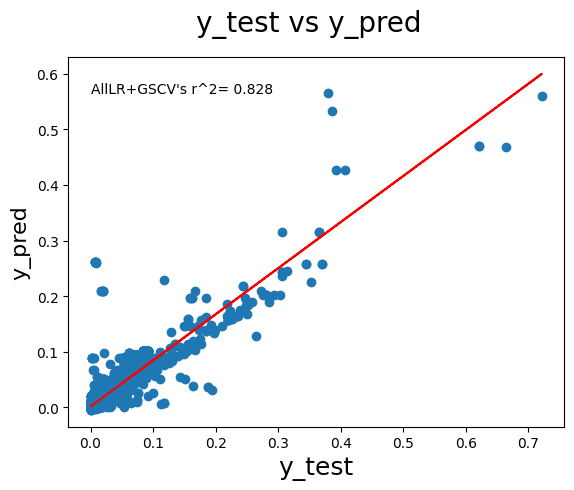

In [ ]:
lg_GSCV=UDFLinearRegressionModel(dfSource,train_size_=0.7,test_size_=0.3,Target_Variable_=_Target_Variable,_model_title="LR+GSCV")
lg_GSCV.ProcessModelAndShowResults()


In [ ]:
lg_eqn=lg.getModelEquation()
print("lg_eqn=",lg_eqn)


lg_eqn= -0.0022*deliverybdays+0.0001*Filter+0.0003*CameraAccessory+0.0027*deliverycdays+0.0001*GamingHeadset+0.0002*GamingKeyboard+-0.0002*Other+-0.0004*sla+0.0002*JoystickGamingWheel+0.0006*MotionController+0.0004*TVOutCableAccessory+0.0002*GamePad+0.0003*CameraBattery+0.0013*VoiceRecorder+0.0014*CameraFilmRolls+0.0229*SlingBox+0.0465*const+-0.459*discount+1.0002*product_mrp


In [ ]:
lg_RFECV_eqn=lg_RFECV.getModelEquation()
print("lg_RFECV_eqn=",lg_RFECV_eqn)


lg_RFECV_eqn= -0.0022*deliverybdays+0.0001*Filter+0.0003*CameraAccessory+0.0027*deliverycdays+0.0001*GamingHeadset+0.0002*GamingKeyboard+-0.0002*Other+-0.0004*sla+0.0002*JoystickGamingWheel+0.0006*MotionController+0.0004*TVOutCableAccessory+0.0002*GamePad+0.0003*CameraBattery+0.0013*VoiceRecorder+0.0014*CameraFilmRolls+0.0229*SlingBox+0.0465*const+-0.459*discount+1.0002*product_mrp


In [ ]:
lg_GSCV_eqn=lg_GSCV.getModelEquation()
print("lg_GSCV_eqn=",lg_GSCV_eqn)


lg_GSCV_eqn= -0.0022*deliverybdays+0.0001*Filter+0.0003*CameraAccessory+0.0027*deliverycdays+0.0001*GamingHeadset+0.0002*GamingKeyboard+-0.0002*Other+-0.0004*sla+0.0002*JoystickGamingWheel+0.0006*MotionController+0.0004*TVOutCableAccessory+0.0002*GamePad+0.0003*CameraBattery+0.0013*VoiceRecorder+0.0014*CameraFilmRolls+0.0229*SlingBox+0.0465*const+-0.459*discount+1.0002*product_mrp


Verifying if same features are selected to ensure the stability of the Models

In [ ]:
lg_GSCV_eqn==lg_RFECV_eqn==lg_eqn

True

**As all three are performing idential selected the Basic Linear Regression Model and continuing to Model for Each of the Sub Category**

# Linear Regression Model for Camera Accessory

InitDFForDataModelling...
InitTestTrainData...
PerformScaling.....
InitModelXY....
Basic Linear Regression Modelling
InitRFE...
Initialize Model Fit....
(Re)initializing Model Result
Removing Columns with insiginificant p-values=====
DropAndRefitInsignificantColumns_ByPValues....
Strap 0.9944102695296104 33
Dropping = Strap  with P-Value=  0.9944102695296104
REFITTING
(Re)initializing Model Result
FlashShoeAdapter 0.9889572687335528 32
Dropping = FlashShoeAdapter  with P-Value=  0.9889572687335528
REFITTING
(Re)initializing Model Result
product_procurement_sla 0.9844736070876595 31
Dropping = product_procurement_sla  with P-Value=  0.9844736070876595
REFITTING
(Re)initializing Model Result
Pay_Date 0.9495603019681573 30
Dropping = Pay_Date  with P-Value=  0.9495603019681573
REFITTING
(Re)initializing Model Result
ExtensionTube 0.8886018411271943 29
Dropping = ExtensionTube  with P-Value=  0.8886018411271943
REFITTING
(Re)initializing Model Result
CameraHousing 0.817328900552428 28
Drop

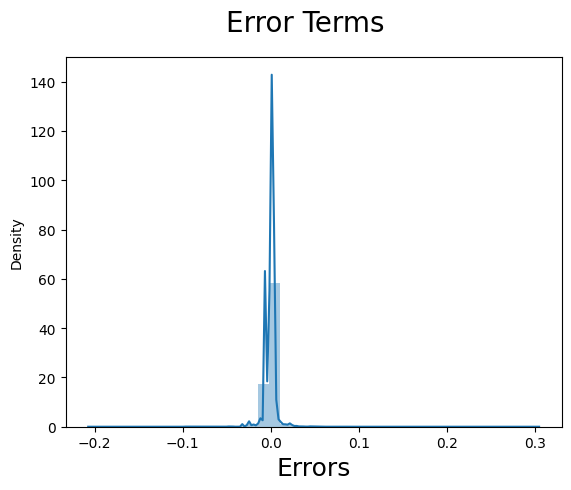

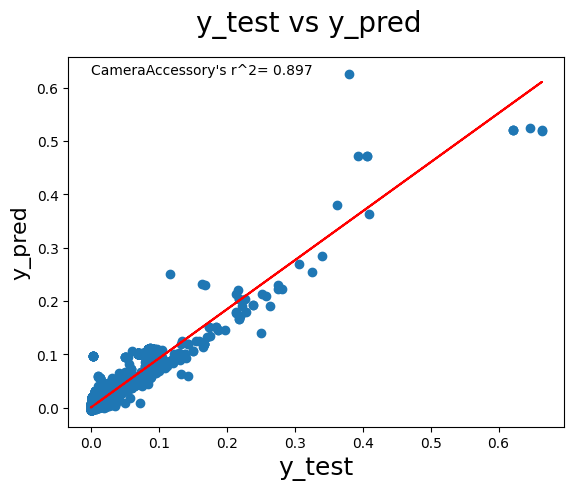

In [ ]:
lg_CA=UDFLinearRegressionModel(dfSource_CameraAccessory,train_size_=0.7,test_size_=0.3,Target_Variable_=_Target_Variable,_datasetname='CameraAccessory',showModelTitle=False)
lg_CA.ProcessModelAndShowResults()

InitDFForDataModelling...
InitTestTrainData...
PerformScaling.....
InitModelXY....
Basic Linear Regression Modelling
InitRFE...
Initialize Model Fit....
(Re)initializing Model Result
Removing Columns with insiginificant p-values=====
DropAndRefitInsignificantColumns_ByPValues....
SaleDayY 0.9839193438600493 33
Dropping = SaleDayY  with P-Value=  0.9839193438600493
REFITTING
(Re)initializing Model Result
Holiday 0.9737270753615866 32
Dropping = Holiday  with P-Value=  0.9737270753615866
REFITTING
(Re)initializing Model Result
GamingChargingStation 0.9712924983179307 31
Dropping = GamingChargingStation  with P-Value=  0.9712924983179307
REFITTING
(Re)initializing Model Result
GamingAdapter 0.9523782785071696 30
Dropping = GamingAdapter  with P-Value=  0.9523782785071696
REFITTING
(Re)initializing Model Result
 Affiliates 0.946987411010684 26
Dropping =  Affiliates  with P-Value=  0.946987411010684
REFITTING
(Re)initializing Model Result
Digital 0.9602878299332993 25
Dropping = Digital  w

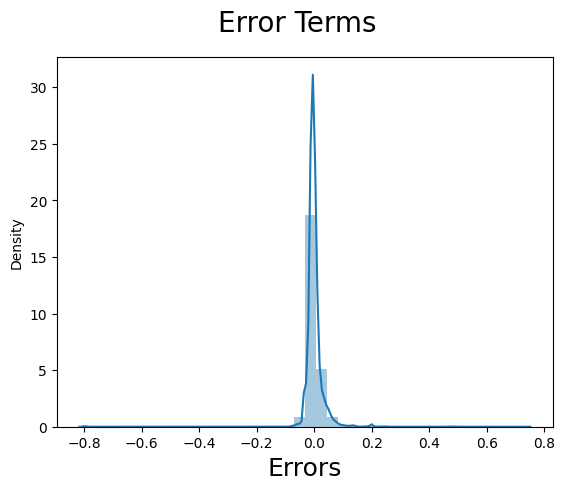

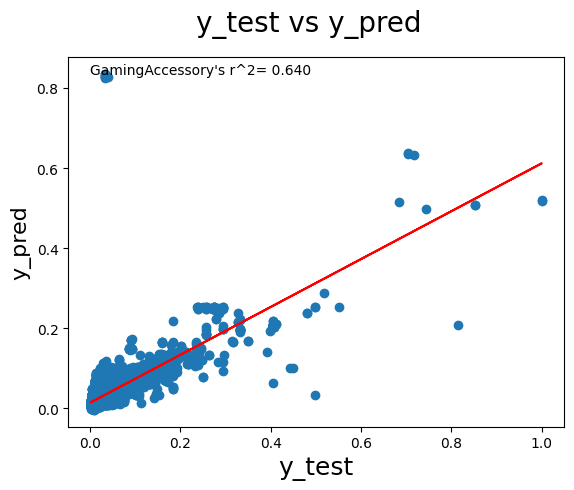

In [ ]:
lg_GA=UDFLinearRegressionModel(dfSource_GamingAccessory,train_size_=0.7,test_size_=0.3,Target_Variable_=_Target_Variable,_datasetname='GamingAccessory',showModelTitle=False)
lg_GA.ProcessModelAndShowResults()

InitDFForDataModelling...
InitTestTrainData...
PerformScaling.....
InitModelXY....
Basic Linear Regression Modelling
InitRFE...
Initialize Model Fit....
(Re)initializing Model Result
Removing Columns with insiginificant p-values=====
DropAndRefitInsignificantColumns_ByPValues....
DockingStation 0.9856782151160149 30
Dropping = DockingStation  with P-Value=  0.9856782151160149
REFITTING
(Re)initializing Model Result
SlingBox 0.9700492468362865 29
Dropping = SlingBox  with P-Value=  0.9700492468362865
REFITTING
(Re)initializing Model Result
Markup 0.890314989974955 28
Dropping = Markup  with P-Value=  0.890314989974955
REFITTING
(Re)initializing Model Result
Pay_Date 0.8945993055499382 27
Dropping = Pay_Date  with P-Value=  0.8945993055499382
REFITTING
(Re)initializing Model Result
HomeAudioSpeaker 0.8908911008729913 26
Dropping = HomeAudioSpeaker  with P-Value=  0.8908911008729913
REFITTING
(Re)initializing Model Result
HiFiSystem 0.8788130093314299 25
Dropping = HiFiSystem  with P-Valu

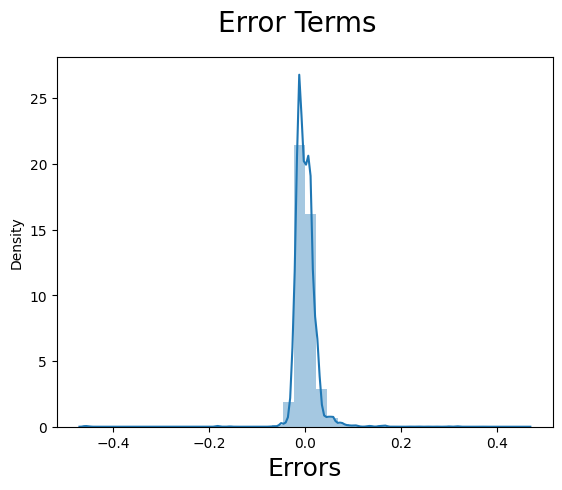

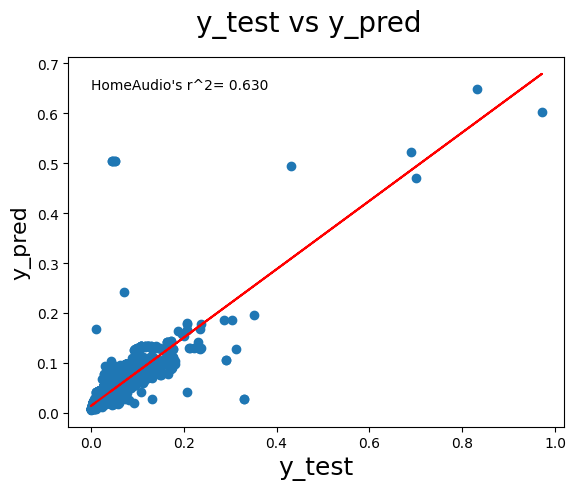

In [ ]:
lg_HA=UDFLinearRegressionModel(dfSource_HomeAudio,train_size_=0.7,test_size_=0.3,Target_Variable_=_Target_Variable,_datasetname='HomeAudio',showModelTitle=False)
lg_HA.ProcessModelAndShowResults()

# **Model Equation for Each of the Sub Category**

**CameraAccessory Model Equation**

In [ ]:
lg_CA.getModelEquation()

'0.0002*Radio+-0.0003*sla+0.0009*Digital+-0.0005*Other+0.0001*Filter+-0.0007*NPS+0.001*deliverycdays+0.0004*CameraAccessory+0.0004*CameraBattery+0.0014*CameraFilmRolls+0.0578*const+0.9998*product_mrp+-0.5183*discount'

**Gaming Accessory Model Equation**

In [ ]:
lg_GA.getModelEquation()

'-0.0005*Pay_Date+-0.0021*sla+0.0004*GamePad+-0.0009*Online marketing+0.0016*JoystickGamingWheel+0.0019*TVOutCableAccessory+0.0361*const+-1.8673*discount+1.8652*product_mrp'

**Home Audio Model Equation**

In [ ]:
lg_HA.getModelEquation()

'-0.0022*Sponsorship+0.0046*VoiceRecorder+0.0218*const+-0.923*discount+1.0202*product_mrp'

**[End of File]**

**Product Assortment**

In [ ]:
dfgc=dfSource.groupby(['product_analytic_sub_category','product_analytic_vertical'])[["Year",'sla']].agg({"Year":['min','max'],'sla':['min','max']}).reset_index()
dfgc


product_analytic_sub_category product_analytic_vertical  Year       sla    
                                                             min   max min max
0                CameraAccessory                Binoculars  2016  2016   0  26
1                CameraAccessory           CameraAccessory  2016  2016   3  27
2                CameraAccessory                 CameraBag  2015  2016   0  27
3                CameraAccessory             CameraBattery  2015  2016   0  27
4                CameraAccessory      CameraBatteryCharger  2015  2016   0  22
5                CameraAccessory         CameraBatteryGrip  2016  2016   4   9
6                CameraAccessory              CameraEyeCup  2016  2016   3  11
7                CameraAccessory           CameraFilmRolls  2016  2016   0  14
8                CameraAccessory             CameraHousing  2016  2016   3  10
9                CameraAccessory          CameraMicrophone  2016  2016   4   9
10               CameraAccessory               CameraMount  2016  2016   1  23
11               CameraAccessory       CameraRemoteControl  2015  2016   0  22
12               CameraAccessory              CameraTripod  2015  2016   0  19
13               CameraAccessory             ExtensionTube  2016  2016   4  26
14               CameraAccessory                    Filter  2016  2016   0  32
15               CameraAccessory                     Flash  2015  2016   0  25
16               CameraAccessory          FlashShoeAdapter  2016  2016   5   5
17               CameraAccessory                      Lens  2015  2016   0  27
18               CameraAccessory                   Softbox  2016  2016   3   7
19               CameraAccessory                     Strap  2016  2016   3  26
20               CameraAccessory                 Telescope  2016  2016   3  25
21               GamingAccessory                CoolingPad  2016  2016   0   9
22               GamingAccessory                   GamePad  2015  2016   0  25
23               GamingAccessory        GamingAccessoryKit  2015  2016   0  17
24               GamingAccessory             GamingAdapter  2015  2016   0  17
25               GamingAccessory     GamingChargingStation  2016  2016   6   6
26               GamingAccessory             GamingHeadset  2015  2016   0  23
27               GamingAccessory            GamingKeyboard  2016  2016   0  25
28               GamingAccessory          GamingMemoryCard  2016  2016   1  14
29               GamingAccessory               GamingMouse  2015  2016   0  25
30               GamingAccessory            GamingMousePad  2015  2016   0  18
31               GamingAccessory             GamingSpeaker  2016  2016   3  14
32               GamingAccessory       JoystickGamingWheel  2016  2016   0  23
33               GamingAccessory          MotionController  2016  2016   1  23
34               GamingAccessory       TVOutCableAccessory  2015  2016   0  32
35                     HomeAudio                   BoomBox  2015  2016   0  25
36                     HomeAudio              DJController  2016  2016   3   8
37                     HomeAudio                      Dock  2016  2016   3  16
38                     HomeAudio            DockingStation  2016  2016   2  12
39                     HomeAudio                   FMRadio  2015  2016   0  18
40                     HomeAudio                HiFiSystem  2016  2016   3  10
41                     HomeAudio          HomeAudioSpeaker  2015  2016   0  22
42                     HomeAudio                  SlingBox  2016  2016   8   8
43                     HomeAudio                SoundMixer  2016  2016   4  12
44                     HomeAudio             VoiceRecorder  2016  2016   1  18

In [ ]:
dfpvt2_sla=pd.pivot_table(dfSource,index=['product_analytic_sub_category'],columns=['sla'],values=['Total_Sales_Million'],aggfunc='sum').reset_index()
dfpvt2_sla.fillna(0,inplace=True)
dfpvt2_sla=dfpvt2_sla.T.reset_index()
dfpvt2_sla.columns=dfpvt2_sla.iloc[0]
dfpvt2_sla=dfpvt2_sla.iloc[1:]
dfpvt2_sla.columns=['product_analytic_sub_category', 'sla', 'CameraAccessory',
       'GamingAccessory', 'HomeAudio']
dfpvt2_sla=dfpvt2_sla.sort_values(by=['sla'],ascending=False)
dfpvt2_sla


product_analytic_sub_category sla CameraAccessory GamingAccessory HomeAudio
30           Total_Sales_Million  32        0.011604         0.00018       0.0
29           Total_Sales_Million  28        0.002835             0.0       0.0
28           Total_Sales_Million  27        0.025108             0.0       0.0
27           Total_Sales_Million  26        0.085352             0.0       0.0
26           Total_Sales_Million  25        0.156177        0.004897   0.00385
25           Total_Sales_Million  24        0.104533             0.0       0.0
24           Total_Sales_Million  23        0.032133        0.007488       0.0
23           Total_Sales_Million  22        0.079252         0.00146   0.00599
22           Total_Sales_Million  21        0.040607        0.003376       0.0
21           Total_Sales_Million  20        0.013422        0.002237       0.0
20           Total_Sales_Million  19        0.009181        0.006796   0.00654
19           Total_Sales_Million  18        0.010221        0.007481  0.004974
18           Total_Sales_Million  17        0.008589        0.007854  0.002549
17           Total_Sales_Million  16        0.037932        0.021539  0.004109
16           Total_Sales_Million  15        0.036624        0.019857  0.015173
15           Total_Sales_Million  14        0.158076        0.029796  0.017741
14           Total_Sales_Million  13        0.163848        0.188767  0.050114
13           Total_Sales_Million  12        0.497256        0.192977  0.114576
12           Total_Sales_Million  11        1.093598        0.566337  0.379373
11           Total_Sales_Million  10        1.676085        0.905107  0.859169
10           Total_Sales_Million   9        3.307047        2.164612  1.920047
9            Total_Sales_Million   8        6.225078          3.3438  2.637755
8            Total_Sales_Million   7        8.791586        6.524863  4.499597
7            Total_Sales_Million   6        12.06756        8.836659  7.097276
6            Total_Sales_Million   5       13.980084        7.528077    5.4135
5            Total_Sales_Million   4       12.141478        8.348311   6.02203
4            Total_Sales_Million   3        6.106463        5.238587  4.464817
3            Total_Sales_Million   2        1.612179        1.341384   2.09072
2            Total_Sales_Million   1        4.298069        2.474119  3.917106
1            Total_Sales_Million   0        0.390349        0.427979  0.441772

In [ ]:
dfSource["Invst_Total_Million"]=dfSource["Invst_Total"]/1000000
dfpvt2=pd.pivot_table(dfSource,index=['product_analytic_sub_category'],columns=['Year'],values=['Invst_Total_Million'],aggfunc='sum').reset_index()
dfpvt2.fillna(0,inplace=True)
dfpvt2

product_analytic_sub_category Invst_Total_Million          
Year                                              2015      2016
0                  CameraAccessory            0.002173  4.596088
1                  GamingAccessory            0.002343  3.027973
2                        HomeAudio            0.000716  1.218858

In [ ]:
dfpvt2=pd.pivot_table(dfSource,index=['product_analytic_sub_category','product_analytic_vertical'],columns=['Year'],values=['Total_Sales_Million'],aggfunc='sum').reset_index()
dfpvt2.fillna(0,inplace=True)
dfpvt2

product_analytic_sub_category product_analytic_vertical  \
Year                                                           
0                  CameraAccessory                Binoculars   
1                  CameraAccessory           CameraAccessory   
2                  CameraAccessory                 CameraBag   
3                  CameraAccessory             CameraBattery   
4                  CameraAccessory      CameraBatteryCharger   
5                  CameraAccessory         CameraBatteryGrip   
6                  CameraAccessory              CameraEyeCup   
7                  CameraAccessory           CameraFilmRolls   
8                  CameraAccessory             CameraHousing   
9                  CameraAccessory          CameraMicrophone   
10                 CameraAccessory               CameraMount   
11                 CameraAccessory       CameraRemoteControl   
12                 CameraAccessory              CameraTripod   
13                 CameraAccessory             ExtensionTube   
14                 CameraAccessory                    Filter   
15                 CameraAccessory                     Flash   
16                 CameraAccessory          FlashShoeAdapter   
17                 CameraAccessory                      Lens   
18                 CameraAccessory                   Softbox   
19                 CameraAccessory                     Strap   
20                 CameraAccessory                 Telescope   
21                 GamingAccessory                CoolingPad   
22                 GamingAccessory                   GamePad   
23                 GamingAccessory        GamingAccessoryKit   
24                 GamingAccessory             GamingAdapter   
25                 GamingAccessory     GamingChargingStation   
26                 GamingAccessory             GamingHeadset   
27                 GamingAccessory            GamingKeyboard   
28                 GamingAccessory          GamingMemoryCard   
29                 GamingAccessory               GamingMouse   
30                 GamingAccessory            GamingMousePad   
31                 GamingAccessory             GamingSpeaker   
32                 GamingAccessory       JoystickGamingWheel   
33                 GamingAccessory          MotionController   
34                 GamingAccessory       TVOutCableAccessory   
35                       HomeAudio                   BoomBox   
36                       HomeAudio              DJController   
37                       HomeAudio                      Dock   
38                       HomeAudio            DockingStation   
39                       HomeAudio                   FMRadio   
40                       HomeAudio                HiFiSystem   
41                       HomeAudio          HomeAudioSpeaker   
42                       HomeAudio                  SlingBox   
43                       HomeAudio                SoundMixer   
44                       HomeAudio             VoiceRecorder   

     Total_Sales_Million             
Year                2015       2016  
0               0.000000   6.620800  
1               0.000000   0.416193  
2               0.006399   7.529706  
3               0.005493   7.442266  
4               0.001055   3.288964  
5               0.000000   0.308565  
6               0.000000   0.019181  
7               0.000000   1.258886  
8               0.000000   0.035682  
9               0.000000   0.020768  
10              0.000000   0.133825  
11              0.002900   0.823277  
12              0.010765   4.507283  
13              0.000000   0.063238  
14              0.000000   2.869063  
15              0.000649   7.093698  
16              0.000000   0.000380  
17              0.031018  29.147812  
18              0.000000   0.009966  
19              0.000000   0.558128  
20              0.000000   0.956366  
21              0.000000   0.021665  
22              0.014306  20.065888  
23              0.000778   2.450709  
24      

# Conclusion